In [8]:
!pip3 install xgboost
!pip3 install decision-tree-morfist
!pip3 install catboost
!pip3 install openpyxl

  Using cached decision_tree_morfist-0.3.3-py3-none-any.whl (12 kB)
  Using cached numba-0.51.2.tar.gz (2.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached llvmlite-0.34.0.tar.gz (107 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for numba
  Running setup.py clean for llvmlite
Failed to build numba llvmlite
  Running setup.py install for llvmlite: started
  Running setup.py install for llvmlite: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [761 lines of output]
  TBB not found
  Using OpenMP from: True
  running bdist_wheel
  running build
  got version from file C:\Users\Albert\AppData\Local\Temp\pip-install-_wdtb9xp\numba_f40591a86bb74a61b8f199f67cfd0808\numba/_version.py {'version': '0.51.2', 'full': '9d570961590c09a1eba748c9c37e91d1224fc9ad'}
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-310
  creating build\lib.win-amd64-cpython-310\numba
  copying numba\extending.py -> build\lib.win-amd64-cpython-310\numba
  copying numba\runtests.py -> build\lib.win-amd64-cpython-310\numba
  copying numba\_version.py -> build\lib.win-amd64-cpython-310\numba
  copying numba\__init__.py -> build\lib.win-amd64-cpython-310\numba
  copying numba\__main__.py -> build\lib.win-amd64-cpython-310\numba
  creating build\lib.win-amd64-cpython-310\numba\cext
  copying numba\cext\__init__.py -> build\

In [24]:
import config
import ast
import pickle
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import statistics

from utils.pandas_dataframe import grid_display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from itertools import permutations
import gc

# validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

# grid search
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV


from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor

from IPython.display import display


%matplotlib inline

In [25]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format',lambda x: '%.2f' % x)
# pd.set_option('display.max_rows', 5)
pd.set_option('display.max_rows', None)

In [26]:
def Col_types(Data):
    Column_types = Data.dtypes.to_frame().reset_index()
    Column_types.columns = ['ColumnName', 'Type']
    Column_types.sort_values( by= 'Type', inplace = True)
    return Column_types

def Missing_Counts(Data):
    missing = Data.isnull().sum()
    missing = missing[ missing >0]
    missing.sort_values( inplace=True)
    Missing_Count = pd.DataFrame({ 'ColumnName':missing.index, 'MissingCount':missing.values})
    Missing_Count['Percentage(%)'] = Missing_Count['MissingCount'].apply(lambda x:round(x/Data.shape[0]*100,2))
    return Missing_Count

In [42]:
with open('../Data/meta/train_x_after_feature_engineering.pickle', 'rb') as f:
    data_x = pickle.load(f)
data_x.head()

,clean_pressure31,clean_pressure41,clean_pressure72,clean_pressure81,clean_pressure91,clean_pressure92,clean_pressure102,oven_pa1,oven_pa2,oven_pb1,...,painting_g9_act_hvc_group,painting_g10_act_hvv_group,painting_g10_act_hvc_group,painting_g11_act_a_air_group,painting_g11_act_hvc_group,env_rpi05_temp_group,env_rpi07_pm10_group,env_rpi07_pm25_group,env_rpi14_pm1_group,env_rpi15_pm1_group
0,-0.85,2.37,2.96,1.95,-0.41,-3.38,0.83,1.87,1.37,4.01,...,0,3,2,1,1,1,2,0,2,3
4,-0.86,2.37,2.96,1.82,-0.55,-3.38,0.83,1.95,1.32,3.38,...,3,3,2,1,1,1,0,2,2,3
5,-0.86,2.37,2.96,1.82,-0.55,-3.38,0.83,1.95,1.32,3.38,...,3,3,2,1,1,1,0,2,2,3
6,-0.86,2.37,2.96,1.82,-0.55,-3.38,0.83,1.95,1.32,3.38,...,3,3,2,1,1,1,0,2,2,3
7,-0.86,2.37,2.96,1.82,-0.55,-3.38,0.83,1.95,1.32,3.38,...,3,3,2,1,1,1,0,2,2,3


In [43]:
with open('../Data/meta/train_y_after_feature_engineering.pickle', 'rb') as f:
    data_y = pickle.load(f)
data_y.head()

,sensor_point5_i_value,sensor_point6_i_value,sensor_point7_i_value,sensor_point8_i_value,sensor_point9_i_value,sensor_point10_i_value
0,-2.93,-1.36,-1.12,-1.68,-0.75,-2.82
4,-1.75,-0.55,-1.91,-1.25,-1.20,-1.62
5,-2.93,-0.77,-1.04,-1.12,-1.60,-1.68
6,-2.46,-0.77,-0.72,-1.68,-0.60,-2.64
7,-2.38,-1.21,-1.28,-2.03,-1.95,-2.22


### 檢查資料屬性

In [44]:
display(Col_types(data_x))

,ColumnName,Type
0,clean_pressure31,float64
29,painting_g7_act_hvv,float64
30,painting_g9_act_hvv,float64
32,painting_g11_act_hvv,float64
33,painting_g12_act_a_air,float64
34,env_rpi05_hum,float64
35,env_rpi05_pm1,float64
36,env_rpi07_hum,float64
37,env_rpi07_pm10,float64
38,env_rpi07_temp,float64


### Onehot encoding轉換類別型變數，並將原類別型變數刪除

In [45]:
# onehot encoding
for index , col in enumerate(data_x.columns.tolist()):
    if data_x[col].dtype == 'object':
        data_x = data_x.join(pd.get_dummies(data_x[col],prefix=col))
        data_x = data_x.drop(col, axis = 1)

### 執行完onehot encoding後再次檢查資料屬性

In [46]:
display(Col_types(data_x))

,ColumnName,Type
54,painting_g8_act_a_air_group_1,uint8
78,painting_g11_act_a_air_group_3,uint8
77,painting_g11_act_a_air_group_2,uint8
76,painting_g11_act_a_air_group_1,uint8
75,painting_g11_act_a_air_group_0,uint8
74,painting_g10_act_hvc_group_5,uint8
73,painting_g10_act_hvc_group_4,uint8
72,painting_g10_act_hvc_group_3,uint8
71,painting_g10_act_hvc_group_2,uint8
70,painting_g10_act_hvc_group_1,uint8


In [33]:
display(data_x.columns.tolist())

['clean_pressure31',
 'clean_pressure41',
 'clean_pressure72',
 'clean_pressure81',
 'clean_pressure91',
 'clean_pressure92',
 'clean_pressure102',
 'oven_pa1',
 'oven_pa2',
 'oven_pb1',
 'oven_pb2',
 'oven_a3',
 'oven_b1',
 'oven_b2',
 'painting_g1_act_a_air',
 'painting_g1_act_f_air',
 'painting_g1_act_t_air',
 'painting_g1_act_hvc',
 'painting_g3_act_t_air',
 'painting_g3_act_hvv',
 'painting_g4_act_f_air',
 'painting_g4_act_hvv',
 'painting_g4_act_hvc',
 'painting_g5_act_a_air',
 'painting_g5_act_f_air',
 'painting_g6_act_a_air',
 'painting_g6_act_hvc',
 'painting_g7_act_f_air',
 'painting_g7_act_t_air',
 'painting_g7_act_hvv',
 'painting_g9_act_hvv',
 'painting_g10_act_f_air',
 'painting_g11_act_hvv',
 'painting_g12_act_a_air',
 'env_rpi05_hum',
 'env_rpi05_pm1',
 'env_rpi07_hum',
 'env_rpi07_pm10',
 'env_rpi07_temp',
 'env_rpi09_hum',
 'env_rpi09_lux',
 'env_rpi09_pm1',
 'env_rpi09_temp',
 'env_rpi14_hum',
 'env_rpi14_lux',
 'env_rpi14_pm1',
 'env_rpi14_pm10',
 'env_rpi14_temp',


# 1.X變數標準化

In [34]:
# X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, train_size = 0.8, random_state = 3)

# X變數標準化
scaler = StandardScaler().fit(data_x)
data_x_S = scaler.transform(data_x)

# 2.迴圈計算每個Y在每個模型下的最佳超參數，並計算RMSE值及預測結果
### 分別計算每個Model的最佳超參數及RMSE，以判斷6個 Y的最佳 Model

In [11]:
# 分別計算每個Model的最佳超參數及RMSE，以判斷6個 Y的最佳 Model
# model(含超參數設定)
Lasso_params_list = []
Ridge_params_list = []
XGB_params_list = []
KN_params_list = []
Ada_params_list = []
Cat_params_list = []

# K-fold RMSE
Lasso_RMSE = []
Ridge_RMSE = []
XGB_RMSE = []
KN_RMSE = []
Ada_RMSE = []
Cat_RMSE = []

Model_result = pd.DataFrame({})

for i in range(6):

# Gridsearch超參數範圍
  

# 1. Lasso_model
    # 交叉驗證取超參數    
    config.grid_search_Lasso.fit(data_x_S, data_y.iloc[:,i])

    # 建立 pipeline
    poly_Lasso_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Lasso(**config.grid_search_Lasso.best_params_))
                              ])
    
    # k-folde計算RMSE(cv = 5)
    Lasso_RMSE.append(-cross_val_score(poly_Lasso_reg, 
                                       data_x, data_y.iloc[:,i], 
                                       cv = 5, 
                                       scoring = 'neg_root_mean_squared_error').mean())

    # 訓練模型
    poly_Lasso_reg.fit(data_x, data_y.iloc[:,i])
    

# 2. Ridge_model
    # 交叉驗證取超參數
    config.grid_search_Ridge.fit(data_x_S, data_y.iloc[:,i])
    
    # 建立 pipeline
    poly_Ridge_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Ridge(**config.grid_search_Ridge.best_params_))
                              ])
    
    # k-folde計算RMSE(cv = 5)
    Ridge_RMSE.append(-cross_val_score(poly_Ridge_reg, 
                                       data_x, data_y.iloc[:,i], 
                                       cv = 5, 
                                       scoring = 'neg_root_mean_squared_error').mean())

    # 訓練模型
    poly_Ridge_reg.fit(data_x, data_y.iloc[:,i])

# 3. XGB_model
    # 交叉驗證取超參數  
    config.grid_search_XGB.fit(data_x_S, data_y.iloc[:,i])

    # 建立 pipeline    
    poly_XGB_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                            ('std_scaler', StandardScaler()),
                            ('xgb_reg', xgb.XGBRegressor(**config.grid_search_XGB.best_params_))
                            ])
    
    # k-folde計算RMSE(cv = 5)
    XGB_RMSE.append(-cross_val_score(poly_XGB_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    # 訓練模型    
    poly_XGB_reg.fit(data_x, data_y.iloc[:,i])


# 4. KN_model
    # 交叉驗證取超參數  
    config.grid_search_KN.fit(data_x_S, data_y.iloc[:,i])

    # 建立 pipeline
    poly_KN_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.grid_search_KN.best_params_))
                        ])
    
    # k-folde計算RMSE(cv = 5)
    KN_RMSE.append(-cross_val_score(poly_KN_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    # 訓練模型    
    poly_KN_reg.fit(data_x, data_y.iloc[:,i])    

# 5. Ada_model
    # 交叉驗證取超參數  
    config.grid_search_Ada.fit(data_x_S, data_y.iloc[:,i])

    # 建立 pipeline
    poly_Ada_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                             ('std_scaler', StandardScaler()),
                             ('Ada', AdaBoostRegressor(**config.grid_search_Ada.best_params_))
                            ]) 
    
    # k-folde計算RMSE(cv = 5)
    Ada_RMSE.append(-cross_val_score(poly_Ada_reg, 
                                     data_x, data_y.iloc[:,i], 
                                     cv = 5, 
                                     scoring = 'neg_root_mean_squared_error').mean())
    
    # 訓練模型    
    poly_Ada_reg.fit(data_x, data_y.iloc[:,i])        

    
# 6. Cat_model
    # 交叉驗證取超參數  
    config.grid_search_Cat.fit(data_x_S, data_y.iloc[:,i])

    # 建立 pipeline
    poly_Cat_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                             ('std_scaler', StandardScaler()),
                             ('Cat', CatBoostRegressor(**config.grid_search_Cat.best_params_))
                            ]) 
    
    # k-folde計算RMSE(cv = 5)
    Cat_RMSE.append(-cross_val_score(poly_Cat_reg, 
                                     data_x, data_y.iloc[:,i], 
                                     cv = 5, 
                                     scoring = 'neg_root_mean_squared_error').mean())
    
    # 訓練模型
    poly_Cat_reg.fit(data_x, data_y.iloc[:,i])       

    
# 將超參數放入List中
    Lasso_params_list.append(config.grid_search_Lasso.best_params_)
    Ridge_params_list.append(config.grid_search_Ridge.best_params_)
    XGB_params_list.append(config.grid_search_XGB.best_params_)
    KN_params_list.append(config.grid_search_KN.best_params_)
    Ada_params_list.append(config.grid_search_Ada.best_params_)
    Cat_params_list.append(config.grid_search_Cat.best_params_)   
    
# 將模型預測結果放入Model_result
    
    Model_result['Actual_'+ data_y.columns.tolist()[i]] = data_y.iloc[:,i]
    Model_result['Lasso_'+ data_y.columns.tolist()[i]] = poly_Lasso_reg.predict(data_x)
    Model_result['Ridge_'+ data_y.columns.tolist()[i]] = poly_Ridge_reg.predict(data_x)
    Model_result['XGB_'+ data_y.columns.tolist()[i]] = poly_XGB_reg.predict(data_x)
    Model_result['KN_'+ data_y.columns.tolist()[i]] = poly_KN_reg.predict(data_x)
    Model_result['Ada_'+ data_y.columns.tolist()[i]] = poly_Ada_reg.predict(data_x)    
    Model_result['Cat_'+ data_y.columns.tolist()[i]] = poly_Cat_reg.predict(data_x)  
    
# list 串接成 pandas表格    
Model_RMSE = pd.DataFrame({'Lasso':Lasso_params_list,
                           'Lasso_RMSE':Lasso_RMSE,
                           'Ridge':Ridge_params_list,
                           'Ridge_RMSE':Ridge_RMSE,
                           'XGB':XGB_params_list,
                           'XGB_RMSE':XGB_RMSE,
                           'KN':KN_params_list,
                           'KN_RMSE':KN_RMSE,
                           'Ada':Ada_params_list,
                           'Ada_RMSE':Ada_RMSE,
                           'Cat':Cat_params_list,
                           'Cat_RMSE':Cat_RMSE
                          }, index = list(data_y.columns))

display(Model_RMSE)
display(Model_result)

# 資料存成 Pickle檔案
with open('../Output/Model_RMSE.pickle', 'wb') as f:
    pickle.dump(Model_RMSE, f)
    
# with open('../Data/output/Model_result.pickle', 'wb') as f:
#     pickle.dump(Model_result, f)    
# 資料輸出到Excel檔案
# output = pd.ExcelWriter('../Data/output.xlsx')
# Model_RMSE.to_excel(output, sheet_name = 'Model_RMSE',index = False)
# Model_result.to_excel(output, sheet_name = 'Model_result',index = False)

# output.save()

0:	learn: 0.9878011	total: 19.3ms	remaining: 9.63s
1:	learn: 0.9756326	total: 37.7ms	remaining: 9.39s
2:	learn: 0.9644642	total: 55.3ms	remaining: 9.16s
3:	learn: 0.9535935	total: 73.1ms	remaining: 9.07s
4:	learn: 0.9422256	total: 102ms	remaining: 10.1s
5:	learn: 0.9308006	total: 134ms	remaining: 11s
6:	learn: 0.9188431	total: 153ms	remaining: 10.8s
7:	learn: 0.9075818	total: 170ms	remaining: 10.4s
8:	learn: 0.8977857	total: 187ms	remaining: 10.2s
9:	learn: 0.8890203	total: 205ms	remaining: 10s
10:	learn: 0.8787991	total: 224ms	remaining: 9.98s
11:	learn: 0.8686508	total: 248ms	remaining: 10.1s
12:	learn: 0.8606348	total: 273ms	remaining: 10.2s
13:	learn: 0.8515256	total: 292ms	remaining: 10.1s
14:	learn: 0.8432622	total: 311ms	remaining: 10.1s
15:	learn: 0.8344240	total: 330ms	remaining: 9.98s
16:	learn: 0.8266031	total: 350ms	remaining: 9.95s
17:	learn: 0.8184853	total: 371ms	remaining: 9.93s
18:	learn: 0.8107623	total: 391ms	remaining: 9.89s
19:	learn: 0.8040013	total: 411ms	remaini

163:	learn: 0.5335853	total: 3.25s	remaining: 6.67s
164:	learn: 0.5330144	total: 3.27s	remaining: 6.65s
165:	learn: 0.5327826	total: 3.29s	remaining: 6.63s
166:	learn: 0.5324493	total: 3.31s	remaining: 6.6s
167:	learn: 0.5319716	total: 3.33s	remaining: 6.58s
168:	learn: 0.5315476	total: 3.35s	remaining: 6.55s
169:	learn: 0.5310761	total: 3.36s	remaining: 6.53s
170:	learn: 0.5307812	total: 3.38s	remaining: 6.51s
171:	learn: 0.5302381	total: 3.4s	remaining: 6.49s
172:	learn: 0.5295140	total: 3.42s	remaining: 6.46s
173:	learn: 0.5293031	total: 3.44s	remaining: 6.44s
174:	learn: 0.5288583	total: 3.45s	remaining: 6.41s
175:	learn: 0.5281342	total: 3.47s	remaining: 6.39s
176:	learn: 0.5276120	total: 3.49s	remaining: 6.37s
177:	learn: 0.5270614	total: 3.51s	remaining: 6.35s
178:	learn: 0.5265713	total: 3.53s	remaining: 6.33s
179:	learn: 0.5262008	total: 3.55s	remaining: 6.31s
180:	learn: 0.5256655	total: 3.57s	remaining: 6.29s
181:	learn: 0.5252153	total: 3.58s	remaining: 6.26s
182:	learn: 0.

331:	learn: 0.4752777	total: 6.32s	remaining: 3.2s
332:	learn: 0.4750030	total: 6.34s	remaining: 3.18s
333:	learn: 0.4747237	total: 6.36s	remaining: 3.16s
334:	learn: 0.4744271	total: 6.38s	remaining: 3.14s
335:	learn: 0.4742172	total: 6.4s	remaining: 3.12s
336:	learn: 0.4739694	total: 6.42s	remaining: 3.1s
337:	learn: 0.4735569	total: 6.43s	remaining: 3.08s
338:	learn: 0.4732214	total: 6.45s	remaining: 3.06s
339:	learn: 0.4725901	total: 6.47s	remaining: 3.04s
340:	learn: 0.4723188	total: 6.49s	remaining: 3.02s
341:	learn: 0.4720109	total: 6.5s	remaining: 3s
342:	learn: 0.4717068	total: 6.52s	remaining: 2.99s
343:	learn: 0.4714054	total: 6.54s	remaining: 2.97s
344:	learn: 0.4710818	total: 6.56s	remaining: 2.95s
345:	learn: 0.4706464	total: 6.58s	remaining: 2.93s
346:	learn: 0.4703807	total: 6.6s	remaining: 2.91s
347:	learn: 0.4702112	total: 6.62s	remaining: 2.89s
348:	learn: 0.4698405	total: 6.64s	remaining: 2.87s
349:	learn: 0.4694906	total: 6.65s	remaining: 2.85s
350:	learn: 0.469310

490:	learn: 0.4464364	total: 9.27s	remaining: 170ms
491:	learn: 0.4462506	total: 9.29s	remaining: 151ms
492:	learn: 0.4460720	total: 9.31s	remaining: 132ms
493:	learn: 0.4458713	total: 9.33s	remaining: 113ms
494:	learn: 0.4457081	total: 9.35s	remaining: 94.4ms
495:	learn: 0.4455334	total: 9.37s	remaining: 75.5ms
496:	learn: 0.4452184	total: 9.38s	remaining: 56.6ms
497:	learn: 0.4449071	total: 9.4s	remaining: 37.8ms
498:	learn: 0.4446365	total: 9.42s	remaining: 18.9ms
499:	learn: 0.4443590	total: 9.44s	remaining: 0us
0:	learn: 0.9452622	total: 997ms	remaining: 8m 17s
1:	learn: 0.9345869	total: 1.79s	remaining: 7m 25s
2:	learn: 0.9230905	total: 2.5s	remaining: 6m 53s
3:	learn: 0.9126050	total: 3.2s	remaining: 6m 37s
4:	learn: 0.9018814	total: 3.9s	remaining: 6m 26s
5:	learn: 0.8917927	total: 4.57s	remaining: 6m 16s
6:	learn: 0.8820667	total: 5.27s	remaining: 6m 10s
7:	learn: 0.8723842	total: 5.97s	remaining: 6m 7s
8:	learn: 0.8636690	total: 6.57s	remaining: 5m 58s
9:	learn: 0.8541279	tot

148:	learn: 0.5345951	total: 1m 39s	remaining: 3m 53s
149:	learn: 0.5335892	total: 1m 40s	remaining: 3m 53s
150:	learn: 0.5331328	total: 1m 40s	remaining: 3m 52s
151:	learn: 0.5326861	total: 1m 41s	remaining: 3m 52s
152:	learn: 0.5322752	total: 1m 42s	remaining: 3m 51s
153:	learn: 0.5317649	total: 1m 42s	remaining: 3m 50s
154:	learn: 0.5315559	total: 1m 43s	remaining: 3m 50s
155:	learn: 0.5310250	total: 1m 44s	remaining: 3m 49s
156:	learn: 0.5304305	total: 1m 44s	remaining: 3m 48s
157:	learn: 0.5301886	total: 1m 45s	remaining: 3m 47s
158:	learn: 0.5298291	total: 1m 45s	remaining: 3m 47s
159:	learn: 0.5290474	total: 1m 46s	remaining: 3m 46s
160:	learn: 0.5287476	total: 1m 47s	remaining: 3m 45s
161:	learn: 0.5279165	total: 1m 47s	remaining: 3m 44s
162:	learn: 0.5276698	total: 1m 48s	remaining: 3m 44s
163:	learn: 0.5268275	total: 1m 49s	remaining: 3m 43s
164:	learn: 0.5262003	total: 1m 49s	remaining: 3m 42s
165:	learn: 0.5259656	total: 1m 50s	remaining: 3m 42s
166:	learn: 0.5257025	total:

301:	learn: 0.4718710	total: 3m 21s	remaining: 2m 12s
302:	learn: 0.4715257	total: 3m 22s	remaining: 2m 11s
303:	learn: 0.4711290	total: 3m 23s	remaining: 2m 10s
304:	learn: 0.4708362	total: 3m 23s	remaining: 2m 10s
305:	learn: 0.4705320	total: 3m 24s	remaining: 2m 9s
306:	learn: 0.4702845	total: 3m 24s	remaining: 2m 8s
307:	learn: 0.4698237	total: 3m 25s	remaining: 2m 8s
308:	learn: 0.4694787	total: 3m 26s	remaining: 2m 7s
309:	learn: 0.4690786	total: 3m 26s	remaining: 2m 6s
310:	learn: 0.4684020	total: 3m 27s	remaining: 2m 6s
311:	learn: 0.4680534	total: 3m 28s	remaining: 2m 5s
312:	learn: 0.4678959	total: 3m 28s	remaining: 2m 4s
313:	learn: 0.4677400	total: 3m 29s	remaining: 2m 4s
314:	learn: 0.4674907	total: 3m 30s	remaining: 2m 3s
315:	learn: 0.4668786	total: 3m 31s	remaining: 2m 2s
316:	learn: 0.4665473	total: 3m 32s	remaining: 2m 2s
317:	learn: 0.4664061	total: 3m 32s	remaining: 2m 1s
318:	learn: 0.4662690	total: 3m 33s	remaining: 2m 1s
319:	learn: 0.4659461	total: 3m 34s	remain

455:	learn: 0.4329676	total: 5m 7s	remaining: 29.7s
456:	learn: 0.4328770	total: 5m 8s	remaining: 29s
457:	learn: 0.4327287	total: 5m 9s	remaining: 28.3s
458:	learn: 0.4326202	total: 5m 9s	remaining: 27.7s
459:	learn: 0.4324642	total: 5m 10s	remaining: 27s
460:	learn: 0.4323568	total: 5m 11s	remaining: 26.3s
461:	learn: 0.4322424	total: 5m 11s	remaining: 25.6s
462:	learn: 0.4319520	total: 5m 12s	remaining: 25s
463:	learn: 0.4318851	total: 5m 13s	remaining: 24.3s
464:	learn: 0.4316228	total: 5m 13s	remaining: 23.6s
465:	learn: 0.4314468	total: 5m 14s	remaining: 22.9s
466:	learn: 0.4312477	total: 5m 15s	remaining: 22.3s
467:	learn: 0.4310451	total: 5m 15s	remaining: 21.6s
468:	learn: 0.4307907	total: 5m 16s	remaining: 20.9s
469:	learn: 0.4305619	total: 5m 17s	remaining: 20.2s
470:	learn: 0.4304573	total: 5m 17s	remaining: 19.6s
471:	learn: 0.4304024	total: 5m 18s	remaining: 18.9s
472:	learn: 0.4303096	total: 5m 19s	remaining: 18.2s
473:	learn: 0.4301369	total: 5m 19s	remaining: 17.5s
474

113:	learn: 0.5162868	total: 1m 17s	remaining: 4m 21s
114:	learn: 0.5154033	total: 1m 17s	remaining: 4m 20s
115:	learn: 0.5146990	total: 1m 18s	remaining: 4m 20s
116:	learn: 0.5137599	total: 1m 19s	remaining: 4m 19s
117:	learn: 0.5132437	total: 1m 19s	remaining: 4m 18s
118:	learn: 0.5127222	total: 1m 20s	remaining: 4m 18s
119:	learn: 0.5117187	total: 1m 21s	remaining: 4m 17s
120:	learn: 0.5108789	total: 1m 21s	remaining: 4m 16s
121:	learn: 0.5099472	total: 1m 22s	remaining: 4m 15s
122:	learn: 0.5091358	total: 1m 23s	remaining: 4m 14s
123:	learn: 0.5085875	total: 1m 23s	remaining: 4m 14s
124:	learn: 0.5080463	total: 1m 24s	remaining: 4m 13s
125:	learn: 0.5074888	total: 1m 25s	remaining: 4m 12s
126:	learn: 0.5066826	total: 1m 25s	remaining: 4m 11s
127:	learn: 0.5060758	total: 1m 26s	remaining: 4m 10s
128:	learn: 0.5057190	total: 1m 26s	remaining: 4m 10s
129:	learn: 0.5049049	total: 1m 27s	remaining: 4m 9s
130:	learn: 0.5039689	total: 1m 28s	remaining: 4m 8s
131:	learn: 0.5035083	total: 1

266:	learn: 0.4454748	total: 3m	remaining: 2m 37s
267:	learn: 0.4452219	total: 3m 1s	remaining: 2m 36s
268:	learn: 0.4446390	total: 3m 1s	remaining: 2m 36s
269:	learn: 0.4444189	total: 3m 2s	remaining: 2m 35s
270:	learn: 0.4434088	total: 3m 3s	remaining: 2m 34s
271:	learn: 0.4431941	total: 3m 3s	remaining: 2m 34s
272:	learn: 0.4428775	total: 3m 4s	remaining: 2m 33s
273:	learn: 0.4424601	total: 3m 5s	remaining: 2m 32s
274:	learn: 0.4422577	total: 3m 5s	remaining: 2m 31s
275:	learn: 0.4418030	total: 3m 6s	remaining: 2m 31s
276:	learn: 0.4416093	total: 3m 7s	remaining: 2m 30s
277:	learn: 0.4414070	total: 3m 7s	remaining: 2m 29s
278:	learn: 0.4412288	total: 3m 8s	remaining: 2m 29s
279:	learn: 0.4407564	total: 3m 9s	remaining: 2m 28s
280:	learn: 0.4398556	total: 3m 9s	remaining: 2m 27s
281:	learn: 0.4393742	total: 3m 10s	remaining: 2m 27s
282:	learn: 0.4386244	total: 3m 11s	remaining: 2m 26s
283:	learn: 0.4381901	total: 3m 11s	remaining: 2m 25s
284:	learn: 0.4380214	total: 3m 12s	remaining:

420:	learn: 0.3925071	total: 4m 46s	remaining: 53.7s
421:	learn: 0.3923621	total: 4m 46s	remaining: 53s
422:	learn: 0.3922332	total: 4m 47s	remaining: 52.3s
423:	learn: 0.3920182	total: 4m 48s	remaining: 51.7s
424:	learn: 0.3916054	total: 4m 48s	remaining: 51s
425:	learn: 0.3912731	total: 4m 49s	remaining: 50.3s
426:	learn: 0.3911524	total: 4m 50s	remaining: 49.6s
427:	learn: 0.3910215	total: 4m 50s	remaining: 48.9s
428:	learn: 0.3909547	total: 4m 51s	remaining: 48.2s
429:	learn: 0.3905810	total: 4m 52s	remaining: 47.6s
430:	learn: 0.3901547	total: 4m 52s	remaining: 46.9s
431:	learn: 0.3898520	total: 4m 53s	remaining: 46.2s
432:	learn: 0.3896276	total: 4m 54s	remaining: 45.5s
433:	learn: 0.3895244	total: 4m 54s	remaining: 44.8s
434:	learn: 0.3894505	total: 4m 55s	remaining: 44.1s
435:	learn: 0.3892917	total: 4m 56s	remaining: 43.5s
436:	learn: 0.3891226	total: 4m 56s	remaining: 42.8s
437:	learn: 0.3889426	total: 4m 57s	remaining: 42.1s
438:	learn: 0.3886702	total: 4m 58s	remaining: 41.

78:	learn: 0.6110039	total: 54.3s	remaining: 4m 49s
79:	learn: 0.6094948	total: 55s	remaining: 4m 48s
80:	learn: 0.6080366	total: 55.7s	remaining: 4m 48s
81:	learn: 0.6069743	total: 56.5s	remaining: 4m 47s
82:	learn: 0.6059497	total: 57.2s	remaining: 4m 47s
83:	learn: 0.6047307	total: 58s	remaining: 4m 47s
84:	learn: 0.6034454	total: 58.7s	remaining: 4m 46s
85:	learn: 0.6026369	total: 59.5s	remaining: 4m 46s
86:	learn: 0.6012146	total: 1m	remaining: 4m 45s
87:	learn: 0.5997563	total: 1m	remaining: 4m 45s
88:	learn: 0.5975419	total: 1m 1s	remaining: 4m 44s
89:	learn: 0.5963702	total: 1m 2s	remaining: 4m 43s
90:	learn: 0.5944460	total: 1m 2s	remaining: 4m 43s
91:	learn: 0.5927628	total: 1m 3s	remaining: 4m 42s
92:	learn: 0.5919572	total: 1m 4s	remaining: 4m 41s
93:	learn: 0.5907665	total: 1m 5s	remaining: 4m 41s
94:	learn: 0.5896229	total: 1m 5s	remaining: 4m 39s
95:	learn: 0.5885405	total: 1m 6s	remaining: 4m 38s
96:	learn: 0.5873636	total: 1m 6s	remaining: 4m 38s
97:	learn: 0.5860166	t

232:	learn: 0.5051520	total: 2m 40s	remaining: 3m 4s
233:	learn: 0.5048065	total: 2m 41s	remaining: 3m 3s
234:	learn: 0.5044706	total: 2m 42s	remaining: 3m 2s
235:	learn: 0.5042904	total: 2m 42s	remaining: 3m 2s
236:	learn: 0.5032563	total: 2m 43s	remaining: 3m 1s
237:	learn: 0.5029958	total: 2m 44s	remaining: 3m
238:	learn: 0.5027875	total: 2m 45s	remaining: 3m
239:	learn: 0.5023220	total: 2m 45s	remaining: 2m 59s
240:	learn: 0.5020548	total: 2m 46s	remaining: 2m 59s
241:	learn: 0.5018771	total: 2m 47s	remaining: 2m 58s
242:	learn: 0.5016504	total: 2m 48s	remaining: 2m 58s
243:	learn: 0.5012995	total: 2m 49s	remaining: 2m 57s
244:	learn: 0.5010233	total: 2m 50s	remaining: 2m 57s
245:	learn: 0.5007975	total: 2m 51s	remaining: 2m 56s
246:	learn: 0.5005313	total: 2m 51s	remaining: 2m 56s
247:	learn: 0.5000918	total: 2m 52s	remaining: 2m 55s
248:	learn: 0.4998322	total: 2m 53s	remaining: 2m 55s
249:	learn: 0.4996130	total: 2m 54s	remaining: 2m 54s
250:	learn: 0.4993830	total: 2m 55s	remai

385:	learn: 0.4501870	total: 4m 29s	remaining: 1m 19s
386:	learn: 0.4498703	total: 4m 29s	remaining: 1m 18s
387:	learn: 0.4495812	total: 4m 30s	remaining: 1m 18s
388:	learn: 0.4492325	total: 4m 31s	remaining: 1m 17s
389:	learn: 0.4491297	total: 4m 32s	remaining: 1m 16s
390:	learn: 0.4490273	total: 4m 32s	remaining: 1m 16s
391:	learn: 0.4487425	total: 4m 33s	remaining: 1m 15s
392:	learn: 0.4486093	total: 4m 34s	remaining: 1m 14s
393:	learn: 0.4483197	total: 4m 34s	remaining: 1m 13s
394:	learn: 0.4481488	total: 4m 35s	remaining: 1m 13s
395:	learn: 0.4477810	total: 4m 36s	remaining: 1m 12s
396:	learn: 0.4474092	total: 4m 36s	remaining: 1m 11s
397:	learn: 0.4473191	total: 4m 37s	remaining: 1m 11s
398:	learn: 0.4469321	total: 4m 38s	remaining: 1m 10s
399:	learn: 0.4466965	total: 4m 38s	remaining: 1m 9s
400:	learn: 0.4465239	total: 4m 39s	remaining: 1m 8s
401:	learn: 0.4462593	total: 4m 40s	remaining: 1m 8s
402:	learn: 0.4460218	total: 4m 40s	remaining: 1m 7s
403:	learn: 0.4457646	total: 4m 

42:	learn: 0.6971044	total: 28.6s	remaining: 5m 3s
43:	learn: 0.6932646	total: 29.2s	remaining: 5m 3s
44:	learn: 0.6894419	total: 29.9s	remaining: 5m 2s
45:	learn: 0.6847865	total: 30.6s	remaining: 5m 1s
46:	learn: 0.6813056	total: 31.2s	remaining: 5m 1s
47:	learn: 0.6783564	total: 31.9s	remaining: 5m
48:	learn: 0.6750762	total: 32.6s	remaining: 4m 59s
49:	learn: 0.6717702	total: 33.2s	remaining: 4m 58s
50:	learn: 0.6679647	total: 33.9s	remaining: 4m 58s
51:	learn: 0.6650559	total: 34.6s	remaining: 4m 57s
52:	learn: 0.6626329	total: 35.2s	remaining: 4m 57s
53:	learn: 0.6597306	total: 35.9s	remaining: 4m 56s
54:	learn: 0.6568846	total: 36.6s	remaining: 4m 55s
55:	learn: 0.6540427	total: 37.3s	remaining: 4m 55s
56:	learn: 0.6512126	total: 38.1s	remaining: 4m 55s
57:	learn: 0.6489407	total: 38.9s	remaining: 4m 56s
58:	learn: 0.6464496	total: 39.7s	remaining: 4m 56s
59:	learn: 0.6440820	total: 40.5s	remaining: 4m 56s
60:	learn: 0.6414209	total: 41.3s	remaining: 4m 57s
61:	learn: 0.6399828	

198:	learn: 0.5184547	total: 2m 13s	remaining: 3m 22s
199:	learn: 0.5178821	total: 2m 14s	remaining: 3m 21s
200:	learn: 0.5176162	total: 2m 15s	remaining: 3m 20s
201:	learn: 0.5174072	total: 2m 15s	remaining: 3m 20s
202:	learn: 0.5166057	total: 2m 16s	remaining: 3m 19s
203:	learn: 0.5160943	total: 2m 17s	remaining: 3m 18s
204:	learn: 0.5155553	total: 2m 17s	remaining: 3m 18s
205:	learn: 0.5152629	total: 2m 18s	remaining: 3m 17s
206:	learn: 0.5146350	total: 2m 19s	remaining: 3m 16s
207:	learn: 0.5141024	total: 2m 19s	remaining: 3m 16s
208:	learn: 0.5131994	total: 2m 20s	remaining: 3m 15s
209:	learn: 0.5128642	total: 2m 21s	remaining: 3m 14s
210:	learn: 0.5120679	total: 2m 21s	remaining: 3m 14s
211:	learn: 0.5119312	total: 2m 22s	remaining: 3m 13s
212:	learn: 0.5115024	total: 2m 23s	remaining: 3m 12s
213:	learn: 0.5112920	total: 2m 23s	remaining: 3m 12s
214:	learn: 0.5107594	total: 2m 24s	remaining: 3m 11s
215:	learn: 0.5098910	total: 2m 24s	remaining: 3m 10s
216:	learn: 0.5094782	total:

351:	learn: 0.4588973	total: 3m 58s	remaining: 1m 40s
352:	learn: 0.4587853	total: 3m 58s	remaining: 1m 39s
353:	learn: 0.4581066	total: 3m 59s	remaining: 1m 38s
354:	learn: 0.4576149	total: 4m	remaining: 1m 38s
355:	learn: 0.4572190	total: 4m	remaining: 1m 37s
356:	learn: 0.4570882	total: 4m 1s	remaining: 1m 36s
357:	learn: 0.4568305	total: 4m 2s	remaining: 1m 36s
358:	learn: 0.4564872	total: 4m 2s	remaining: 1m 35s
359:	learn: 0.4559019	total: 4m 3s	remaining: 1m 34s
360:	learn: 0.4554102	total: 4m 3s	remaining: 1m 33s
361:	learn: 0.4549853	total: 4m 4s	remaining: 1m 33s
362:	learn: 0.4543858	total: 4m 5s	remaining: 1m 32s
363:	learn: 0.4539057	total: 4m 5s	remaining: 1m 31s
364:	learn: 0.4535612	total: 4m 6s	remaining: 1m 31s
365:	learn: 0.4529942	total: 4m 7s	remaining: 1m 30s
366:	learn: 0.4527076	total: 4m 7s	remaining: 1m 29s
367:	learn: 0.4522087	total: 4m 8s	remaining: 1m 29s
368:	learn: 0.4518366	total: 4m 9s	remaining: 1m 28s
369:	learn: 0.4517113	total: 4m 10s	remaining: 1m

7:	learn: 0.9217701	total: 6s	remaining: 6m 8s
8:	learn: 0.9127375	total: 6.72s	remaining: 6m 6s
9:	learn: 0.9032450	total: 7.43s	remaining: 6m 4s
10:	learn: 0.8943902	total: 8.14s	remaining: 6m 1s
11:	learn: 0.8856330	total: 8.84s	remaining: 5m 59s
12:	learn: 0.8764629	total: 9.57s	remaining: 5m 58s
13:	learn: 0.8685157	total: 10.3s	remaining: 5m 56s
14:	learn: 0.8611628	total: 11s	remaining: 5m 55s
15:	learn: 0.8534134	total: 11.7s	remaining: 5m 53s
16:	learn: 0.8462199	total: 12.5s	remaining: 5m 53s
17:	learn: 0.8392607	total: 13.2s	remaining: 5m 52s
18:	learn: 0.8319881	total: 13.9s	remaining: 5m 51s
19:	learn: 0.8257573	total: 14.6s	remaining: 5m 50s
20:	learn: 0.8190427	total: 15.3s	remaining: 5m 49s
21:	learn: 0.8115704	total: 16.1s	remaining: 5m 49s
22:	learn: 0.8042158	total: 16.8s	remaining: 5m 48s
23:	learn: 0.7976335	total: 17.6s	remaining: 5m 48s
24:	learn: 0.7915231	total: 18.4s	remaining: 5m 48s
25:	learn: 0.7864454	total: 19.2s	remaining: 5m 50s
26:	learn: 0.7798832	tot

163:	learn: 0.5502208	total: 1m 58s	remaining: 4m 2s
164:	learn: 0.5496750	total: 1m 59s	remaining: 4m 1s
165:	learn: 0.5493145	total: 1m 59s	remaining: 4m 1s
166:	learn: 0.5491345	total: 2m	remaining: 4m
167:	learn: 0.5485708	total: 2m 1s	remaining: 3m 59s
168:	learn: 0.5480361	total: 2m 1s	remaining: 3m 58s
169:	learn: 0.5472324	total: 2m 2s	remaining: 3m 58s
170:	learn: 0.5464138	total: 2m 3s	remaining: 3m 57s
171:	learn: 0.5463050	total: 2m 3s	remaining: 3m 55s
172:	learn: 0.5458378	total: 2m 4s	remaining: 3m 54s
173:	learn: 0.5453577	total: 2m 5s	remaining: 3m 54s
174:	learn: 0.5448447	total: 2m 5s	remaining: 3m 53s
175:	learn: 0.5442321	total: 2m 6s	remaining: 3m 52s
176:	learn: 0.5437996	total: 2m 7s	remaining: 3m 52s
177:	learn: 0.5432451	total: 2m 7s	remaining: 3m 51s
178:	learn: 0.5429475	total: 2m 8s	remaining: 3m 50s
179:	learn: 0.5424927	total: 2m 9s	remaining: 3m 49s
180:	learn: 0.5422194	total: 2m 10s	remaining: 3m 49s
181:	learn: 0.5417152	total: 2m 10s	remaining: 3m 48

316:	learn: 0.4819174	total: 3m 47s	remaining: 2m 11s
317:	learn: 0.4814364	total: 3m 48s	remaining: 2m 10s
318:	learn: 0.4806247	total: 3m 49s	remaining: 2m 10s
319:	learn: 0.4800206	total: 3m 49s	remaining: 2m 9s
320:	learn: 0.4794853	total: 3m 50s	remaining: 2m 8s
321:	learn: 0.4793026	total: 3m 51s	remaining: 2m 7s
322:	learn: 0.4789744	total: 3m 51s	remaining: 2m 7s
323:	learn: 0.4788163	total: 3m 52s	remaining: 2m 6s
324:	learn: 0.4781579	total: 3m 53s	remaining: 2m 5s
325:	learn: 0.4775252	total: 3m 54s	remaining: 2m 4s
326:	learn: 0.4773617	total: 3m 54s	remaining: 2m 4s
327:	learn: 0.4769048	total: 3m 55s	remaining: 2m 3s
328:	learn: 0.4765627	total: 3m 56s	remaining: 2m 2s
329:	learn: 0.4760995	total: 3m 56s	remaining: 2m 1s
330:	learn: 0.4757284	total: 3m 57s	remaining: 2m 1s
331:	learn: 0.4755466	total: 3m 58s	remaining: 2m
332:	learn: 0.4754007	total: 3m 58s	remaining: 1m 59s
333:	learn: 0.4750984	total: 3m 59s	remaining: 1m 59s
334:	learn: 0.4748046	total: 4m	remaining: 1

471:	learn: 0.4392852	total: 5m 39s	remaining: 20.2s
472:	learn: 0.4390703	total: 5m 40s	remaining: 19.4s
473:	learn: 0.4389678	total: 5m 41s	remaining: 18.7s
474:	learn: 0.4388213	total: 5m 41s	remaining: 18s
475:	learn: 0.4385314	total: 5m 42s	remaining: 17.3s
476:	learn: 0.4383664	total: 5m 43s	remaining: 16.6s
477:	learn: 0.4383091	total: 5m 44s	remaining: 15.8s
478:	learn: 0.4382166	total: 5m 44s	remaining: 15.1s
479:	learn: 0.4380481	total: 5m 45s	remaining: 14.4s
480:	learn: 0.4378613	total: 5m 46s	remaining: 13.7s
481:	learn: 0.4378094	total: 5m 46s	remaining: 12.9s
482:	learn: 0.4377141	total: 5m 47s	remaining: 12.2s
483:	learn: 0.4375900	total: 5m 48s	remaining: 11.5s
484:	learn: 0.4375008	total: 5m 48s	remaining: 10.8s
485:	learn: 0.4374027	total: 5m 49s	remaining: 10.1s
486:	learn: 0.4372185	total: 5m 50s	remaining: 9.35s
487:	learn: 0.4369164	total: 5m 51s	remaining: 8.63s
488:	learn: 0.4366447	total: 5m 51s	remaining: 7.91s
489:	learn: 0.4364171	total: 5m 52s	remaining: 7

129:	learn: 0.5597091	total: 1m 43s	remaining: 4m 55s
130:	learn: 0.5590163	total: 1m 44s	remaining: 4m 54s
131:	learn: 0.5585817	total: 1m 45s	remaining: 4m 53s
132:	learn: 0.5574726	total: 1m 46s	remaining: 4m 53s
133:	learn: 0.5569118	total: 1m 47s	remaining: 4m 52s
134:	learn: 0.5564249	total: 1m 48s	remaining: 4m 52s
135:	learn: 0.5558858	total: 1m 48s	remaining: 4m 51s
136:	learn: 0.5553741	total: 1m 49s	remaining: 4m 50s
137:	learn: 0.5552065	total: 1m 50s	remaining: 4m 49s
138:	learn: 0.5539615	total: 1m 51s	remaining: 4m 49s
139:	learn: 0.5532483	total: 1m 52s	remaining: 4m 48s
140:	learn: 0.5520689	total: 1m 52s	remaining: 4m 47s
141:	learn: 0.5515484	total: 1m 53s	remaining: 4m 46s
142:	learn: 0.5508736	total: 1m 54s	remaining: 4m 46s
143:	learn: 0.5502746	total: 1m 55s	remaining: 4m 45s
144:	learn: 0.5497682	total: 1m 56s	remaining: 4m 44s
145:	learn: 0.5492938	total: 1m 57s	remaining: 4m 43s
146:	learn: 0.5487447	total: 1m 57s	remaining: 4m 43s
147:	learn: 0.5478171	total:

282:	learn: 0.4899496	total: 3m 48s	remaining: 2m 55s
283:	learn: 0.4892308	total: 3m 49s	remaining: 2m 54s
284:	learn: 0.4889247	total: 3m 50s	remaining: 2m 53s
285:	learn: 0.4886912	total: 3m 50s	remaining: 2m 52s
286:	learn: 0.4884677	total: 3m 51s	remaining: 2m 51s
287:	learn: 0.4882647	total: 3m 52s	remaining: 2m 51s
288:	learn: 0.4876851	total: 3m 53s	remaining: 2m 50s
289:	learn: 0.4874761	total: 3m 54s	remaining: 2m 49s
290:	learn: 0.4870437	total: 3m 54s	remaining: 2m 48s
291:	learn: 0.4867839	total: 3m 55s	remaining: 2m 47s
292:	learn: 0.4866007	total: 3m 56s	remaining: 2m 47s
293:	learn: 0.4864159	total: 3m 57s	remaining: 2m 46s
294:	learn: 0.4860442	total: 3m 58s	remaining: 2m 45s
295:	learn: 0.4853171	total: 3m 58s	remaining: 2m 44s
296:	learn: 0.4849208	total: 3m 59s	remaining: 2m 43s
297:	learn: 0.4846765	total: 4m	remaining: 2m 43s
298:	learn: 0.4839213	total: 4m 1s	remaining: 2m 42s
299:	learn: 0.4837384	total: 4m 2s	remaining: 2m 41s
300:	learn: 0.4835291	total: 4m 2s

436:	learn: 0.4425729	total: 5m 53s	remaining: 51s
437:	learn: 0.4422291	total: 5m 54s	remaining: 50.1s
438:	learn: 0.4419690	total: 5m 55s	remaining: 49.3s
439:	learn: 0.4417203	total: 5m 55s	remaining: 48.5s
440:	learn: 0.4415073	total: 5m 56s	remaining: 47.7s
441:	learn: 0.4412726	total: 5m 57s	remaining: 46.9s
442:	learn: 0.4409379	total: 5m 58s	remaining: 46.1s
443:	learn: 0.4406263	total: 5m 59s	remaining: 45.3s
444:	learn: 0.4404421	total: 5m 59s	remaining: 44.5s
445:	learn: 0.4402280	total: 6m	remaining: 43.7s
446:	learn: 0.4399423	total: 6m 1s	remaining: 42.9s
447:	learn: 0.4398797	total: 6m 2s	remaining: 42.1s
448:	learn: 0.4396400	total: 6m 3s	remaining: 41.3s
449:	learn: 0.4393622	total: 6m 4s	remaining: 40.4s
450:	learn: 0.4392922	total: 6m 4s	remaining: 39.6s
451:	learn: 0.4389904	total: 6m 5s	remaining: 38.8s
452:	learn: 0.4386899	total: 6m 6s	remaining: 38s
453:	learn: 0.4385095	total: 6m 7s	remaining: 37.2s
454:	learn: 0.4382006	total: 6m 7s	remaining: 36.4s
455:	learn

191:	learn: 0.4994070	total: 191ms	remaining: 803ms
192:	learn: 0.4986363	total: 192ms	remaining: 804ms
193:	learn: 0.4983332	total: 194ms	remaining: 805ms
194:	learn: 0.4979420	total: 195ms	remaining: 805ms
195:	learn: 0.4975577	total: 197ms	remaining: 806ms
196:	learn: 0.4971968	total: 198ms	remaining: 807ms
197:	learn: 0.4967402	total: 199ms	remaining: 807ms
198:	learn: 0.4962801	total: 201ms	remaining: 807ms
199:	learn: 0.4957993	total: 202ms	remaining: 807ms
200:	learn: 0.4955503	total: 203ms	remaining: 808ms
201:	learn: 0.4951946	total: 205ms	remaining: 808ms
202:	learn: 0.4946724	total: 206ms	remaining: 809ms
203:	learn: 0.4943433	total: 207ms	remaining: 809ms
204:	learn: 0.4941210	total: 209ms	remaining: 809ms
205:	learn: 0.4938432	total: 210ms	remaining: 809ms
206:	learn: 0.4934341	total: 211ms	remaining: 809ms
207:	learn: 0.4930764	total: 212ms	remaining: 809ms
208:	learn: 0.4925702	total: 214ms	remaining: 809ms
209:	learn: 0.4921428	total: 215ms	remaining: 809ms
210:	learn: 

458:	learn: 0.4321608	total: 558ms	remaining: 658ms
459:	learn: 0.4319078	total: 560ms	remaining: 657ms
460:	learn: 0.4318184	total: 561ms	remaining: 656ms
461:	learn: 0.4317019	total: 563ms	remaining: 656ms
462:	learn: 0.4316019	total: 565ms	remaining: 655ms
463:	learn: 0.4315062	total: 566ms	remaining: 654ms
464:	learn: 0.4313538	total: 568ms	remaining: 653ms
465:	learn: 0.4311774	total: 569ms	remaining: 652ms
466:	learn: 0.4310740	total: 571ms	remaining: 651ms
467:	learn: 0.4308890	total: 572ms	remaining: 651ms
468:	learn: 0.4307905	total: 574ms	remaining: 650ms
469:	learn: 0.4306150	total: 575ms	remaining: 649ms
470:	learn: 0.4304801	total: 577ms	remaining: 648ms
471:	learn: 0.4303980	total: 578ms	remaining: 647ms
472:	learn: 0.4302300	total: 580ms	remaining: 646ms
473:	learn: 0.4301365	total: 581ms	remaining: 645ms
474:	learn: 0.4300360	total: 582ms	remaining: 644ms
475:	learn: 0.4298327	total: 584ms	remaining: 643ms
476:	learn: 0.4297164	total: 586ms	remaining: 643ms
477:	learn: 

778:	learn: 0.3951357	total: 922ms	remaining: 262ms
779:	learn: 0.3949511	total: 924ms	remaining: 261ms
780:	learn: 0.3948589	total: 925ms	remaining: 259ms
781:	learn: 0.3947320	total: 926ms	remaining: 258ms
782:	learn: 0.3946347	total: 928ms	remaining: 257ms
783:	learn: 0.3945139	total: 929ms	remaining: 256ms
784:	learn: 0.3944784	total: 930ms	remaining: 255ms
785:	learn: 0.3944462	total: 931ms	remaining: 253ms
786:	learn: 0.3943588	total: 932ms	remaining: 252ms
787:	learn: 0.3943413	total: 933ms	remaining: 251ms
788:	learn: 0.3942929	total: 934ms	remaining: 250ms
789:	learn: 0.3941659	total: 935ms	remaining: 249ms
790:	learn: 0.3940458	total: 937ms	remaining: 247ms
791:	learn: 0.3939171	total: 938ms	remaining: 246ms
792:	learn: 0.3936551	total: 939ms	remaining: 245ms
793:	learn: 0.3936247	total: 940ms	remaining: 244ms
794:	learn: 0.3935155	total: 941ms	remaining: 243ms
795:	learn: 0.3934826	total: 942ms	remaining: 241ms
796:	learn: 0.3934332	total: 943ms	remaining: 240ms
797:	learn: 

958:	learn: 0.3817722	total: 1.11s	remaining: 47.4ms
959:	learn: 0.3817448	total: 1.11s	remaining: 46.3ms
960:	learn: 0.3816526	total: 1.11s	remaining: 45.1ms
961:	learn: 0.3815965	total: 1.11s	remaining: 44ms
962:	learn: 0.3815325	total: 1.11s	remaining: 42.8ms
963:	learn: 0.3815074	total: 1.12s	remaining: 41.7ms
964:	learn: 0.3813629	total: 1.12s	remaining: 40.5ms
965:	learn: 0.3813306	total: 1.12s	remaining: 39.4ms
966:	learn: 0.3813110	total: 1.12s	remaining: 38.2ms
967:	learn: 0.3812846	total: 1.12s	remaining: 37ms
968:	learn: 0.3811970	total: 1.12s	remaining: 35.9ms
969:	learn: 0.3810992	total: 1.12s	remaining: 34.7ms
970:	learn: 0.3810309	total: 1.12s	remaining: 33.6ms
971:	learn: 0.3809445	total: 1.12s	remaining: 32.4ms
972:	learn: 0.3808579	total: 1.13s	remaining: 31.2ms
973:	learn: 0.3808318	total: 1.13s	remaining: 30.1ms
974:	learn: 0.3807842	total: 1.13s	remaining: 28.9ms
975:	learn: 0.3807412	total: 1.13s	remaining: 27.8ms
976:	learn: 0.3806669	total: 1.13s	remaining: 26.6

121:	learn: 0.5192645	total: 3.79s	remaining: 27.3s
122:	learn: 0.5184214	total: 3.82s	remaining: 27.3s
123:	learn: 0.5178027	total: 3.85s	remaining: 27.2s
124:	learn: 0.5170103	total: 3.88s	remaining: 27.2s
125:	learn: 0.5161372	total: 3.91s	remaining: 27.1s
126:	learn: 0.5155307	total: 3.94s	remaining: 27.1s
127:	learn: 0.5147968	total: 3.97s	remaining: 27.1s
128:	learn: 0.5140682	total: 4s	remaining: 27s
129:	learn: 0.5133655	total: 4.04s	remaining: 27s
130:	learn: 0.5126902	total: 4.07s	remaining: 27s
131:	learn: 0.5117192	total: 4.1s	remaining: 26.9s
132:	learn: 0.5111933	total: 4.13s	remaining: 26.9s
133:	learn: 0.5103608	total: 4.16s	remaining: 26.9s
134:	learn: 0.5093794	total: 4.18s	remaining: 26.8s
135:	learn: 0.5088701	total: 4.21s	remaining: 26.8s
136:	learn: 0.5084285	total: 4.25s	remaining: 26.8s
137:	learn: 0.5078743	total: 4.28s	remaining: 26.7s
138:	learn: 0.5072923	total: 4.31s	remaining: 26.7s
139:	learn: 0.5066891	total: 4.34s	remaining: 26.7s
140:	learn: 0.5062147	

285:	learn: 0.4350240	total: 8.9s	remaining: 22.2s
286:	learn: 0.4346786	total: 8.93s	remaining: 22.2s
287:	learn: 0.4343460	total: 8.96s	remaining: 22.2s
288:	learn: 0.4340161	total: 8.99s	remaining: 22.1s
289:	learn: 0.4336831	total: 9.02s	remaining: 22.1s
290:	learn: 0.4334210	total: 9.05s	remaining: 22.1s
291:	learn: 0.4330474	total: 9.08s	remaining: 22s
292:	learn: 0.4327881	total: 9.11s	remaining: 22s
293:	learn: 0.4325641	total: 9.15s	remaining: 22s
294:	learn: 0.4323443	total: 9.18s	remaining: 21.9s
295:	learn: 0.4320148	total: 9.21s	remaining: 21.9s
296:	learn: 0.4316605	total: 9.24s	remaining: 21.9s
297:	learn: 0.4312375	total: 9.27s	remaining: 21.8s
298:	learn: 0.4308155	total: 9.3s	remaining: 21.8s
299:	learn: 0.4304936	total: 9.32s	remaining: 21.8s
300:	learn: 0.4302104	total: 9.35s	remaining: 21.7s
301:	learn: 0.4298967	total: 9.38s	remaining: 21.7s
302:	learn: 0.4296161	total: 9.41s	remaining: 21.6s
303:	learn: 0.4293121	total: 9.44s	remaining: 21.6s
304:	learn: 0.429020

448:	learn: 0.3986002	total: 13.3s	remaining: 16.3s
449:	learn: 0.3984469	total: 13.3s	remaining: 16.3s
450:	learn: 0.3983054	total: 13.4s	remaining: 16.3s
451:	learn: 0.3981899	total: 13.4s	remaining: 16.2s
452:	learn: 0.3980358	total: 13.4s	remaining: 16.2s
453:	learn: 0.3978699	total: 13.4s	remaining: 16.2s
454:	learn: 0.3977241	total: 13.5s	remaining: 16.1s
455:	learn: 0.3975197	total: 13.5s	remaining: 16.1s
456:	learn: 0.3973838	total: 13.5s	remaining: 16.1s
457:	learn: 0.3972318	total: 13.5s	remaining: 16s
458:	learn: 0.3970890	total: 13.6s	remaining: 16s
459:	learn: 0.3970288	total: 13.6s	remaining: 16s
460:	learn: 0.3968680	total: 13.6s	remaining: 15.9s
461:	learn: 0.3967129	total: 13.6s	remaining: 15.9s
462:	learn: 0.3965602	total: 13.7s	remaining: 15.9s
463:	learn: 0.3964114	total: 13.7s	remaining: 15.8s
464:	learn: 0.3962875	total: 13.7s	remaining: 15.8s
465:	learn: 0.3961806	total: 13.8s	remaining: 15.8s
466:	learn: 0.3960918	total: 13.8s	remaining: 15.7s
467:	learn: 0.3959

610:	learn: 0.3809956	total: 17.7s	remaining: 11.3s
611:	learn: 0.3808891	total: 17.7s	remaining: 11.2s
612:	learn: 0.3808129	total: 17.8s	remaining: 11.2s
613:	learn: 0.3807091	total: 17.8s	remaining: 11.2s
614:	learn: 0.3806228	total: 17.8s	remaining: 11.2s
615:	learn: 0.3805464	total: 17.8s	remaining: 11.1s
616:	learn: 0.3804546	total: 17.9s	remaining: 11.1s
617:	learn: 0.3803953	total: 17.9s	remaining: 11.1s
618:	learn: 0.3803552	total: 17.9s	remaining: 11s
619:	learn: 0.3803204	total: 18s	remaining: 11s
620:	learn: 0.3802668	total: 18s	remaining: 11s
621:	learn: 0.3801325	total: 18s	remaining: 11s
622:	learn: 0.3800678	total: 18s	remaining: 10.9s
623:	learn: 0.3799626	total: 18.1s	remaining: 10.9s
624:	learn: 0.3798823	total: 18.1s	remaining: 10.9s
625:	learn: 0.3798147	total: 18.1s	remaining: 10.8s
626:	learn: 0.3797460	total: 18.2s	remaining: 10.8s
627:	learn: 0.3796617	total: 18.2s	remaining: 10.8s
628:	learn: 0.3796205	total: 18.2s	remaining: 10.8s
629:	learn: 0.3795277	total:

769:	learn: 0.3710472	total: 22.3s	remaining: 6.67s
770:	learn: 0.3710166	total: 22.4s	remaining: 6.64s
771:	learn: 0.3709507	total: 22.4s	remaining: 6.61s
772:	learn: 0.3709125	total: 22.4s	remaining: 6.58s
773:	learn: 0.3708510	total: 22.5s	remaining: 6.56s
774:	learn: 0.3707945	total: 22.5s	remaining: 6.53s
775:	learn: 0.3707506	total: 22.5s	remaining: 6.5s
776:	learn: 0.3706735	total: 22.6s	remaining: 6.47s
777:	learn: 0.3706342	total: 22.6s	remaining: 6.45s
778:	learn: 0.3705921	total: 22.6s	remaining: 6.42s
779:	learn: 0.3705200	total: 22.6s	remaining: 6.39s
780:	learn: 0.3704723	total: 22.7s	remaining: 6.36s
781:	learn: 0.3704312	total: 22.7s	remaining: 6.33s
782:	learn: 0.3704081	total: 22.7s	remaining: 6.3s
783:	learn: 0.3703335	total: 22.8s	remaining: 6.28s
784:	learn: 0.3702958	total: 22.8s	remaining: 6.25s
785:	learn: 0.3702478	total: 22.8s	remaining: 6.22s
786:	learn: 0.3701818	total: 22.9s	remaining: 6.19s
787:	learn: 0.3701440	total: 22.9s	remaining: 6.16s
788:	learn: 0.

934:	learn: 0.3640239	total: 27.6s	remaining: 1.92s
935:	learn: 0.3639790	total: 27.7s	remaining: 1.89s
936:	learn: 0.3639524	total: 27.7s	remaining: 1.86s
937:	learn: 0.3639304	total: 27.7s	remaining: 1.83s
938:	learn: 0.3638929	total: 27.8s	remaining: 1.8s
939:	learn: 0.3638346	total: 27.8s	remaining: 1.77s
940:	learn: 0.3638139	total: 27.8s	remaining: 1.75s
941:	learn: 0.3637815	total: 27.9s	remaining: 1.72s
942:	learn: 0.3637393	total: 27.9s	remaining: 1.69s
943:	learn: 0.3636957	total: 27.9s	remaining: 1.66s
944:	learn: 0.3636617	total: 28s	remaining: 1.63s
945:	learn: 0.3636233	total: 28s	remaining: 1.6s
946:	learn: 0.3635771	total: 28s	remaining: 1.57s
947:	learn: 0.3635514	total: 28.1s	remaining: 1.54s
948:	learn: 0.3635090	total: 28.1s	remaining: 1.51s
949:	learn: 0.3634789	total: 28.1s	remaining: 1.48s
950:	learn: 0.3634510	total: 28.2s	remaining: 1.45s
951:	learn: 0.3633894	total: 28.2s	remaining: 1.42s
952:	learn: 0.3633810	total: 28.2s	remaining: 1.39s
953:	learn: 0.363367

102:	learn: 0.5138232	total: 3s	remaining: 26.2s
103:	learn: 0.5128682	total: 3.05s	remaining: 26.3s
104:	learn: 0.5119967	total: 3.09s	remaining: 26.3s
105:	learn: 0.5105643	total: 3.12s	remaining: 26.3s
106:	learn: 0.5093966	total: 3.15s	remaining: 26.3s
107:	learn: 0.5084495	total: 3.19s	remaining: 26.3s
108:	learn: 0.5073389	total: 3.22s	remaining: 26.3s
109:	learn: 0.5065912	total: 3.25s	remaining: 26.3s
110:	learn: 0.5058914	total: 3.29s	remaining: 26.3s
111:	learn: 0.5048899	total: 3.31s	remaining: 26.3s
112:	learn: 0.5039714	total: 3.34s	remaining: 26.2s
113:	learn: 0.5031014	total: 3.37s	remaining: 26.2s
114:	learn: 0.5021212	total: 3.4s	remaining: 26.2s
115:	learn: 0.5008111	total: 3.43s	remaining: 26.1s
116:	learn: 0.4991162	total: 3.46s	remaining: 26.1s
117:	learn: 0.4981518	total: 3.49s	remaining: 26.1s
118:	learn: 0.4968939	total: 3.52s	remaining: 26.1s
119:	learn: 0.4961429	total: 3.55s	remaining: 26s
120:	learn: 0.4949738	total: 3.58s	remaining: 26s
121:	learn: 0.494083

265:	learn: 0.4156456	total: 8.11s	remaining: 22.4s
266:	learn: 0.4152970	total: 8.15s	remaining: 22.4s
267:	learn: 0.4149365	total: 8.18s	remaining: 22.4s
268:	learn: 0.4145540	total: 8.22s	remaining: 22.3s
269:	learn: 0.4141889	total: 8.25s	remaining: 22.3s
270:	learn: 0.4139023	total: 8.28s	remaining: 22.3s
271:	learn: 0.4135748	total: 8.32s	remaining: 22.3s
272:	learn: 0.4132775	total: 8.35s	remaining: 22.2s
273:	learn: 0.4129631	total: 8.39s	remaining: 22.2s
274:	learn: 0.4126101	total: 8.42s	remaining: 22.2s
275:	learn: 0.4122856	total: 8.46s	remaining: 22.2s
276:	learn: 0.4119718	total: 8.48s	remaining: 22.1s
277:	learn: 0.4116311	total: 8.52s	remaining: 22.1s
278:	learn: 0.4112177	total: 8.56s	remaining: 22.1s
279:	learn: 0.4108567	total: 8.59s	remaining: 22.1s
280:	learn: 0.4105269	total: 8.62s	remaining: 22.1s
281:	learn: 0.4102144	total: 8.66s	remaining: 22s
282:	learn: 0.4098740	total: 8.69s	remaining: 22s
283:	learn: 0.4094646	total: 8.73s	remaining: 22s
284:	learn: 0.4091

431:	learn: 0.3785695	total: 13.2s	remaining: 17.3s
432:	learn: 0.3784519	total: 13.2s	remaining: 17.3s
433:	learn: 0.3782955	total: 13.2s	remaining: 17.2s
434:	learn: 0.3781896	total: 13.3s	remaining: 17.2s
435:	learn: 0.3780346	total: 13.3s	remaining: 17.2s
436:	learn: 0.3778841	total: 13.3s	remaining: 17.1s
437:	learn: 0.3777444	total: 13.3s	remaining: 17.1s
438:	learn: 0.3776531	total: 13.4s	remaining: 17.1s
439:	learn: 0.3775406	total: 13.4s	remaining: 17s
440:	learn: 0.3774683	total: 13.4s	remaining: 17s
441:	learn: 0.3773150	total: 13.4s	remaining: 17s
442:	learn: 0.3772023	total: 13.5s	remaining: 16.9s
443:	learn: 0.3770315	total: 13.5s	remaining: 16.9s
444:	learn: 0.3768914	total: 13.5s	remaining: 16.9s
445:	learn: 0.3768033	total: 13.5s	remaining: 16.8s
446:	learn: 0.3765760	total: 13.6s	remaining: 16.8s
447:	learn: 0.3764486	total: 13.6s	remaining: 16.7s
448:	learn: 0.3763446	total: 13.6s	remaining: 16.7s
449:	learn: 0.3762056	total: 13.6s	remaining: 16.7s
450:	learn: 0.3761

593:	learn: 0.3620012	total: 17.6s	remaining: 12s
594:	learn: 0.3619335	total: 17.6s	remaining: 12s
595:	learn: 0.3618715	total: 17.6s	remaining: 11.9s
596:	learn: 0.3618128	total: 17.6s	remaining: 11.9s
597:	learn: 0.3617219	total: 17.7s	remaining: 11.9s
598:	learn: 0.3616609	total: 17.7s	remaining: 11.9s
599:	learn: 0.3615734	total: 17.7s	remaining: 11.8s
600:	learn: 0.3614977	total: 17.8s	remaining: 11.8s
601:	learn: 0.3614258	total: 17.8s	remaining: 11.8s
602:	learn: 0.3613626	total: 17.8s	remaining: 11.7s
603:	learn: 0.3612741	total: 17.8s	remaining: 11.7s
604:	learn: 0.3612092	total: 17.9s	remaining: 11.7s
605:	learn: 0.3610865	total: 17.9s	remaining: 11.6s
606:	learn: 0.3609481	total: 17.9s	remaining: 11.6s
607:	learn: 0.3608119	total: 17.9s	remaining: 11.6s
608:	learn: 0.3607667	total: 18s	remaining: 11.5s
609:	learn: 0.3607118	total: 18s	remaining: 11.5s
610:	learn: 0.3606541	total: 18s	remaining: 11.5s
611:	learn: 0.3606120	total: 18.1s	remaining: 11.4s
612:	learn: 0.3605693	

758:	learn: 0.3517809	total: 22.3s	remaining: 7.07s
759:	learn: 0.3517128	total: 22.3s	remaining: 7.05s
760:	learn: 0.3516713	total: 22.4s	remaining: 7.02s
761:	learn: 0.3516392	total: 22.4s	remaining: 6.99s
762:	learn: 0.3516010	total: 22.4s	remaining: 6.96s
763:	learn: 0.3515212	total: 22.4s	remaining: 6.93s
764:	learn: 0.3514694	total: 22.5s	remaining: 6.91s
765:	learn: 0.3514126	total: 22.5s	remaining: 6.88s
766:	learn: 0.3513610	total: 22.5s	remaining: 6.85s
767:	learn: 0.3513141	total: 22.6s	remaining: 6.82s
768:	learn: 0.3512535	total: 22.6s	remaining: 6.79s
769:	learn: 0.3512232	total: 22.6s	remaining: 6.76s
770:	learn: 0.3512008	total: 22.7s	remaining: 6.73s
771:	learn: 0.3511404	total: 22.7s	remaining: 6.71s
772:	learn: 0.3510800	total: 22.7s	remaining: 6.68s
773:	learn: 0.3510323	total: 22.8s	remaining: 6.65s
774:	learn: 0.3510064	total: 22.8s	remaining: 6.62s
775:	learn: 0.3509289	total: 22.8s	remaining: 6.59s
776:	learn: 0.3508461	total: 22.9s	remaining: 6.56s
777:	learn: 

919:	learn: 0.3446983	total: 27.4s	remaining: 2.38s
920:	learn: 0.3446596	total: 27.5s	remaining: 2.35s
921:	learn: 0.3446174	total: 27.5s	remaining: 2.33s
922:	learn: 0.3445765	total: 27.5s	remaining: 2.3s
923:	learn: 0.3445318	total: 27.6s	remaining: 2.27s
924:	learn: 0.3445096	total: 27.6s	remaining: 2.24s
925:	learn: 0.3444844	total: 27.6s	remaining: 2.21s
926:	learn: 0.3444441	total: 27.6s	remaining: 2.18s
927:	learn: 0.3444200	total: 27.7s	remaining: 2.15s
928:	learn: 0.3443966	total: 27.7s	remaining: 2.12s
929:	learn: 0.3443546	total: 27.7s	remaining: 2.09s
930:	learn: 0.3443151	total: 27.8s	remaining: 2.06s
931:	learn: 0.3442930	total: 27.8s	remaining: 2.03s
932:	learn: 0.3442686	total: 27.8s	remaining: 2s
933:	learn: 0.3442467	total: 27.9s	remaining: 1.97s
934:	learn: 0.3442085	total: 27.9s	remaining: 1.94s
935:	learn: 0.3441688	total: 27.9s	remaining: 1.91s
936:	learn: 0.3441296	total: 27.9s	remaining: 1.88s
937:	learn: 0.3440972	total: 28s	remaining: 1.85s
938:	learn: 0.3440

85:	learn: 0.5422885	total: 2.31s	remaining: 24.5s
86:	learn: 0.5411435	total: 2.34s	remaining: 24.5s
87:	learn: 0.5394130	total: 2.36s	remaining: 24.5s
88:	learn: 0.5383742	total: 2.39s	remaining: 24.5s
89:	learn: 0.5376412	total: 2.42s	remaining: 24.4s
90:	learn: 0.5360355	total: 2.44s	remaining: 24.4s
91:	learn: 0.5349128	total: 2.47s	remaining: 24.4s
92:	learn: 0.5341286	total: 2.5s	remaining: 24.4s
93:	learn: 0.5331160	total: 2.53s	remaining: 24.4s
94:	learn: 0.5318633	total: 2.56s	remaining: 24.4s
95:	learn: 0.5304352	total: 2.58s	remaining: 24.3s
96:	learn: 0.5295830	total: 2.61s	remaining: 24.3s
97:	learn: 0.5284472	total: 2.64s	remaining: 24.3s
98:	learn: 0.5273107	total: 2.67s	remaining: 24.3s
99:	learn: 0.5259451	total: 2.69s	remaining: 24.2s
100:	learn: 0.5243201	total: 2.72s	remaining: 24.2s
101:	learn: 0.5232696	total: 2.75s	remaining: 24.2s
102:	learn: 0.5221569	total: 2.78s	remaining: 24.2s
103:	learn: 0.5208817	total: 2.81s	remaining: 24.2s
104:	learn: 0.5198199	total:

249:	learn: 0.4313267	total: 7.02s	remaining: 21.1s
250:	learn: 0.4307325	total: 7.06s	remaining: 21.1s
251:	learn: 0.4302462	total: 7.09s	remaining: 21s
252:	learn: 0.4297399	total: 7.12s	remaining: 21s
253:	learn: 0.4292048	total: 7.15s	remaining: 21s
254:	learn: 0.4287205	total: 7.18s	remaining: 21s
255:	learn: 0.4283611	total: 7.22s	remaining: 21s
256:	learn: 0.4279061	total: 7.25s	remaining: 21s
257:	learn: 0.4275096	total: 7.28s	remaining: 20.9s
258:	learn: 0.4269164	total: 7.31s	remaining: 20.9s
259:	learn: 0.4266304	total: 7.35s	remaining: 20.9s
260:	learn: 0.4262155	total: 7.38s	remaining: 20.9s
261:	learn: 0.4256701	total: 7.41s	remaining: 20.9s
262:	learn: 0.4252068	total: 7.45s	remaining: 20.9s
263:	learn: 0.4249010	total: 7.48s	remaining: 20.9s
264:	learn: 0.4244838	total: 7.51s	remaining: 20.8s
265:	learn: 0.4241647	total: 7.54s	remaining: 20.8s
266:	learn: 0.4238878	total: 7.57s	remaining: 20.8s
267:	learn: 0.4233394	total: 7.6s	remaining: 20.8s
268:	learn: 0.4229086	tot

411:	learn: 0.3861308	total: 12.1s	remaining: 17.3s
412:	learn: 0.3859440	total: 12.2s	remaining: 17.3s
413:	learn: 0.3857643	total: 12.2s	remaining: 17.2s
414:	learn: 0.3856530	total: 12.2s	remaining: 17.2s
415:	learn: 0.3854607	total: 12.2s	remaining: 17.2s
416:	learn: 0.3853142	total: 12.3s	remaining: 17.1s
417:	learn: 0.3851324	total: 12.3s	remaining: 17.1s
418:	learn: 0.3850292	total: 12.3s	remaining: 17.1s
419:	learn: 0.3848412	total: 12.4s	remaining: 17.1s
420:	learn: 0.3846459	total: 12.4s	remaining: 17s
421:	learn: 0.3845274	total: 12.4s	remaining: 17s
422:	learn: 0.3843625	total: 12.4s	remaining: 17s
423:	learn: 0.3842066	total: 12.5s	remaining: 16.9s
424:	learn: 0.3840735	total: 12.5s	remaining: 16.9s
425:	learn: 0.3839230	total: 12.5s	remaining: 16.9s
426:	learn: 0.3837755	total: 12.6s	remaining: 16.9s
427:	learn: 0.3836680	total: 12.6s	remaining: 16.8s
428:	learn: 0.3834768	total: 12.6s	remaining: 16.8s
429:	learn: 0.3833434	total: 12.7s	remaining: 16.8s
430:	learn: 0.3832

574:	learn: 0.3684061	total: 17.1s	remaining: 12.6s
575:	learn: 0.3683313	total: 17.1s	remaining: 12.6s
576:	learn: 0.3682650	total: 17.1s	remaining: 12.6s
577:	learn: 0.3681820	total: 17.2s	remaining: 12.5s
578:	learn: 0.3681445	total: 17.2s	remaining: 12.5s
579:	learn: 0.3680723	total: 17.2s	remaining: 12.5s
580:	learn: 0.3680119	total: 17.2s	remaining: 12.4s
581:	learn: 0.3679600	total: 17.3s	remaining: 12.4s
582:	learn: 0.3678943	total: 17.3s	remaining: 12.4s
583:	learn: 0.3677938	total: 17.3s	remaining: 12.4s
584:	learn: 0.3677036	total: 17.4s	remaining: 12.3s
585:	learn: 0.3676180	total: 17.4s	remaining: 12.3s
586:	learn: 0.3675784	total: 17.4s	remaining: 12.3s
587:	learn: 0.3675078	total: 17.5s	remaining: 12.2s
588:	learn: 0.3674311	total: 17.5s	remaining: 12.2s
589:	learn: 0.3673778	total: 17.5s	remaining: 12.2s
590:	learn: 0.3673294	total: 17.6s	remaining: 12.1s
591:	learn: 0.3672061	total: 17.6s	remaining: 12.1s
592:	learn: 0.3671287	total: 17.6s	remaining: 12.1s
593:	learn: 

734:	learn: 0.3583410	total: 22.1s	remaining: 7.98s
735:	learn: 0.3582871	total: 22.2s	remaining: 7.95s
736:	learn: 0.3582569	total: 22.2s	remaining: 7.92s
737:	learn: 0.3582074	total: 22.2s	remaining: 7.89s
738:	learn: 0.3581938	total: 22.3s	remaining: 7.87s
739:	learn: 0.3581256	total: 22.3s	remaining: 7.84s
740:	learn: 0.3580775	total: 22.3s	remaining: 7.81s
741:	learn: 0.3580327	total: 22.4s	remaining: 7.78s
742:	learn: 0.3579354	total: 22.4s	remaining: 7.75s
743:	learn: 0.3578881	total: 22.5s	remaining: 7.72s
744:	learn: 0.3578235	total: 22.5s	remaining: 7.7s
745:	learn: 0.3577807	total: 22.5s	remaining: 7.67s
746:	learn: 0.3577437	total: 22.6s	remaining: 7.64s
747:	learn: 0.3576802	total: 22.6s	remaining: 7.61s
748:	learn: 0.3576557	total: 22.6s	remaining: 7.58s
749:	learn: 0.3576062	total: 22.7s	remaining: 7.56s
750:	learn: 0.3575342	total: 22.7s	remaining: 7.53s
751:	learn: 0.3575140	total: 22.7s	remaining: 7.5s
752:	learn: 0.3574432	total: 22.8s	remaining: 7.47s
753:	learn: 0.

894:	learn: 0.3514692	total: 27.6s	remaining: 3.23s
895:	learn: 0.3514393	total: 27.6s	remaining: 3.2s
896:	learn: 0.3514105	total: 27.6s	remaining: 3.17s
897:	learn: 0.3513864	total: 27.6s	remaining: 3.14s
898:	learn: 0.3513473	total: 27.7s	remaining: 3.11s
899:	learn: 0.3513034	total: 27.7s	remaining: 3.08s
900:	learn: 0.3512596	total: 27.7s	remaining: 3.04s
901:	learn: 0.3512353	total: 27.7s	remaining: 3.01s
902:	learn: 0.3512083	total: 27.8s	remaining: 2.98s
903:	learn: 0.3511751	total: 27.8s	remaining: 2.95s
904:	learn: 0.3511487	total: 27.8s	remaining: 2.92s
905:	learn: 0.3511239	total: 27.8s	remaining: 2.89s
906:	learn: 0.3510908	total: 27.9s	remaining: 2.86s
907:	learn: 0.3510701	total: 27.9s	remaining: 2.83s
908:	learn: 0.3510626	total: 27.9s	remaining: 2.79s
909:	learn: 0.3510389	total: 27.9s	remaining: 2.76s
910:	learn: 0.3510207	total: 28s	remaining: 2.73s
911:	learn: 0.3509944	total: 28s	remaining: 2.7s
912:	learn: 0.3509529	total: 28s	remaining: 2.67s
913:	learn: 0.350895

57:	learn: 0.5519371	total: 1.59s	remaining: 25.8s
58:	learn: 0.5489074	total: 1.62s	remaining: 25.8s
59:	learn: 0.5459258	total: 1.64s	remaining: 25.8s
60:	learn: 0.5425528	total: 1.67s	remaining: 25.7s
61:	learn: 0.5397095	total: 1.7s	remaining: 25.7s
62:	learn: 0.5374969	total: 1.72s	remaining: 25.6s
63:	learn: 0.5347908	total: 1.75s	remaining: 25.5s
64:	learn: 0.5330161	total: 1.77s	remaining: 25.5s
65:	learn: 0.5306843	total: 1.8s	remaining: 25.4s
66:	learn: 0.5284245	total: 1.83s	remaining: 25.4s
67:	learn: 0.5252593	total: 1.85s	remaining: 25.4s
68:	learn: 0.5236800	total: 1.88s	remaining: 25.3s
69:	learn: 0.5215667	total: 1.9s	remaining: 25.3s
70:	learn: 0.5191903	total: 1.93s	remaining: 25.2s
71:	learn: 0.5171364	total: 1.95s	remaining: 25.2s
72:	learn: 0.5143389	total: 1.98s	remaining: 25.1s
73:	learn: 0.5123001	total: 2s	remaining: 25.1s
74:	learn: 0.5094704	total: 2.03s	remaining: 25s
75:	learn: 0.5077155	total: 2.06s	remaining: 25s
76:	learn: 0.5061733	total: 2.09s	remaini

220:	learn: 0.4023749	total: 6.03s	remaining: 21.2s
221:	learn: 0.4021034	total: 6.06s	remaining: 21.2s
222:	learn: 0.4018296	total: 6.08s	remaining: 21.2s
223:	learn: 0.4015894	total: 6.11s	remaining: 21.2s
224:	learn: 0.4012926	total: 6.13s	remaining: 21.1s
225:	learn: 0.4009909	total: 6.16s	remaining: 21.1s
226:	learn: 0.4006333	total: 6.19s	remaining: 21.1s
227:	learn: 0.4003084	total: 6.21s	remaining: 21s
228:	learn: 0.4001445	total: 6.24s	remaining: 21s
229:	learn: 0.3999165	total: 6.28s	remaining: 21s
230:	learn: 0.3997311	total: 6.31s	remaining: 21s
231:	learn: 0.3993288	total: 6.33s	remaining: 21s
232:	learn: 0.3990338	total: 6.36s	remaining: 21s
233:	learn: 0.3987719	total: 6.39s	remaining: 20.9s
234:	learn: 0.3983721	total: 6.42s	remaining: 20.9s
235:	learn: 0.3980916	total: 6.45s	remaining: 20.9s
236:	learn: 0.3978028	total: 6.49s	remaining: 20.9s
237:	learn: 0.3975368	total: 6.52s	remaining: 20.9s
238:	learn: 0.3972376	total: 6.55s	remaining: 20.9s
239:	learn: 0.3969795	to

386:	learn: 0.3659157	total: 11.1s	remaining: 17.7s
387:	learn: 0.3658142	total: 11.2s	remaining: 17.6s
388:	learn: 0.3656949	total: 11.2s	remaining: 17.6s
389:	learn: 0.3655781	total: 11.2s	remaining: 17.6s
390:	learn: 0.3654181	total: 11.3s	remaining: 17.5s
391:	learn: 0.3652175	total: 11.3s	remaining: 17.5s
392:	learn: 0.3650863	total: 11.3s	remaining: 17.5s
393:	learn: 0.3649401	total: 11.3s	remaining: 17.5s
394:	learn: 0.3648133	total: 11.4s	remaining: 17.4s
395:	learn: 0.3645501	total: 11.4s	remaining: 17.4s
396:	learn: 0.3644281	total: 11.4s	remaining: 17.4s
397:	learn: 0.3642366	total: 11.5s	remaining: 17.3s
398:	learn: 0.3641100	total: 11.5s	remaining: 17.3s
399:	learn: 0.3639762	total: 11.5s	remaining: 17.3s
400:	learn: 0.3638850	total: 11.5s	remaining: 17.3s
401:	learn: 0.3637514	total: 11.6s	remaining: 17.2s
402:	learn: 0.3636246	total: 11.6s	remaining: 17.2s
403:	learn: 0.3634909	total: 11.6s	remaining: 17.2s
404:	learn: 0.3633544	total: 11.7s	remaining: 17.1s
405:	learn: 

550:	learn: 0.3490200	total: 16s	remaining: 13s
551:	learn: 0.3489420	total: 16s	remaining: 13s
552:	learn: 0.3488480	total: 16s	remaining: 13s
553:	learn: 0.3487616	total: 16.1s	remaining: 12.9s
554:	learn: 0.3486791	total: 16.1s	remaining: 12.9s
555:	learn: 0.3486473	total: 16.1s	remaining: 12.9s
556:	learn: 0.3485745	total: 16.1s	remaining: 12.8s
557:	learn: 0.3485248	total: 16.2s	remaining: 12.8s
558:	learn: 0.3484757	total: 16.2s	remaining: 12.8s
559:	learn: 0.3483805	total: 16.3s	remaining: 12.8s
560:	learn: 0.3483484	total: 16.3s	remaining: 12.7s
561:	learn: 0.3482933	total: 16.3s	remaining: 12.7s
562:	learn: 0.3481841	total: 16.4s	remaining: 12.7s
563:	learn: 0.3481142	total: 16.4s	remaining: 12.7s
564:	learn: 0.3480237	total: 16.4s	remaining: 12.6s
565:	learn: 0.3479464	total: 16.4s	remaining: 12.6s
566:	learn: 0.3478767	total: 16.5s	remaining: 12.6s
567:	learn: 0.3478136	total: 16.5s	remaining: 12.5s
568:	learn: 0.3477774	total: 16.5s	remaining: 12.5s
569:	learn: 0.3477175	to

714:	learn: 0.3388280	total: 20.8s	remaining: 8.29s
715:	learn: 0.3388053	total: 20.8s	remaining: 8.26s
716:	learn: 0.3387395	total: 20.8s	remaining: 8.23s
717:	learn: 0.3386728	total: 20.9s	remaining: 8.2s
718:	learn: 0.3386309	total: 20.9s	remaining: 8.17s
719:	learn: 0.3385724	total: 20.9s	remaining: 8.13s
720:	learn: 0.3385170	total: 20.9s	remaining: 8.1s
721:	learn: 0.3384717	total: 21s	remaining: 8.07s
722:	learn: 0.3384189	total: 21s	remaining: 8.04s
723:	learn: 0.3384007	total: 21s	remaining: 8.01s
724:	learn: 0.3382796	total: 21s	remaining: 7.98s
725:	learn: 0.3382328	total: 21.1s	remaining: 7.95s
726:	learn: 0.3381836	total: 21.1s	remaining: 7.92s
727:	learn: 0.3381345	total: 21.1s	remaining: 7.89s
728:	learn: 0.3380290	total: 21.1s	remaining: 7.86s
729:	learn: 0.3379390	total: 21.2s	remaining: 7.83s
730:	learn: 0.3378710	total: 21.2s	remaining: 7.8s
731:	learn: 0.3378311	total: 21.2s	remaining: 7.77s
732:	learn: 0.3377848	total: 21.2s	remaining: 7.74s
733:	learn: 0.3377641	t

878:	learn: 0.3312427	total: 25.3s	remaining: 3.48s
879:	learn: 0.3312015	total: 25.3s	remaining: 3.45s
880:	learn: 0.3311813	total: 25.4s	remaining: 3.42s
881:	learn: 0.3311677	total: 25.4s	remaining: 3.4s
882:	learn: 0.3311037	total: 25.4s	remaining: 3.37s
883:	learn: 0.3310584	total: 25.5s	remaining: 3.34s
884:	learn: 0.3310314	total: 25.5s	remaining: 3.31s
885:	learn: 0.3310061	total: 25.5s	remaining: 3.28s
886:	learn: 0.3309920	total: 25.6s	remaining: 3.25s
887:	learn: 0.3309784	total: 25.6s	remaining: 3.23s
888:	learn: 0.3309161	total: 25.6s	remaining: 3.2s
889:	learn: 0.3308916	total: 25.6s	remaining: 3.17s
890:	learn: 0.3308551	total: 25.7s	remaining: 3.14s
891:	learn: 0.3308181	total: 25.7s	remaining: 3.11s
892:	learn: 0.3307455	total: 25.7s	remaining: 3.08s
893:	learn: 0.3307117	total: 25.8s	remaining: 3.06s
894:	learn: 0.3306704	total: 25.8s	remaining: 3.03s
895:	learn: 0.3306316	total: 25.8s	remaining: 3s
896:	learn: 0.3305867	total: 25.9s	remaining: 2.97s
897:	learn: 0.330

38:	learn: 0.6413572	total: 1.21s	remaining: 29.9s
39:	learn: 0.6369819	total: 1.24s	remaining: 29.8s
40:	learn: 0.6326779	total: 1.27s	remaining: 29.7s
41:	learn: 0.6276467	total: 1.3s	remaining: 29.6s
42:	learn: 0.6232836	total: 1.33s	remaining: 29.6s
43:	learn: 0.6186295	total: 1.36s	remaining: 29.5s
44:	learn: 0.6150775	total: 1.39s	remaining: 29.4s
45:	learn: 0.6117921	total: 1.41s	remaining: 29.3s
46:	learn: 0.6081473	total: 1.45s	remaining: 29.3s
47:	learn: 0.6042217	total: 1.48s	remaining: 29.3s
48:	learn: 0.6011196	total: 1.5s	remaining: 29.2s
49:	learn: 0.5983982	total: 1.53s	remaining: 29.1s
50:	learn: 0.5947672	total: 1.56s	remaining: 29s
51:	learn: 0.5917478	total: 1.59s	remaining: 29s
52:	learn: 0.5879442	total: 1.62s	remaining: 28.9s
53:	learn: 0.5844939	total: 1.64s	remaining: 28.8s
54:	learn: 0.5812191	total: 1.68s	remaining: 28.8s
55:	learn: 0.5785868	total: 1.71s	remaining: 28.8s
56:	learn: 0.5764968	total: 1.74s	remaining: 28.8s
57:	learn: 0.5737651	total: 1.77s	rem

198:	learn: 0.4346806	total: 6.01s	remaining: 24.2s
199:	learn: 0.4338902	total: 6.05s	remaining: 24.2s
200:	learn: 0.4334357	total: 6.08s	remaining: 24.2s
201:	learn: 0.4328723	total: 6.11s	remaining: 24.1s
202:	learn: 0.4324856	total: 6.14s	remaining: 24.1s
203:	learn: 0.4318047	total: 6.17s	remaining: 24.1s
204:	learn: 0.4313395	total: 6.2s	remaining: 24s
205:	learn: 0.4310387	total: 6.22s	remaining: 24s
206:	learn: 0.4302810	total: 6.26s	remaining: 24s
207:	learn: 0.4294744	total: 6.29s	remaining: 23.9s
208:	learn: 0.4287796	total: 6.32s	remaining: 23.9s
209:	learn: 0.4281440	total: 6.35s	remaining: 23.9s
210:	learn: 0.4277125	total: 6.38s	remaining: 23.8s
211:	learn: 0.4269006	total: 6.41s	remaining: 23.8s
212:	learn: 0.4264085	total: 6.43s	remaining: 23.8s
213:	learn: 0.4257935	total: 6.47s	remaining: 23.8s
214:	learn: 0.4254612	total: 6.5s	remaining: 23.7s
215:	learn: 0.4246506	total: 6.53s	remaining: 23.7s
216:	learn: 0.4242687	total: 6.55s	remaining: 23.7s
217:	learn: 0.423769

357:	learn: 0.3751269	total: 11.3s	remaining: 20.3s
358:	learn: 0.3749430	total: 11.4s	remaining: 20.3s
359:	learn: 0.3747338	total: 11.4s	remaining: 20.3s
360:	learn: 0.3744731	total: 11.5s	remaining: 20.3s
361:	learn: 0.3743553	total: 11.5s	remaining: 20.3s
362:	learn: 0.3741687	total: 11.6s	remaining: 20.3s
363:	learn: 0.3740072	total: 11.6s	remaining: 20.3s
364:	learn: 0.3737723	total: 11.6s	remaining: 20.3s
365:	learn: 0.3735458	total: 11.7s	remaining: 20.2s
366:	learn: 0.3732759	total: 11.7s	remaining: 20.2s
367:	learn: 0.3730732	total: 11.8s	remaining: 20.2s
368:	learn: 0.3728293	total: 11.8s	remaining: 20.2s
369:	learn: 0.3725824	total: 11.8s	remaining: 20.2s
370:	learn: 0.3723350	total: 11.9s	remaining: 20.1s
371:	learn: 0.3719855	total: 11.9s	remaining: 20.1s
372:	learn: 0.3717239	total: 12s	remaining: 20.1s
373:	learn: 0.3714737	total: 12s	remaining: 20.1s
374:	learn: 0.3712632	total: 12s	remaining: 20.1s
375:	learn: 0.3710263	total: 12.1s	remaining: 20s
376:	learn: 0.370816

516:	learn: 0.3487323	total: 15.8s	remaining: 14.7s
517:	learn: 0.3486655	total: 15.8s	remaining: 14.7s
518:	learn: 0.3486167	total: 15.8s	remaining: 14.7s
519:	learn: 0.3484430	total: 15.9s	remaining: 14.6s
520:	learn: 0.3483003	total: 15.9s	remaining: 14.6s
521:	learn: 0.3481393	total: 15.9s	remaining: 14.6s
522:	learn: 0.3480116	total: 15.9s	remaining: 14.5s
523:	learn: 0.3479015	total: 16s	remaining: 14.5s
524:	learn: 0.3477968	total: 16s	remaining: 14.5s
525:	learn: 0.3477023	total: 16s	remaining: 14.4s
526:	learn: 0.3476250	total: 16.1s	remaining: 14.4s
527:	learn: 0.3475202	total: 16.1s	remaining: 14.4s
528:	learn: 0.3474035	total: 16.1s	remaining: 14.3s
529:	learn: 0.3472706	total: 16.1s	remaining: 14.3s
530:	learn: 0.3470883	total: 16.2s	remaining: 14.3s
531:	learn: 0.3468794	total: 16.2s	remaining: 14.2s
532:	learn: 0.3467880	total: 16.2s	remaining: 14.2s
533:	learn: 0.3466914	total: 16.3s	remaining: 14.2s
534:	learn: 0.3466048	total: 16.3s	remaining: 14.1s
535:	learn: 0.3464

675:	learn: 0.3342547	total: 20.2s	remaining: 9.69s
676:	learn: 0.3342009	total: 20.3s	remaining: 9.66s
677:	learn: 0.3341061	total: 20.3s	remaining: 9.63s
678:	learn: 0.3340606	total: 20.3s	remaining: 9.6s
679:	learn: 0.3340027	total: 20.3s	remaining: 9.57s
680:	learn: 0.3339178	total: 20.4s	remaining: 9.54s
681:	learn: 0.3338164	total: 20.4s	remaining: 9.5s
682:	learn: 0.3337483	total: 20.4s	remaining: 9.47s
683:	learn: 0.3336350	total: 20.4s	remaining: 9.44s
684:	learn: 0.3335760	total: 20.5s	remaining: 9.41s
685:	learn: 0.3335356	total: 20.5s	remaining: 9.38s
686:	learn: 0.3335007	total: 20.5s	remaining: 9.35s
687:	learn: 0.3334502	total: 20.6s	remaining: 9.32s
688:	learn: 0.3333821	total: 20.6s	remaining: 9.29s
689:	learn: 0.3333179	total: 20.6s	remaining: 9.26s
690:	learn: 0.3332761	total: 20.6s	remaining: 9.23s
691:	learn: 0.3332431	total: 20.7s	remaining: 9.2s
692:	learn: 0.3331628	total: 20.7s	remaining: 9.16s
693:	learn: 0.3330915	total: 20.7s	remaining: 9.13s
694:	learn: 0.3

834:	learn: 0.3248290	total: 24.9s	remaining: 4.92s
835:	learn: 0.3248040	total: 24.9s	remaining: 4.89s
836:	learn: 0.3247514	total: 25s	remaining: 4.86s
837:	learn: 0.3247191	total: 25s	remaining: 4.83s
838:	learn: 0.3246715	total: 25s	remaining: 4.8s
839:	learn: 0.3246410	total: 25.1s	remaining: 4.77s
840:	learn: 0.3246020	total: 25.1s	remaining: 4.74s
841:	learn: 0.3245638	total: 25.1s	remaining: 4.71s
842:	learn: 0.3245293	total: 25.2s	remaining: 4.69s
843:	learn: 0.3245054	total: 25.2s	remaining: 4.66s
844:	learn: 0.3244571	total: 25.2s	remaining: 4.63s
845:	learn: 0.3244313	total: 25.3s	remaining: 4.6s
846:	learn: 0.3244121	total: 25.3s	remaining: 4.57s
847:	learn: 0.3243623	total: 25.3s	remaining: 4.54s
848:	learn: 0.3243248	total: 25.4s	remaining: 4.51s
849:	learn: 0.3242730	total: 25.4s	remaining: 4.48s
850:	learn: 0.3242509	total: 25.4s	remaining: 4.45s
851:	learn: 0.3242253	total: 25.4s	remaining: 4.42s
852:	learn: 0.3242089	total: 25.5s	remaining: 4.39s
853:	learn: 0.324129

994:	learn: 0.3182679	total: 30s	remaining: 151ms
995:	learn: 0.3182386	total: 30s	remaining: 121ms
996:	learn: 0.3181718	total: 30.1s	remaining: 90.5ms
997:	learn: 0.3181188	total: 30.1s	remaining: 60.3ms
998:	learn: 0.3180786	total: 30.1s	remaining: 30.2ms
999:	learn: 0.3180507	total: 30.2s	remaining: 0us
0:	learn: 0.9847305	total: 54.2ms	remaining: 54.2s
1:	learn: 0.9709366	total: 89.2ms	remaining: 44.5s
2:	learn: 0.9557539	total: 124ms	remaining: 41.3s
3:	learn: 0.9417478	total: 159ms	remaining: 39.6s
4:	learn: 0.9270224	total: 199ms	remaining: 39.6s
5:	learn: 0.9147066	total: 241ms	remaining: 39.9s
6:	learn: 0.9037794	total: 279ms	remaining: 39.6s
7:	learn: 0.8915550	total: 319ms	remaining: 39.6s
8:	learn: 0.8813172	total: 354ms	remaining: 39s
9:	learn: 0.8705830	total: 390ms	remaining: 38.6s
10:	learn: 0.8612547	total: 424ms	remaining: 38.1s
11:	learn: 0.8504317	total: 459ms	remaining: 37.8s
12:	learn: 0.8412719	total: 494ms	remaining: 37.5s
13:	learn: 0.8325397	total: 533ms	rema

158:	learn: 0.4819742	total: 4.94s	remaining: 26.2s
159:	learn: 0.4812846	total: 4.97s	remaining: 26.1s
160:	learn: 0.4806772	total: 5s	remaining: 26.1s
161:	learn: 0.4801307	total: 5.03s	remaining: 26s
162:	learn: 0.4793916	total: 5.06s	remaining: 26s
163:	learn: 0.4788137	total: 5.09s	remaining: 26s
164:	learn: 0.4783821	total: 5.12s	remaining: 25.9s
165:	learn: 0.4780150	total: 5.15s	remaining: 25.9s
166:	learn: 0.4773886	total: 5.18s	remaining: 25.8s
167:	learn: 0.4768826	total: 5.21s	remaining: 25.8s
168:	learn: 0.4761483	total: 5.24s	remaining: 25.8s
169:	learn: 0.4755888	total: 5.27s	remaining: 25.7s
170:	learn: 0.4751364	total: 5.3s	remaining: 25.7s
171:	learn: 0.4745791	total: 5.33s	remaining: 25.7s
172:	learn: 0.4741853	total: 5.36s	remaining: 25.6s
173:	learn: 0.4736188	total: 5.39s	remaining: 25.6s
174:	learn: 0.4732599	total: 5.42s	remaining: 25.6s
175:	learn: 0.4727869	total: 5.45s	remaining: 25.5s
176:	learn: 0.4721799	total: 5.48s	remaining: 25.5s
177:	learn: 0.4716742	

317:	learn: 0.4131190	total: 10.1s	remaining: 21.7s
318:	learn: 0.4129033	total: 10.1s	remaining: 21.6s
319:	learn: 0.4126131	total: 10.2s	remaining: 21.6s
320:	learn: 0.4122510	total: 10.2s	remaining: 21.6s
321:	learn: 0.4120220	total: 10.2s	remaining: 21.5s
322:	learn: 0.4117715	total: 10.3s	remaining: 21.5s
323:	learn: 0.4114088	total: 10.3s	remaining: 21.5s
324:	learn: 0.4111320	total: 10.3s	remaining: 21.4s
325:	learn: 0.4108701	total: 10.4s	remaining: 21.4s
326:	learn: 0.4105804	total: 10.4s	remaining: 21.4s
327:	learn: 0.4102704	total: 10.4s	remaining: 21.4s
328:	learn: 0.4100716	total: 10.5s	remaining: 21.3s
329:	learn: 0.4096795	total: 10.5s	remaining: 21.3s
330:	learn: 0.4094299	total: 10.5s	remaining: 21.3s
331:	learn: 0.4091759	total: 10.6s	remaining: 21.2s
332:	learn: 0.4089548	total: 10.6s	remaining: 21.2s
333:	learn: 0.4086810	total: 10.6s	remaining: 21.2s
334:	learn: 0.4084216	total: 10.7s	remaining: 21.1s
335:	learn: 0.4082510	total: 10.7s	remaining: 21.1s
336:	learn: 

481:	learn: 0.3829216	total: 15.6s	remaining: 16.7s
482:	learn: 0.3827959	total: 15.6s	remaining: 16.7s
483:	learn: 0.3827129	total: 15.6s	remaining: 16.7s
484:	learn: 0.3826332	total: 15.7s	remaining: 16.6s
485:	learn: 0.3824875	total: 15.7s	remaining: 16.6s
486:	learn: 0.3823686	total: 15.7s	remaining: 16.6s
487:	learn: 0.3822519	total: 15.8s	remaining: 16.5s
488:	learn: 0.3820789	total: 15.8s	remaining: 16.5s
489:	learn: 0.3819851	total: 15.8s	remaining: 16.5s
490:	learn: 0.3819049	total: 15.9s	remaining: 16.4s
491:	learn: 0.3818114	total: 15.9s	remaining: 16.4s
492:	learn: 0.3816815	total: 15.9s	remaining: 16.4s
493:	learn: 0.3816047	total: 16s	remaining: 16.3s
494:	learn: 0.3814928	total: 16s	remaining: 16.3s
495:	learn: 0.3813642	total: 16s	remaining: 16.3s
496:	learn: 0.3812435	total: 16.1s	remaining: 16.3s
497:	learn: 0.3810962	total: 16.1s	remaining: 16.2s
498:	learn: 0.3809993	total: 16.1s	remaining: 16.2s
499:	learn: 0.3808412	total: 16.2s	remaining: 16.2s
500:	learn: 0.3806

645:	learn: 0.3668174	total: 21.1s	remaining: 11.5s
646:	learn: 0.3667188	total: 21.1s	remaining: 11.5s
647:	learn: 0.3665742	total: 21.1s	remaining: 11.5s
648:	learn: 0.3664915	total: 21.2s	remaining: 11.5s
649:	learn: 0.3664261	total: 21.2s	remaining: 11.4s
650:	learn: 0.3663286	total: 21.2s	remaining: 11.4s
651:	learn: 0.3662500	total: 21.3s	remaining: 11.4s
652:	learn: 0.3661664	total: 21.3s	remaining: 11.3s
653:	learn: 0.3660757	total: 21.3s	remaining: 11.3s
654:	learn: 0.3659960	total: 21.4s	remaining: 11.3s
655:	learn: 0.3659527	total: 21.4s	remaining: 11.2s
656:	learn: 0.3658631	total: 21.4s	remaining: 11.2s
657:	learn: 0.3657800	total: 21.5s	remaining: 11.2s
658:	learn: 0.3657251	total: 21.5s	remaining: 11.1s
659:	learn: 0.3656819	total: 21.6s	remaining: 11.1s
660:	learn: 0.3656434	total: 21.6s	remaining: 11.1s
661:	learn: 0.3655955	total: 21.6s	remaining: 11s
662:	learn: 0.3655285	total: 21.7s	remaining: 11s
663:	learn: 0.3654708	total: 21.7s	remaining: 11s
664:	learn: 0.3653

804:	learn: 0.3566386	total: 27.1s	remaining: 6.57s
805:	learn: 0.3566121	total: 27.2s	remaining: 6.54s
806:	learn: 0.3565660	total: 27.2s	remaining: 6.51s
807:	learn: 0.3565477	total: 27.2s	remaining: 6.47s
808:	learn: 0.3565194	total: 27.3s	remaining: 6.44s
809:	learn: 0.3564613	total: 27.3s	remaining: 6.4s
810:	learn: 0.3564267	total: 27.3s	remaining: 6.37s
811:	learn: 0.3564135	total: 27.4s	remaining: 6.34s
812:	learn: 0.3563629	total: 27.4s	remaining: 6.3s
813:	learn: 0.3563277	total: 27.4s	remaining: 6.27s
814:	learn: 0.3562656	total: 27.5s	remaining: 6.23s
815:	learn: 0.3562336	total: 27.5s	remaining: 6.2s
816:	learn: 0.3561554	total: 27.5s	remaining: 6.17s
817:	learn: 0.3560945	total: 27.6s	remaining: 6.13s
818:	learn: 0.3559661	total: 27.6s	remaining: 6.1s
819:	learn: 0.3559314	total: 27.6s	remaining: 6.07s
820:	learn: 0.3558862	total: 27.7s	remaining: 6.03s
821:	learn: 0.3558239	total: 27.7s	remaining: 6s
822:	learn: 0.3557777	total: 27.7s	remaining: 5.96s
823:	learn: 0.35572

966:	learn: 0.3495266	total: 32.2s	remaining: 1.1s
967:	learn: 0.3494677	total: 32.2s	remaining: 1.06s
968:	learn: 0.3494206	total: 32.2s	remaining: 1.03s
969:	learn: 0.3493825	total: 32.3s	remaining: 997ms
970:	learn: 0.3493390	total: 32.3s	remaining: 964ms
971:	learn: 0.3493015	total: 32.3s	remaining: 931ms
972:	learn: 0.3492582	total: 32.3s	remaining: 897ms
973:	learn: 0.3492104	total: 32.4s	remaining: 864ms
974:	learn: 0.3491829	total: 32.4s	remaining: 831ms
975:	learn: 0.3491481	total: 32.4s	remaining: 798ms
976:	learn: 0.3491239	total: 32.5s	remaining: 764ms
977:	learn: 0.3490970	total: 32.5s	remaining: 731ms
978:	learn: 0.3490580	total: 32.5s	remaining: 698ms
979:	learn: 0.3489752	total: 32.6s	remaining: 664ms
980:	learn: 0.3489340	total: 32.6s	remaining: 631ms
981:	learn: 0.3489210	total: 32.6s	remaining: 598ms
982:	learn: 0.3488766	total: 32.6s	remaining: 565ms
983:	learn: 0.3488477	total: 32.7s	remaining: 531ms
984:	learn: 0.3487855	total: 32.7s	remaining: 498ms
985:	learn: 0

147:	learn: 0.5697049	total: 594ms	remaining: 1.41s
148:	learn: 0.5690994	total: 598ms	remaining: 1.41s
149:	learn: 0.5684613	total: 602ms	remaining: 1.41s
150:	learn: 0.5680518	total: 606ms	remaining: 1.4s
151:	learn: 0.5673570	total: 611ms	remaining: 1.4s
152:	learn: 0.5668239	total: 615ms	remaining: 1.39s
153:	learn: 0.5660961	total: 619ms	remaining: 1.39s
154:	learn: 0.5655410	total: 623ms	remaining: 1.39s
155:	learn: 0.5648925	total: 628ms	remaining: 1.38s
156:	learn: 0.5642873	total: 631ms	remaining: 1.38s
157:	learn: 0.5638612	total: 635ms	remaining: 1.37s
158:	learn: 0.5634543	total: 639ms	remaining: 1.37s
159:	learn: 0.5627044	total: 643ms	remaining: 1.36s
160:	learn: 0.5623358	total: 647ms	remaining: 1.36s
161:	learn: 0.5620625	total: 650ms	remaining: 1.36s
162:	learn: 0.5616633	total: 654ms	remaining: 1.35s
163:	learn: 0.5612456	total: 658ms	remaining: 1.35s
164:	learn: 0.5607948	total: 661ms	remaining: 1.34s
165:	learn: 0.5603782	total: 665ms	remaining: 1.34s
166:	learn: 0.

350:	learn: 0.4994392	total: 1.37s	remaining: 582ms
351:	learn: 0.4991138	total: 1.38s	remaining: 579ms
352:	learn: 0.4987317	total: 1.38s	remaining: 575ms
353:	learn: 0.4986793	total: 1.38s	remaining: 571ms
354:	learn: 0.4986030	total: 1.39s	remaining: 567ms
355:	learn: 0.4982719	total: 1.39s	remaining: 563ms
356:	learn: 0.4981344	total: 1.4s	remaining: 559ms
357:	learn: 0.4977796	total: 1.4s	remaining: 556ms
358:	learn: 0.4974845	total: 1.4s	remaining: 552ms
359:	learn: 0.4973124	total: 1.41s	remaining: 548ms
360:	learn: 0.4972301	total: 1.41s	remaining: 544ms
361:	learn: 0.4968526	total: 1.42s	remaining: 540ms
362:	learn: 0.4967081	total: 1.42s	remaining: 536ms
363:	learn: 0.4965631	total: 1.42s	remaining: 531ms
364:	learn: 0.4962170	total: 1.43s	remaining: 527ms
365:	learn: 0.4960137	total: 1.43s	remaining: 523ms
366:	learn: 0.4958151	total: 1.43s	remaining: 519ms
367:	learn: 0.4957670	total: 1.44s	remaining: 515ms
368:	learn: 0.4957233	total: 1.44s	remaining: 511ms
369:	learn: 0.4

9:	learn: 0.8585987	total: 1.1s	remaining: 53.9s
10:	learn: 0.8512263	total: 1.2s	remaining: 53.2s
11:	learn: 0.8435354	total: 1.29s	remaining: 52.6s
12:	learn: 0.8366281	total: 1.4s	remaining: 52.4s
13:	learn: 0.8296261	total: 1.5s	remaining: 52s
14:	learn: 0.8228333	total: 1.59s	remaining: 51.6s
15:	learn: 0.8150184	total: 1.71s	remaining: 51.6s
16:	learn: 0.8092315	total: 1.81s	remaining: 51.5s
17:	learn: 0.8039655	total: 1.92s	remaining: 51.5s
18:	learn: 0.7983970	total: 2.03s	remaining: 51.5s
19:	learn: 0.7910724	total: 2.14s	remaining: 51.4s
20:	learn: 0.7864796	total: 2.26s	remaining: 51.6s
21:	learn: 0.7807522	total: 2.38s	remaining: 51.7s
22:	learn: 0.7743925	total: 2.49s	remaining: 51.6s
23:	learn: 0.7697854	total: 2.6s	remaining: 51.5s
24:	learn: 0.7647389	total: 2.71s	remaining: 51.4s
25:	learn: 0.7584933	total: 2.81s	remaining: 51.3s
26:	learn: 0.7532369	total: 2.92s	remaining: 51.2s
27:	learn: 0.7498450	total: 3.03s	remaining: 51.1s
28:	learn: 0.7455031	total: 3.14s	remai

171:	learn: 0.5514804	total: 20.2s	remaining: 38.4s
172:	learn: 0.5508686	total: 20.3s	remaining: 38.3s
173:	learn: 0.5504547	total: 20.4s	remaining: 38.2s
174:	learn: 0.5501445	total: 20.5s	remaining: 38.1s
175:	learn: 0.5497549	total: 20.6s	remaining: 38s
176:	learn: 0.5494145	total: 20.8s	remaining: 37.9s
177:	learn: 0.5490168	total: 20.9s	remaining: 37.8s
178:	learn: 0.5488120	total: 21s	remaining: 37.7s
179:	learn: 0.5482594	total: 21.1s	remaining: 37.6s
180:	learn: 0.5479720	total: 21.3s	remaining: 37.5s
181:	learn: 0.5476050	total: 21.4s	remaining: 37.4s
182:	learn: 0.5472139	total: 21.5s	remaining: 37.3s
183:	learn: 0.5469313	total: 21.7s	remaining: 37.2s
184:	learn: 0.5464584	total: 21.8s	remaining: 37.1s
185:	learn: 0.5461712	total: 21.9s	remaining: 37s
186:	learn: 0.5456861	total: 22s	remaining: 36.9s
187:	learn: 0.5450376	total: 22.1s	remaining: 36.8s
188:	learn: 0.5447215	total: 22.3s	remaining: 36.6s
189:	learn: 0.5442726	total: 22.4s	remaining: 36.5s
190:	learn: 0.543783

330:	learn: 0.4860240	total: 39.1s	remaining: 20s
331:	learn: 0.4856963	total: 39.3s	remaining: 19.9s
332:	learn: 0.4852962	total: 39.4s	remaining: 19.7s
333:	learn: 0.4851411	total: 39.5s	remaining: 19.6s
334:	learn: 0.4848271	total: 39.6s	remaining: 19.5s
335:	learn: 0.4844552	total: 39.7s	remaining: 19.4s
336:	learn: 0.4840996	total: 39.8s	remaining: 19.3s
337:	learn: 0.4838995	total: 39.9s	remaining: 19.1s
338:	learn: 0.4833008	total: 40.1s	remaining: 19s
339:	learn: 0.4830758	total: 40.2s	remaining: 18.9s
340:	learn: 0.4827252	total: 40.3s	remaining: 18.8s
341:	learn: 0.4824543	total: 40.4s	remaining: 18.7s
342:	learn: 0.4820406	total: 40.5s	remaining: 18.5s
343:	learn: 0.4816995	total: 40.6s	remaining: 18.4s
344:	learn: 0.4813568	total: 40.8s	remaining: 18.3s
345:	learn: 0.4811811	total: 40.9s	remaining: 18.2s
346:	learn: 0.4810343	total: 41s	remaining: 18.1s
347:	learn: 0.4808046	total: 41.1s	remaining: 18s
348:	learn: 0.4805429	total: 41.3s	remaining: 17.9s
349:	learn: 0.480389

489:	learn: 0.4552962	total: 58.8s	remaining: 1.2s
490:	learn: 0.4549917	total: 58.9s	remaining: 1.08s
491:	learn: 0.4549172	total: 59.1s	remaining: 960ms
492:	learn: 0.4547668	total: 59.2s	remaining: 840ms
493:	learn: 0.4546683	total: 59.3s	remaining: 720ms
494:	learn: 0.4545736	total: 59.4s	remaining: 600ms
495:	learn: 0.4544309	total: 59.6s	remaining: 480ms
496:	learn: 0.4542428	total: 59.7s	remaining: 360ms
497:	learn: 0.4541225	total: 59.8s	remaining: 240ms
498:	learn: 0.4540458	total: 59.9s	remaining: 120ms
499:	learn: 0.4539026	total: 1m	remaining: 0us
0:	learn: 1.0043124	total: 176ms	remaining: 1m 27s
1:	learn: 0.9925691	total: 285ms	remaining: 1m 11s
2:	learn: 0.9799717	total: 403ms	remaining: 1m 6s
3:	learn: 0.9677187	total: 528ms	remaining: 1m 5s
4:	learn: 0.9583419	total: 639ms	remaining: 1m 3s
5:	learn: 0.9469992	total: 753ms	remaining: 1m 2s
6:	learn: 0.9367614	total: 868ms	remaining: 1m 1s
7:	learn: 0.9262057	total: 982ms	remaining: 1m
8:	learn: 0.9144880	total: 1.1s	rem

150:	learn: 0.5540429	total: 18.4s	remaining: 42.6s
151:	learn: 0.5534053	total: 18.5s	remaining: 42.4s
152:	learn: 0.5530089	total: 18.6s	remaining: 42.3s
153:	learn: 0.5524951	total: 18.8s	remaining: 42.1s
154:	learn: 0.5522636	total: 18.9s	remaining: 42s
155:	learn: 0.5520286	total: 19s	remaining: 41.8s
156:	learn: 0.5513050	total: 19.1s	remaining: 41.7s
157:	learn: 0.5511555	total: 19.2s	remaining: 41.5s
158:	learn: 0.5508172	total: 19.3s	remaining: 41.4s
159:	learn: 0.5502879	total: 19.5s	remaining: 41.3s
160:	learn: 0.5498149	total: 19.6s	remaining: 41.2s
161:	learn: 0.5491763	total: 19.7s	remaining: 41.1s
162:	learn: 0.5488195	total: 19.8s	remaining: 40.9s
163:	learn: 0.5483984	total: 19.9s	remaining: 40.8s
164:	learn: 0.5479265	total: 20s	remaining: 40.6s
165:	learn: 0.5474160	total: 20.1s	remaining: 40.5s
166:	learn: 0.5469739	total: 20.2s	remaining: 40.3s
167:	learn: 0.5464839	total: 20.3s	remaining: 40.2s
168:	learn: 0.5460478	total: 20.4s	remaining: 40s
169:	learn: 0.545567

309:	learn: 0.4936253	total: 37.5s	remaining: 23s
310:	learn: 0.4931307	total: 37.6s	remaining: 22.9s
311:	learn: 0.4929141	total: 37.7s	remaining: 22.7s
312:	learn: 0.4925728	total: 37.9s	remaining: 22.6s
313:	learn: 0.4923416	total: 38s	remaining: 22.5s
314:	learn: 0.4919478	total: 38.1s	remaining: 22.4s
315:	learn: 0.4917588	total: 38.2s	remaining: 22.3s
316:	learn: 0.4916013	total: 38.4s	remaining: 22.1s
317:	learn: 0.4913295	total: 38.5s	remaining: 22s
318:	learn: 0.4912179	total: 38.6s	remaining: 21.9s
319:	learn: 0.4906830	total: 38.7s	remaining: 21.8s
320:	learn: 0.4904148	total: 38.8s	remaining: 21.7s
321:	learn: 0.4902665	total: 39s	remaining: 21.5s
322:	learn: 0.4896876	total: 39.1s	remaining: 21.4s
323:	learn: 0.4893113	total: 39.2s	remaining: 21.3s
324:	learn: 0.4891776	total: 39.3s	remaining: 21.2s
325:	learn: 0.4888263	total: 39.5s	remaining: 21.1s
326:	learn: 0.4886873	total: 39.6s	remaining: 20.9s
327:	learn: 0.4883915	total: 39.7s	remaining: 20.8s
328:	learn: 0.488208

468:	learn: 0.4607236	total: 56.4s	remaining: 3.73s
469:	learn: 0.4606387	total: 56.5s	remaining: 3.61s
470:	learn: 0.4605511	total: 56.6s	remaining: 3.48s
471:	learn: 0.4603283	total: 56.7s	remaining: 3.37s
472:	learn: 0.4601443	total: 56.9s	remaining: 3.25s
473:	learn: 0.4600766	total: 57s	remaining: 3.12s
474:	learn: 0.4600074	total: 57.1s	remaining: 3s
475:	learn: 0.4598598	total: 57.2s	remaining: 2.88s
476:	learn: 0.4597241	total: 57.3s	remaining: 2.76s
477:	learn: 0.4595938	total: 57.4s	remaining: 2.64s
478:	learn: 0.4594506	total: 57.6s	remaining: 2.52s
479:	learn: 0.4592886	total: 57.7s	remaining: 2.4s
480:	learn: 0.4592357	total: 57.8s	remaining: 2.28s
481:	learn: 0.4591277	total: 57.9s	remaining: 2.16s
482:	learn: 0.4590228	total: 58s	remaining: 2.04s
483:	learn: 0.4588777	total: 58.1s	remaining: 1.92s
484:	learn: 0.4586435	total: 58.3s	remaining: 1.8s
485:	learn: 0.4585057	total: 58.4s	remaining: 1.68s
486:	learn: 0.4584134	total: 58.5s	remaining: 1.56s
487:	learn: 0.4582891

130:	learn: 0.5568556	total: 16.4s	remaining: 46.2s
131:	learn: 0.5563991	total: 16.5s	remaining: 46.1s
132:	learn: 0.5558372	total: 16.7s	remaining: 46.1s
133:	learn: 0.5552904	total: 16.8s	remaining: 46s
134:	learn: 0.5544435	total: 17s	remaining: 45.9s
135:	learn: 0.5540590	total: 17.1s	remaining: 45.8s
136:	learn: 0.5535359	total: 17.3s	remaining: 45.7s
137:	learn: 0.5533018	total: 17.4s	remaining: 45.6s
138:	learn: 0.5528387	total: 17.5s	remaining: 45.5s
139:	learn: 0.5523678	total: 17.6s	remaining: 45.4s
140:	learn: 0.5518958	total: 17.8s	remaining: 45.2s
141:	learn: 0.5513073	total: 17.9s	remaining: 45.1s
142:	learn: 0.5509517	total: 18s	remaining: 45s
143:	learn: 0.5505950	total: 18.1s	remaining: 44.8s
144:	learn: 0.5499428	total: 18.2s	remaining: 44.7s
145:	learn: 0.5494796	total: 18.4s	remaining: 44.5s
146:	learn: 0.5488366	total: 18.5s	remaining: 44.4s
147:	learn: 0.5483737	total: 18.6s	remaining: 44.3s
148:	learn: 0.5479360	total: 18.7s	remaining: 44.1s
149:	learn: 0.547448

290:	learn: 0.4933259	total: 36.7s	remaining: 26.3s
291:	learn: 0.4931218	total: 36.8s	remaining: 26.2s
292:	learn: 0.4926055	total: 36.9s	remaining: 26.1s
293:	learn: 0.4923238	total: 37s	remaining: 25.9s
294:	learn: 0.4920577	total: 37.1s	remaining: 25.8s
295:	learn: 0.4918651	total: 37.2s	remaining: 25.7s
296:	learn: 0.4916095	total: 37.4s	remaining: 25.5s
297:	learn: 0.4912344	total: 37.5s	remaining: 25.4s
298:	learn: 0.4907846	total: 37.6s	remaining: 25.3s
299:	learn: 0.4905643	total: 37.7s	remaining: 25.1s
300:	learn: 0.4902964	total: 37.8s	remaining: 25s
301:	learn: 0.4899055	total: 37.9s	remaining: 24.9s
302:	learn: 0.4896242	total: 38s	remaining: 24.7s
303:	learn: 0.4894103	total: 38.2s	remaining: 24.6s
304:	learn: 0.4890405	total: 38.3s	remaining: 24.5s
305:	learn: 0.4888090	total: 38.4s	remaining: 24.3s
306:	learn: 0.4885349	total: 38.5s	remaining: 24.2s
307:	learn: 0.4878811	total: 38.6s	remaining: 24.1s
308:	learn: 0.4873731	total: 38.7s	remaining: 23.9s
309:	learn: 0.4871

450:	learn: 0.4577559	total: 57.3s	remaining: 6.23s
451:	learn: 0.4574685	total: 57.5s	remaining: 6.1s
452:	learn: 0.4573716	total: 57.6s	remaining: 5.97s
453:	learn: 0.4572649	total: 57.7s	remaining: 5.85s
454:	learn: 0.4571572	total: 57.8s	remaining: 5.72s
455:	learn: 0.4569503	total: 58s	remaining: 5.59s
456:	learn: 0.4568361	total: 58.1s	remaining: 5.47s
457:	learn: 0.4565706	total: 58.3s	remaining: 5.34s
458:	learn: 0.4563914	total: 58.4s	remaining: 5.22s
459:	learn: 0.4562267	total: 58.6s	remaining: 5.09s
460:	learn: 0.4559777	total: 58.7s	remaining: 4.96s
461:	learn: 0.4559342	total: 58.8s	remaining: 4.84s
462:	learn: 0.4558099	total: 58.9s	remaining: 4.71s
463:	learn: 0.4557007	total: 59.1s	remaining: 4.58s
464:	learn: 0.4556465	total: 59.2s	remaining: 4.46s
465:	learn: 0.4555993	total: 59.3s	remaining: 4.33s
466:	learn: 0.4554451	total: 59.5s	remaining: 4.2s
467:	learn: 0.4553938	total: 59.7s	remaining: 4.08s
468:	learn: 0.4552305	total: 59.8s	remaining: 3.96s
469:	learn: 0.45

111:	learn: 0.5508253	total: 13.6s	remaining: 47.2s
112:	learn: 0.5502935	total: 13.7s	remaining: 47.1s
113:	learn: 0.5496242	total: 13.9s	remaining: 47s
114:	learn: 0.5489324	total: 14s	remaining: 46.8s
115:	learn: 0.5483239	total: 14.1s	remaining: 46.8s
116:	learn: 0.5477373	total: 14.3s	remaining: 46.7s
117:	learn: 0.5472555	total: 14.4s	remaining: 46.6s
118:	learn: 0.5468656	total: 14.5s	remaining: 46.5s
119:	learn: 0.5460709	total: 14.6s	remaining: 46.3s
120:	learn: 0.5453733	total: 14.7s	remaining: 46.1s
121:	learn: 0.5448489	total: 14.8s	remaining: 46s
122:	learn: 0.5445704	total: 14.9s	remaining: 45.8s
123:	learn: 0.5439929	total: 15.1s	remaining: 45.6s
124:	learn: 0.5436363	total: 15.2s	remaining: 45.5s
125:	learn: 0.5429567	total: 15.3s	remaining: 45.3s
126:	learn: 0.5425673	total: 15.4s	remaining: 45.1s
127:	learn: 0.5419811	total: 15.5s	remaining: 45s
128:	learn: 0.5412126	total: 15.6s	remaining: 44.8s
129:	learn: 0.5405718	total: 15.7s	remaining: 44.7s
130:	learn: 0.539950

270:	learn: 0.4865347	total: 32.2s	remaining: 27.3s
271:	learn: 0.4860532	total: 32.4s	remaining: 27.1s
272:	learn: 0.4857849	total: 32.5s	remaining: 27s
273:	learn: 0.4855322	total: 32.6s	remaining: 26.9s
274:	learn: 0.4852086	total: 32.7s	remaining: 26.8s
275:	learn: 0.4849909	total: 32.9s	remaining: 26.7s
276:	learn: 0.4847988	total: 33s	remaining: 26.6s
277:	learn: 0.4845400	total: 33.1s	remaining: 26.4s
278:	learn: 0.4842144	total: 33.2s	remaining: 26.3s
279:	learn: 0.4838730	total: 33.4s	remaining: 26.2s
280:	learn: 0.4835940	total: 33.5s	remaining: 26.1s
281:	learn: 0.4833343	total: 33.6s	remaining: 26s
282:	learn: 0.4830014	total: 33.8s	remaining: 25.9s
283:	learn: 0.4826608	total: 33.9s	remaining: 25.8s
284:	learn: 0.4823358	total: 34s	remaining: 25.7s
285:	learn: 0.4821139	total: 34.1s	remaining: 25.5s
286:	learn: 0.4815355	total: 34.3s	remaining: 25.4s
287:	learn: 0.4812300	total: 34.4s	remaining: 25.3s
288:	learn: 0.4805995	total: 34.5s	remaining: 25.2s
289:	learn: 0.480385

429:	learn: 0.4494349	total: 57.8s	remaining: 9.42s
430:	learn: 0.4493278	total: 58.1s	remaining: 9.3s
431:	learn: 0.4491311	total: 58.3s	remaining: 9.18s
432:	learn: 0.4490432	total: 58.6s	remaining: 9.06s
433:	learn: 0.4489740	total: 58.8s	remaining: 8.94s
434:	learn: 0.4488303	total: 59s	remaining: 8.82s
435:	learn: 0.4487158	total: 59.2s	remaining: 8.7s
436:	learn: 0.4485774	total: 59.4s	remaining: 8.56s
437:	learn: 0.4484342	total: 59.6s	remaining: 8.43s
438:	learn: 0.4483848	total: 59.7s	remaining: 8.3s
439:	learn: 0.4481070	total: 59.9s	remaining: 8.17s
440:	learn: 0.4477458	total: 1m	remaining: 8.04s
441:	learn: 0.4476970	total: 1m	remaining: 7.91s
442:	learn: 0.4475985	total: 1m	remaining: 7.78s
443:	learn: 0.4475479	total: 1m	remaining: 7.64s
444:	learn: 0.4472108	total: 1m	remaining: 7.51s
445:	learn: 0.4470717	total: 1m	remaining: 7.38s
446:	learn: 0.4469318	total: 1m 1s	remaining: 7.25s
447:	learn: 0.4468081	total: 1m 1s	remaining: 7.11s
448:	learn: 0.4466629	total: 1m 1s	

88:	learn: 0.5674685	total: 14.7s	remaining: 1m 7s
89:	learn: 0.5665353	total: 14.9s	remaining: 1m 7s
90:	learn: 0.5656798	total: 15s	remaining: 1m 7s
91:	learn: 0.5646072	total: 15.2s	remaining: 1m 7s
92:	learn: 0.5638409	total: 15.3s	remaining: 1m 6s
93:	learn: 0.5619141	total: 15.5s	remaining: 1m 6s
94:	learn: 0.5606833	total: 15.6s	remaining: 1m 6s
95:	learn: 0.5592029	total: 15.8s	remaining: 1m 6s
96:	learn: 0.5588484	total: 16s	remaining: 1m 6s
97:	learn: 0.5582986	total: 16.2s	remaining: 1m 6s
98:	learn: 0.5566746	total: 16.4s	remaining: 1m 6s
99:	learn: 0.5554196	total: 16.6s	remaining: 1m 6s
100:	learn: 0.5549908	total: 16.7s	remaining: 1m 6s
101:	learn: 0.5538697	total: 16.9s	remaining: 1m 5s
102:	learn: 0.5533160	total: 17s	remaining: 1m 5s
103:	learn: 0.5522421	total: 17.2s	remaining: 1m 5s
104:	learn: 0.5513131	total: 17.4s	remaining: 1m 5s
105:	learn: 0.5506211	total: 17.5s	remaining: 1m 5s
106:	learn: 0.5499992	total: 17.7s	remaining: 1m 5s
107:	learn: 0.5493907	total: 1

248:	learn: 0.4800691	total: 42.9s	remaining: 43.3s
249:	learn: 0.4798540	total: 43.1s	remaining: 43.1s
250:	learn: 0.4794837	total: 43.2s	remaining: 42.9s
251:	learn: 0.4793052	total: 43.4s	remaining: 42.7s
252:	learn: 0.4789649	total: 43.5s	remaining: 42.5s
253:	learn: 0.4784269	total: 43.7s	remaining: 42.3s
254:	learn: 0.4782066	total: 43.8s	remaining: 42.1s
255:	learn: 0.4776633	total: 44s	remaining: 41.9s
256:	learn: 0.4773788	total: 44.2s	remaining: 41.8s
257:	learn: 0.4771360	total: 44.3s	remaining: 41.6s
258:	learn: 0.4767382	total: 44.5s	remaining: 41.4s
259:	learn: 0.4764847	total: 44.6s	remaining: 41.2s
260:	learn: 0.4762477	total: 44.8s	remaining: 41s
261:	learn: 0.4756788	total: 44.9s	remaining: 40.8s
262:	learn: 0.4752191	total: 45.1s	remaining: 40.6s
263:	learn: 0.4748385	total: 45.2s	remaining: 40.4s
264:	learn: 0.4744141	total: 45.4s	remaining: 40.2s
265:	learn: 0.4741855	total: 45.5s	remaining: 40.1s
266:	learn: 0.4737565	total: 45.7s	remaining: 39.9s
267:	learn: 0.47

408:	learn: 0.4369124	total: 1m 9s	remaining: 15.4s
409:	learn: 0.4368342	total: 1m 9s	remaining: 15.2s
410:	learn: 0.4364603	total: 1m 9s	remaining: 15.1s
411:	learn: 0.4361619	total: 1m 9s	remaining: 14.9s
412:	learn: 0.4360957	total: 1m 9s	remaining: 14.7s
413:	learn: 0.4358950	total: 1m 10s	remaining: 14.6s
414:	learn: 0.4357190	total: 1m 10s	remaining: 14.4s
415:	learn: 0.4355431	total: 1m 10s	remaining: 14.2s
416:	learn: 0.4354132	total: 1m 10s	remaining: 14.1s
417:	learn: 0.4353628	total: 1m 10s	remaining: 13.9s
418:	learn: 0.4350385	total: 1m 11s	remaining: 13.7s
419:	learn: 0.4348246	total: 1m 11s	remaining: 13.6s
420:	learn: 0.4347016	total: 1m 11s	remaining: 13.4s
421:	learn: 0.4344911	total: 1m 11s	remaining: 13.2s
422:	learn: 0.4341961	total: 1m 11s	remaining: 13.1s
423:	learn: 0.4339625	total: 1m 11s	remaining: 12.9s
424:	learn: 0.4338713	total: 1m 11s	remaining: 12.7s
425:	learn: 0.4335511	total: 1m 12s	remaining: 12.5s
426:	learn: 0.4332826	total: 1m 12s	remaining: 12.4

66:	learn: 0.6316081	total: 10.5s	remaining: 1m 7s
67:	learn: 0.6292069	total: 10.6s	remaining: 1m 7s
68:	learn: 0.6272260	total: 10.9s	remaining: 1m 8s
69:	learn: 0.6261107	total: 11.2s	remaining: 1m 8s
70:	learn: 0.6237154	total: 11.3s	remaining: 1m 8s
71:	learn: 0.6225049	total: 11.5s	remaining: 1m 8s
72:	learn: 0.6214257	total: 11.7s	remaining: 1m 8s
73:	learn: 0.6197362	total: 11.9s	remaining: 1m 8s
74:	learn: 0.6190065	total: 12s	remaining: 1m 8s
75:	learn: 0.6171643	total: 12.2s	remaining: 1m 8s
76:	learn: 0.6157310	total: 12.4s	remaining: 1m 8s
77:	learn: 0.6138094	total: 12.6s	remaining: 1m 8s
78:	learn: 0.6119816	total: 12.7s	remaining: 1m 7s
79:	learn: 0.6112926	total: 12.9s	remaining: 1m 7s
80:	learn: 0.6102101	total: 13.1s	remaining: 1m 7s
81:	learn: 0.6086427	total: 13.2s	remaining: 1m 7s
82:	learn: 0.6069796	total: 13.4s	remaining: 1m 7s
83:	learn: 0.6068244	total: 13.6s	remaining: 1m 7s
84:	learn: 0.6054836	total: 13.8s	remaining: 1m 7s
85:	learn: 0.6045774	total: 13.9s

227:	learn: 0.5222635	total: 36.8s	remaining: 43.8s
228:	learn: 0.5219220	total: 36.9s	remaining: 43.7s
229:	learn: 0.5214175	total: 37.1s	remaining: 43.5s
230:	learn: 0.5210866	total: 37.3s	remaining: 43.4s
231:	learn: 0.5207167	total: 37.4s	remaining: 43.2s
232:	learn: 0.5201961	total: 37.6s	remaining: 43.1s
233:	learn: 0.5198300	total: 37.8s	remaining: 42.9s
234:	learn: 0.5195232	total: 37.9s	remaining: 42.8s
235:	learn: 0.5193075	total: 38.1s	remaining: 42.6s
236:	learn: 0.5188609	total: 38.3s	remaining: 42.5s
237:	learn: 0.5186459	total: 38.4s	remaining: 42.3s
238:	learn: 0.5184722	total: 38.7s	remaining: 42.2s
239:	learn: 0.5181848	total: 38.8s	remaining: 42.1s
240:	learn: 0.5179932	total: 39s	remaining: 41.9s
241:	learn: 0.5177441	total: 39.2s	remaining: 41.8s
242:	learn: 0.5173235	total: 39.3s	remaining: 41.6s
243:	learn: 0.5168672	total: 39.5s	remaining: 41.4s
244:	learn: 0.5165109	total: 39.7s	remaining: 41.3s
245:	learn: 0.5159369	total: 39.9s	remaining: 41.2s
246:	learn: 0.

386:	learn: 0.4720908	total: 1m 1s	remaining: 17.9s
387:	learn: 0.4719783	total: 1m 1s	remaining: 17.7s
388:	learn: 0.4718418	total: 1m 1s	remaining: 17.6s
389:	learn: 0.4715807	total: 1m 1s	remaining: 17.4s
390:	learn: 0.4713871	total: 1m 1s	remaining: 17.2s
391:	learn: 0.4711312	total: 1m 2s	remaining: 17.1s
392:	learn: 0.4710198	total: 1m 2s	remaining: 16.9s
393:	learn: 0.4708194	total: 1m 2s	remaining: 16.8s
394:	learn: 0.4707092	total: 1m 2s	remaining: 16.6s
395:	learn: 0.4706277	total: 1m 2s	remaining: 16.5s
396:	learn: 0.4704267	total: 1m 2s	remaining: 16.3s
397:	learn: 0.4703099	total: 1m 2s	remaining: 16.1s
398:	learn: 0.4700109	total: 1m 3s	remaining: 16s
399:	learn: 0.4697929	total: 1m 3s	remaining: 15.8s
400:	learn: 0.4695632	total: 1m 3s	remaining: 15.7s
401:	learn: 0.4694428	total: 1m 3s	remaining: 15.5s
402:	learn: 0.4692225	total: 1m 3s	remaining: 15.3s
403:	learn: 0.4689854	total: 1m 3s	remaining: 15.2s
404:	learn: 0.4687044	total: 1m 3s	remaining: 15s
405:	learn: 0.46

53:	learn: 0.6221484	total: 225ms	remaining: 1.86s
54:	learn: 0.6201234	total: 229ms	remaining: 1.85s
55:	learn: 0.6176516	total: 232ms	remaining: 1.84s
56:	learn: 0.6161159	total: 235ms	remaining: 1.82s
57:	learn: 0.6138182	total: 238ms	remaining: 1.81s
58:	learn: 0.6121917	total: 241ms	remaining: 1.8s
59:	learn: 0.6105133	total: 244ms	remaining: 1.79s
60:	learn: 0.6084098	total: 247ms	remaining: 1.78s
61:	learn: 0.6065786	total: 251ms	remaining: 1.77s
62:	learn: 0.6048688	total: 254ms	remaining: 1.76s
63:	learn: 0.6033735	total: 257ms	remaining: 1.75s
64:	learn: 0.6020196	total: 261ms	remaining: 1.74s
65:	learn: 0.6000387	total: 264ms	remaining: 1.73s
66:	learn: 0.5980826	total: 267ms	remaining: 1.73s
67:	learn: 0.5968774	total: 270ms	remaining: 1.72s
68:	learn: 0.5956290	total: 273ms	remaining: 1.7s
69:	learn: 0.5945623	total: 276ms	remaining: 1.69s
70:	learn: 0.5929613	total: 278ms	remaining: 1.68s
71:	learn: 0.5914578	total: 281ms	remaining: 1.67s
72:	learn: 0.5903753	total: 285ms

253:	learn: 0.4926203	total: 806ms	remaining: 780ms
254:	learn: 0.4921610	total: 809ms	remaining: 777ms
255:	learn: 0.4920358	total: 812ms	remaining: 774ms
256:	learn: 0.4917074	total: 815ms	remaining: 771ms
257:	learn: 0.4914910	total: 818ms	remaining: 767ms
258:	learn: 0.4911882	total: 821ms	remaining: 764ms
259:	learn: 0.4910491	total: 824ms	remaining: 761ms
260:	learn: 0.4906013	total: 828ms	remaining: 758ms
261:	learn: 0.4904076	total: 841ms	remaining: 764ms
262:	learn: 0.4901477	total: 845ms	remaining: 761ms
263:	learn: 0.4898921	total: 849ms	remaining: 759ms
264:	learn: 0.4897163	total: 853ms	remaining: 756ms
265:	learn: 0.4893331	total: 857ms	remaining: 754ms
266:	learn: 0.4891683	total: 860ms	remaining: 751ms
267:	learn: 0.4887829	total: 863ms	remaining: 747ms
268:	learn: 0.4886225	total: 866ms	remaining: 744ms
269:	learn: 0.4884988	total: 870ms	remaining: 741ms
270:	learn: 0.4883715	total: 873ms	remaining: 738ms
271:	learn: 0.4882395	total: 877ms	remaining: 735ms
272:	learn: 

442:	learn: 0.4428669	total: 1.38s	remaining: 177ms
443:	learn: 0.4428258	total: 1.38s	remaining: 174ms
444:	learn: 0.4425303	total: 1.38s	remaining: 171ms
445:	learn: 0.4422305	total: 1.39s	remaining: 168ms
446:	learn: 0.4421542	total: 1.39s	remaining: 165ms
447:	learn: 0.4419696	total: 1.39s	remaining: 162ms
448:	learn: 0.4417854	total: 1.4s	remaining: 159ms
449:	learn: 0.4416740	total: 1.4s	remaining: 156ms
450:	learn: 0.4415118	total: 1.4s	remaining: 152ms
451:	learn: 0.4413581	total: 1.41s	remaining: 149ms
452:	learn: 0.4411747	total: 1.41s	remaining: 146ms
453:	learn: 0.4410427	total: 1.41s	remaining: 143ms
454:	learn: 0.4408084	total: 1.41s	remaining: 140ms
455:	learn: 0.4404087	total: 1.42s	remaining: 137ms
456:	learn: 0.4402838	total: 1.42s	remaining: 134ms
457:	learn: 0.4399889	total: 1.42s	remaining: 131ms
458:	learn: 0.4397510	total: 1.43s	remaining: 127ms
459:	learn: 0.4396991	total: 1.43s	remaining: 124ms
460:	learn: 0.4393567	total: 1.43s	remaining: 121ms
461:	learn: 0.4

103:	learn: 0.5837785	total: 12.6s	remaining: 48.1s
104:	learn: 0.5830087	total: 12.7s	remaining: 47.9s
105:	learn: 0.5824858	total: 12.9s	remaining: 47.8s
106:	learn: 0.5815308	total: 13s	remaining: 47.6s
107:	learn: 0.5806687	total: 13.1s	remaining: 47.5s
108:	learn: 0.5799395	total: 13.2s	remaining: 47.4s
109:	learn: 0.5791585	total: 13.3s	remaining: 47.2s
110:	learn: 0.5782373	total: 13.4s	remaining: 47.1s
111:	learn: 0.5775753	total: 13.5s	remaining: 46.9s
112:	learn: 0.5772014	total: 13.7s	remaining: 46.8s
113:	learn: 0.5763704	total: 13.8s	remaining: 46.6s
114:	learn: 0.5753939	total: 13.9s	remaining: 46.5s
115:	learn: 0.5749239	total: 14s	remaining: 46.4s
116:	learn: 0.5745886	total: 14.1s	remaining: 46.2s
117:	learn: 0.5743211	total: 14.2s	remaining: 46.1s
118:	learn: 0.5737025	total: 14.3s	remaining: 45.9s
119:	learn: 0.5730990	total: 14.5s	remaining: 45.8s
120:	learn: 0.5723149	total: 14.6s	remaining: 45.7s
121:	learn: 0.5718085	total: 14.7s	remaining: 45.5s
122:	learn: 0.57

262:	learn: 0.5128245	total: 32s	remaining: 28.8s
263:	learn: 0.5126347	total: 32.1s	remaining: 28.7s
264:	learn: 0.5124146	total: 32.2s	remaining: 28.6s
265:	learn: 0.5118964	total: 32.3s	remaining: 28.5s
266:	learn: 0.5111107	total: 32.5s	remaining: 28.3s
267:	learn: 0.5109134	total: 32.6s	remaining: 28.2s
268:	learn: 0.5107099	total: 32.7s	remaining: 28.1s
269:	learn: 0.5103125	total: 32.8s	remaining: 27.9s
270:	learn: 0.5099231	total: 32.9s	remaining: 27.8s
271:	learn: 0.5091605	total: 33s	remaining: 27.7s
272:	learn: 0.5083931	total: 33.1s	remaining: 27.6s
273:	learn: 0.5081384	total: 33.3s	remaining: 27.5s
274:	learn: 0.5077005	total: 33.4s	remaining: 27.3s
275:	learn: 0.5071253	total: 33.5s	remaining: 27.2s
276:	learn: 0.5068830	total: 33.6s	remaining: 27.1s
277:	learn: 0.5067200	total: 33.7s	remaining: 26.9s
278:	learn: 0.5062324	total: 33.9s	remaining: 26.8s
279:	learn: 0.5057169	total: 34s	remaining: 26.7s
280:	learn: 0.5054288	total: 34.1s	remaining: 26.6s
281:	learn: 0.5047

421:	learn: 0.4597378	total: 51.6s	remaining: 9.54s
422:	learn: 0.4596452	total: 51.7s	remaining: 9.42s
423:	learn: 0.4592894	total: 51.8s	remaining: 9.29s
424:	learn: 0.4591017	total: 52s	remaining: 9.17s
425:	learn: 0.4586127	total: 52.1s	remaining: 9.04s
426:	learn: 0.4583528	total: 52.2s	remaining: 8.92s
427:	learn: 0.4580716	total: 52.3s	remaining: 8.8s
428:	learn: 0.4578783	total: 52.4s	remaining: 8.68s
429:	learn: 0.4576873	total: 52.5s	remaining: 8.55s
430:	learn: 0.4572976	total: 52.6s	remaining: 8.43s
431:	learn: 0.4572151	total: 52.8s	remaining: 8.31s
432:	learn: 0.4571201	total: 52.9s	remaining: 8.18s
433:	learn: 0.4569653	total: 53s	remaining: 8.06s
434:	learn: 0.4568598	total: 53.1s	remaining: 7.94s
435:	learn: 0.4565711	total: 53.3s	remaining: 7.82s
436:	learn: 0.4562870	total: 53.4s	remaining: 7.7s
437:	learn: 0.4562016	total: 53.5s	remaining: 7.58s
438:	learn: 0.4561107	total: 53.7s	remaining: 7.46s
439:	learn: 0.4560101	total: 53.8s	remaining: 7.33s
440:	learn: 0.4558

82:	learn: 0.5855678	total: 10.9s	remaining: 54.9s
83:	learn: 0.5838751	total: 11s	remaining: 54.7s
84:	learn: 0.5830065	total: 11.2s	remaining: 54.6s
85:	learn: 0.5815858	total: 11.3s	remaining: 54.6s
86:	learn: 0.5802805	total: 11.5s	remaining: 54.6s
87:	learn: 0.5789591	total: 11.6s	remaining: 54.5s
88:	learn: 0.5776153	total: 11.8s	remaining: 54.4s
89:	learn: 0.5766898	total: 11.9s	remaining: 54.3s
90:	learn: 0.5755988	total: 12.1s	remaining: 54.2s
91:	learn: 0.5738039	total: 12.2s	remaining: 54.2s
92:	learn: 0.5729612	total: 12.3s	remaining: 54s
93:	learn: 0.5715751	total: 12.5s	remaining: 53.9s
94:	learn: 0.5706504	total: 12.6s	remaining: 53.8s
95:	learn: 0.5696453	total: 12.7s	remaining: 53.6s
96:	learn: 0.5688463	total: 12.9s	remaining: 53.4s
97:	learn: 0.5680994	total: 13s	remaining: 53.3s
98:	learn: 0.5670701	total: 13.1s	remaining: 53.1s
99:	learn: 0.5661964	total: 13.2s	remaining: 53s
100:	learn: 0.5649932	total: 13.4s	remaining: 52.8s
101:	learn: 0.5638173	total: 13.5s	rem

242:	learn: 0.4950156	total: 30.6s	remaining: 32.3s
243:	learn: 0.4943474	total: 30.7s	remaining: 32.2s
244:	learn: 0.4939685	total: 30.8s	remaining: 32.1s
245:	learn: 0.4934374	total: 31s	remaining: 32s
246:	learn: 0.4931684	total: 31.1s	remaining: 31.9s
247:	learn: 0.4926769	total: 31.2s	remaining: 31.7s
248:	learn: 0.4922522	total: 31.3s	remaining: 31.6s
249:	learn: 0.4916984	total: 31.5s	remaining: 31.5s
250:	learn: 0.4911979	total: 31.6s	remaining: 31.3s
251:	learn: 0.4909800	total: 31.7s	remaining: 31.2s
252:	learn: 0.4903555	total: 31.8s	remaining: 31.1s
253:	learn: 0.4901932	total: 32s	remaining: 31s
254:	learn: 0.4899104	total: 32.1s	remaining: 30.9s
255:	learn: 0.4892036	total: 32.3s	remaining: 30.8s
256:	learn: 0.4885214	total: 32.4s	remaining: 30.6s
257:	learn: 0.4881182	total: 32.5s	remaining: 30.5s
258:	learn: 0.4872935	total: 32.6s	remaining: 30.4s
259:	learn: 0.4867035	total: 32.8s	remaining: 30.2s
260:	learn: 0.4860812	total: 32.9s	remaining: 30.1s
261:	learn: 0.485905

402:	learn: 0.4388175	total: 50.1s	remaining: 12.1s
403:	learn: 0.4385048	total: 50.3s	remaining: 11.9s
404:	learn: 0.4381875	total: 50.4s	remaining: 11.8s
405:	learn: 0.4378509	total: 50.5s	remaining: 11.7s
406:	learn: 0.4376931	total: 50.6s	remaining: 11.6s
407:	learn: 0.4374905	total: 50.7s	remaining: 11.4s
408:	learn: 0.4372319	total: 50.8s	remaining: 11.3s
409:	learn: 0.4370605	total: 51s	remaining: 11.2s
410:	learn: 0.4369304	total: 51.1s	remaining: 11.1s
411:	learn: 0.4367312	total: 51.2s	remaining: 10.9s
412:	learn: 0.4365673	total: 51.3s	remaining: 10.8s
413:	learn: 0.4363250	total: 51.4s	remaining: 10.7s
414:	learn: 0.4361304	total: 51.5s	remaining: 10.6s
415:	learn: 0.4359011	total: 51.6s	remaining: 10.4s
416:	learn: 0.4356261	total: 51.8s	remaining: 10.3s
417:	learn: 0.4355142	total: 51.9s	remaining: 10.2s
418:	learn: 0.4353945	total: 52s	remaining: 10.1s
419:	learn: 0.4353208	total: 52.1s	remaining: 9.93s
420:	learn: 0.4350520	total: 52.2s	remaining: 9.8s
421:	learn: 0.434

64:	learn: 0.6129494	total: 7.72s	remaining: 51.7s
65:	learn: 0.6107442	total: 7.86s	remaining: 51.7s
66:	learn: 0.6085320	total: 7.99s	remaining: 51.6s
67:	learn: 0.6069153	total: 8.11s	remaining: 51.5s
68:	learn: 0.6051817	total: 8.24s	remaining: 51.5s
69:	learn: 0.6030315	total: 8.38s	remaining: 51.5s
70:	learn: 0.6009252	total: 8.52s	remaining: 51.5s
71:	learn: 0.5997598	total: 8.65s	remaining: 51.5s
72:	learn: 0.5981575	total: 8.79s	remaining: 51.4s
73:	learn: 0.5964479	total: 8.92s	remaining: 51.4s
74:	learn: 0.5948482	total: 9.05s	remaining: 51.3s
75:	learn: 0.5934745	total: 9.18s	remaining: 51.2s
76:	learn: 0.5920606	total: 9.3s	remaining: 51.1s
77:	learn: 0.5903186	total: 9.42s	remaining: 51s
78:	learn: 0.5887838	total: 9.55s	remaining: 50.9s
79:	learn: 0.5872940	total: 9.69s	remaining: 50.9s
80:	learn: 0.5856119	total: 9.83s	remaining: 50.8s
81:	learn: 0.5845986	total: 9.96s	remaining: 50.8s
82:	learn: 0.5831624	total: 10.1s	remaining: 50.8s
83:	learn: 0.5815353	total: 10.2s	

224:	learn: 0.4979612	total: 28s	remaining: 34.2s
225:	learn: 0.4977546	total: 28.1s	remaining: 34.1s
226:	learn: 0.4971680	total: 28.2s	remaining: 34s
227:	learn: 0.4969502	total: 28.4s	remaining: 33.8s
228:	learn: 0.4963493	total: 28.5s	remaining: 33.7s
229:	learn: 0.4960989	total: 28.6s	remaining: 33.5s
230:	learn: 0.4959185	total: 28.7s	remaining: 33.4s
231:	learn: 0.4954134	total: 28.8s	remaining: 33.3s
232:	learn: 0.4950726	total: 28.9s	remaining: 33.1s
233:	learn: 0.4943418	total: 29s	remaining: 33s
234:	learn: 0.4938791	total: 29.1s	remaining: 32.9s
235:	learn: 0.4934919	total: 29.3s	remaining: 32.7s
236:	learn: 0.4931140	total: 29.4s	remaining: 32.6s
237:	learn: 0.4925691	total: 29.5s	remaining: 32.5s
238:	learn: 0.4921778	total: 29.6s	remaining: 32.3s
239:	learn: 0.4915763	total: 29.7s	remaining: 32.2s
240:	learn: 0.4912533	total: 29.8s	remaining: 32.1s
241:	learn: 0.4908624	total: 29.9s	remaining: 31.9s
242:	learn: 0.4904610	total: 30.1s	remaining: 31.8s
243:	learn: 0.490211

383:	learn: 0.4363432	total: 49.9s	remaining: 15.1s
384:	learn: 0.4361609	total: 50s	remaining: 14.9s
385:	learn: 0.4358171	total: 50.1s	remaining: 14.8s
386:	learn: 0.4356411	total: 50.2s	remaining: 14.7s
387:	learn: 0.4354820	total: 50.3s	remaining: 14.5s
388:	learn: 0.4353882	total: 50.4s	remaining: 14.4s
389:	learn: 0.4353026	total: 50.5s	remaining: 14.3s
390:	learn: 0.4352181	total: 50.6s	remaining: 14.1s
391:	learn: 0.4347960	total: 50.7s	remaining: 14s
392:	learn: 0.4346581	total: 50.9s	remaining: 13.8s
393:	learn: 0.4345756	total: 51s	remaining: 13.7s
394:	learn: 0.4343097	total: 51.1s	remaining: 13.6s
395:	learn: 0.4339496	total: 51.2s	remaining: 13.4s
396:	learn: 0.4337853	total: 51.3s	remaining: 13.3s
397:	learn: 0.4336756	total: 51.4s	remaining: 13.2s
398:	learn: 0.4334903	total: 51.5s	remaining: 13s
399:	learn: 0.4333340	total: 51.6s	remaining: 12.9s
400:	learn: 0.4330494	total: 51.7s	remaining: 12.8s
401:	learn: 0.4327097	total: 51.9s	remaining: 12.6s
402:	learn: 0.432312

44:	learn: 0.5997720	total: 6.03s	remaining: 1m
45:	learn: 0.5961048	total: 6.17s	remaining: 1m
46:	learn: 0.5926798	total: 6.31s	remaining: 1m
47:	learn: 0.5890672	total: 6.45s	remaining: 1m
48:	learn: 0.5854825	total: 6.59s	remaining: 1m
49:	learn: 0.5815422	total: 6.72s	remaining: 1m
50:	learn: 0.5785366	total: 6.86s	remaining: 1m
51:	learn: 0.5751343	total: 7s	remaining: 1m
52:	learn: 0.5723160	total: 7.13s	remaining: 1m
53:	learn: 0.5699602	total: 7.26s	remaining: 60s
54:	learn: 0.5670077	total: 7.41s	remaining: 59.9s
55:	learn: 0.5647169	total: 7.55s	remaining: 59.9s
56:	learn: 0.5619976	total: 7.71s	remaining: 59.9s
57:	learn: 0.5593963	total: 7.86s	remaining: 59.9s
58:	learn: 0.5567413	total: 8.01s	remaining: 59.9s
59:	learn: 0.5545701	total: 8.16s	remaining: 59.8s
60:	learn: 0.5519066	total: 8.32s	remaining: 59.9s
61:	learn: 0.5498301	total: 8.44s	remaining: 59.6s
62:	learn: 0.5477212	total: 8.55s	remaining: 59.3s
63:	learn: 0.5459525	total: 8.65s	remaining: 58.9s
64:	learn: 0

205:	learn: 0.4571127	total: 25.1s	remaining: 35.8s
206:	learn: 0.4567678	total: 25.2s	remaining: 35.7s
207:	learn: 0.4562229	total: 25.3s	remaining: 35.6s
208:	learn: 0.4559586	total: 25.5s	remaining: 35.5s
209:	learn: 0.4554283	total: 25.6s	remaining: 35.3s
210:	learn: 0.4548971	total: 25.7s	remaining: 35.2s
211:	learn: 0.4547611	total: 25.8s	remaining: 35.1s
212:	learn: 0.4544285	total: 25.9s	remaining: 35s
213:	learn: 0.4541410	total: 26.1s	remaining: 34.8s
214:	learn: 0.4539732	total: 26.2s	remaining: 34.7s
215:	learn: 0.4538322	total: 26.3s	remaining: 34.6s
216:	learn: 0.4536519	total: 26.4s	remaining: 34.5s
217:	learn: 0.4534998	total: 26.6s	remaining: 34.3s
218:	learn: 0.4533686	total: 26.7s	remaining: 34.2s
219:	learn: 0.4532254	total: 26.8s	remaining: 34.1s
220:	learn: 0.4529988	total: 26.9s	remaining: 34s
221:	learn: 0.4528128	total: 27s	remaining: 33.9s
222:	learn: 0.4526564	total: 27.2s	remaining: 33.7s
223:	learn: 0.4525027	total: 27.3s	remaining: 33.6s
224:	learn: 0.4522

365:	learn: 0.4059456	total: 44.5s	remaining: 16.3s
366:	learn: 0.4058529	total: 44.6s	remaining: 16.2s
367:	learn: 0.4056496	total: 44.8s	remaining: 16.1s
368:	learn: 0.4054915	total: 44.9s	remaining: 15.9s
369:	learn: 0.4053849	total: 45s	remaining: 15.8s
370:	learn: 0.4051446	total: 45.1s	remaining: 15.7s
371:	learn: 0.4049280	total: 45.2s	remaining: 15.6s
372:	learn: 0.4046981	total: 45.3s	remaining: 15.4s
373:	learn: 0.4045556	total: 45.4s	remaining: 15.3s
374:	learn: 0.4042345	total: 45.6s	remaining: 15.2s
375:	learn: 0.4039210	total: 45.7s	remaining: 15.1s
376:	learn: 0.4036213	total: 45.8s	remaining: 14.9s
377:	learn: 0.4034249	total: 45.9s	remaining: 14.8s
378:	learn: 0.4032240	total: 46s	remaining: 14.7s
379:	learn: 0.4029818	total: 46.1s	remaining: 14.6s
380:	learn: 0.4026549	total: 46.2s	remaining: 14.4s
381:	learn: 0.4023347	total: 46.4s	remaining: 14.3s
382:	learn: 0.4021453	total: 46.5s	remaining: 14.2s
383:	learn: 0.4020016	total: 46.6s	remaining: 14.1s
384:	learn: 0.40

26:	learn: 0.6302835	total: 3.59s	remaining: 1m 2s
27:	learn: 0.6251182	total: 3.71s	remaining: 1m 2s
28:	learn: 0.6198415	total: 3.84s	remaining: 1m 2s
29:	learn: 0.6161654	total: 3.96s	remaining: 1m 2s
30:	learn: 0.6116425	total: 4.09s	remaining: 1m 1s
31:	learn: 0.6066485	total: 4.21s	remaining: 1m 1s
32:	learn: 0.6018212	total: 4.34s	remaining: 1m 1s
33:	learn: 0.5974648	total: 4.47s	remaining: 1m 1s
34:	learn: 0.5931146	total: 4.62s	remaining: 1m 1s
35:	learn: 0.5891087	total: 4.76s	remaining: 1m 1s
36:	learn: 0.5857127	total: 4.89s	remaining: 1m 1s
37:	learn: 0.5821329	total: 5.03s	remaining: 1m 1s
38:	learn: 0.5785662	total: 5.17s	remaining: 1m 1s
39:	learn: 0.5758256	total: 5.31s	remaining: 1m 1s
40:	learn: 0.5731201	total: 5.45s	remaining: 1m 1s
41:	learn: 0.5696239	total: 5.59s	remaining: 1m
42:	learn: 0.5667861	total: 5.73s	remaining: 1m
43:	learn: 0.5636098	total: 5.87s	remaining: 1m
44:	learn: 0.5608964	total: 6.01s	remaining: 1m
45:	learn: 0.5574532	total: 6.15s	remaining

187:	learn: 0.4346341	total: 25.1s	remaining: 41.6s
188:	learn: 0.4344597	total: 25.2s	remaining: 41.4s
189:	learn: 0.4339364	total: 25.3s	remaining: 41.3s
190:	learn: 0.4336645	total: 25.4s	remaining: 41.1s
191:	learn: 0.4334344	total: 25.6s	remaining: 41s
192:	learn: 0.4331858	total: 25.7s	remaining: 40.8s
193:	learn: 0.4326160	total: 25.8s	remaining: 40.7s
194:	learn: 0.4323668	total: 25.9s	remaining: 40.5s
195:	learn: 0.4318391	total: 26s	remaining: 40.4s
196:	learn: 0.4316896	total: 26.2s	remaining: 40.3s
197:	learn: 0.4314972	total: 26.3s	remaining: 40.1s
198:	learn: 0.4307828	total: 26.4s	remaining: 40s
199:	learn: 0.4303143	total: 26.6s	remaining: 39.9s
200:	learn: 0.4300061	total: 26.7s	remaining: 39.7s
201:	learn: 0.4295892	total: 26.8s	remaining: 39.6s
202:	learn: 0.4290845	total: 27s	remaining: 39.5s
203:	learn: 0.4288219	total: 27.1s	remaining: 39.3s
204:	learn: 0.4281471	total: 27.2s	remaining: 39.2s
205:	learn: 0.4279415	total: 27.3s	remaining: 39s
206:	learn: 0.4277550	

347:	learn: 0.3674658	total: 45.9s	remaining: 20.1s
348:	learn: 0.3670682	total: 46.1s	remaining: 19.9s
349:	learn: 0.3667702	total: 46.2s	remaining: 19.8s
350:	learn: 0.3664844	total: 46.3s	remaining: 19.7s
351:	learn: 0.3661064	total: 46.4s	remaining: 19.5s
352:	learn: 0.3656071	total: 46.5s	remaining: 19.4s
353:	learn: 0.3652388	total: 46.7s	remaining: 19.2s
354:	learn: 0.3651102	total: 46.8s	remaining: 19.1s
355:	learn: 0.3645065	total: 46.9s	remaining: 19s
356:	learn: 0.3643798	total: 47s	remaining: 18.8s
357:	learn: 0.3640119	total: 47.1s	remaining: 18.7s
358:	learn: 0.3638610	total: 47.3s	remaining: 18.6s
359:	learn: 0.3633210	total: 47.4s	remaining: 18.4s
360:	learn: 0.3631935	total: 47.5s	remaining: 18.3s
361:	learn: 0.3628618	total: 47.6s	remaining: 18.2s
362:	learn: 0.3625823	total: 47.7s	remaining: 18s
363:	learn: 0.3622202	total: 47.9s	remaining: 17.9s
364:	learn: 0.3619306	total: 48s	remaining: 17.7s
365:	learn: 0.3616722	total: 48.1s	remaining: 17.6s
366:	learn: 0.361139

6:	learn: 0.9008367	total: 1.04s	remaining: 1m 13s
7:	learn: 0.8887504	total: 1.18s	remaining: 1m 12s
8:	learn: 0.8769612	total: 1.32s	remaining: 1m 12s
9:	learn: 0.8652308	total: 1.47s	remaining: 1m 11s
10:	learn: 0.8557719	total: 1.6s	remaining: 1m 11s
11:	learn: 0.8451190	total: 1.74s	remaining: 1m 10s
12:	learn: 0.8339921	total: 1.88s	remaining: 1m 10s
13:	learn: 0.8238129	total: 2.02s	remaining: 1m 10s
14:	learn: 0.8142918	total: 2.16s	remaining: 1m 9s
15:	learn: 0.8055260	total: 2.3s	remaining: 1m 9s
16:	learn: 0.7962899	total: 2.45s	remaining: 1m 9s
17:	learn: 0.7874879	total: 2.58s	remaining: 1m 9s
18:	learn: 0.7795543	total: 2.72s	remaining: 1m 8s
19:	learn: 0.7711703	total: 2.85s	remaining: 1m 8s
20:	learn: 0.7635623	total: 2.99s	remaining: 1m 8s
21:	learn: 0.7557622	total: 3.12s	remaining: 1m 7s
22:	learn: 0.7483829	total: 3.25s	remaining: 1m 7s
23:	learn: 0.7413092	total: 3.39s	remaining: 1m 7s
24:	learn: 0.7348070	total: 3.55s	remaining: 1m 7s
25:	learn: 0.7291569	total: 3

168:	learn: 0.5131089	total: 24s	remaining: 47.1s
169:	learn: 0.5125940	total: 24.2s	remaining: 46.9s
170:	learn: 0.5123493	total: 24.3s	remaining: 46.7s
171:	learn: 0.5121965	total: 24.4s	remaining: 46.6s
172:	learn: 0.5120239	total: 24.5s	remaining: 46.4s
173:	learn: 0.5115033	total: 24.7s	remaining: 46.2s
174:	learn: 0.5105517	total: 24.8s	remaining: 46s
175:	learn: 0.5100321	total: 24.9s	remaining: 45.9s
176:	learn: 0.5096524	total: 25s	remaining: 45.7s
177:	learn: 0.5093710	total: 25.2s	remaining: 45.5s
178:	learn: 0.5088308	total: 25.3s	remaining: 45.4s
179:	learn: 0.5083554	total: 25.4s	remaining: 45.2s
180:	learn: 0.5081666	total: 25.5s	remaining: 45s
181:	learn: 0.5076828	total: 25.7s	remaining: 44.9s
182:	learn: 0.5069323	total: 25.8s	remaining: 44.7s
183:	learn: 0.5065058	total: 25.9s	remaining: 44.5s
184:	learn: 0.5063623	total: 26.1s	remaining: 44.4s
185:	learn: 0.5061995	total: 26.2s	remaining: 44.2s
186:	learn: 0.5056795	total: 26.3s	remaining: 44s
187:	learn: 0.5051445	

327:	learn: 0.4535134	total: 45.6s	remaining: 23.9s
328:	learn: 0.4527440	total: 45.7s	remaining: 23.8s
329:	learn: 0.4525702	total: 45.9s	remaining: 23.6s
330:	learn: 0.4523091	total: 46s	remaining: 23.5s
331:	learn: 0.4520077	total: 46.2s	remaining: 23.4s
332:	learn: 0.4516047	total: 46.3s	remaining: 23.2s
333:	learn: 0.4511370	total: 46.5s	remaining: 23.1s
334:	learn: 0.4505395	total: 46.6s	remaining: 23s
335:	learn: 0.4503943	total: 46.8s	remaining: 22.8s
336:	learn: 0.4501037	total: 46.9s	remaining: 22.7s
337:	learn: 0.4496305	total: 47.1s	remaining: 22.6s
338:	learn: 0.4493736	total: 47.2s	remaining: 22.4s
339:	learn: 0.4492141	total: 47.3s	remaining: 22.3s
340:	learn: 0.4490822	total: 47.5s	remaining: 22.1s
341:	learn: 0.4488995	total: 47.7s	remaining: 22s
342:	learn: 0.4486069	total: 47.8s	remaining: 21.9s
343:	learn: 0.4483562	total: 47.9s	remaining: 21.7s
344:	learn: 0.4481491	total: 48.1s	remaining: 21.6s
345:	learn: 0.4479413	total: 48.2s	remaining: 21.4s
346:	learn: 0.4473

487:	learn: 0.4172262	total: 1m 7s	remaining: 1.66s
488:	learn: 0.4170798	total: 1m 7s	remaining: 1.52s
489:	learn: 0.4168109	total: 1m 7s	remaining: 1.38s
490:	learn: 0.4166148	total: 1m 7s	remaining: 1.25s
491:	learn: 0.4165105	total: 1m 8s	remaining: 1.11s
492:	learn: 0.4163259	total: 1m 8s	remaining: 970ms
493:	learn: 0.4162278	total: 1m 8s	remaining: 832ms
494:	learn: 0.4160855	total: 1m 8s	remaining: 693ms
495:	learn: 0.4158446	total: 1m 8s	remaining: 555ms
496:	learn: 0.4157525	total: 1m 8s	remaining: 416ms
497:	learn: 0.4156926	total: 1m 9s	remaining: 277ms
498:	learn: 0.4155863	total: 1m 9s	remaining: 139ms
499:	learn: 0.4154686	total: 1m 9s	remaining: 0us
0:	learn: 0.9874243	total: 26.4ms	remaining: 13.2s
1:	learn: 0.9728443	total: 47.2ms	remaining: 11.7s
2:	learn: 0.9591012	total: 67.4ms	remaining: 11.2s
3:	learn: 0.9470379	total: 87.5ms	remaining: 10.8s
4:	learn: 0.9354776	total: 107ms	remaining: 10.6s
5:	learn: 0.9236940	total: 128ms	remaining: 10.6s
6:	learn: 0.9106879	to

148:	learn: 0.5132431	total: 2.82s	remaining: 6.65s
149:	learn: 0.5128873	total: 2.84s	remaining: 6.63s
150:	learn: 0.5122459	total: 2.86s	remaining: 6.62s
151:	learn: 0.5119077	total: 2.88s	remaining: 6.6s
152:	learn: 0.5115624	total: 2.9s	remaining: 6.58s
153:	learn: 0.5110836	total: 2.92s	remaining: 6.55s
154:	learn: 0.5108346	total: 2.94s	remaining: 6.53s
155:	learn: 0.5103519	total: 2.95s	remaining: 6.51s
156:	learn: 0.5096776	total: 2.97s	remaining: 6.5s
157:	learn: 0.5091134	total: 2.99s	remaining: 6.47s
158:	learn: 0.5083375	total: 3.01s	remaining: 6.46s
159:	learn: 0.5077473	total: 3.03s	remaining: 6.43s
160:	learn: 0.5074997	total: 3.05s	remaining: 6.42s
161:	learn: 0.5068823	total: 3.07s	remaining: 6.41s
162:	learn: 0.5060520	total: 3.09s	remaining: 6.38s
163:	learn: 0.5053968	total: 3.11s	remaining: 6.37s
164:	learn: 0.5051663	total: 3.12s	remaining: 6.34s
165:	learn: 0.5046898	total: 3.14s	remaining: 6.32s
166:	learn: 0.5043329	total: 3.16s	remaining: 6.3s
167:	learn: 0.50

316:	learn: 0.4538835	total: 6s	remaining: 3.46s
317:	learn: 0.4537686	total: 6.02s	remaining: 3.44s
318:	learn: 0.4535244	total: 6.04s	remaining: 3.43s
319:	learn: 0.4533106	total: 6.06s	remaining: 3.41s
320:	learn: 0.4530795	total: 6.08s	remaining: 3.39s
321:	learn: 0.4528042	total: 6.1s	remaining: 3.37s
322:	learn: 0.4525729	total: 6.12s	remaining: 3.35s
323:	learn: 0.4524627	total: 6.13s	remaining: 3.33s
324:	learn: 0.4523024	total: 6.15s	remaining: 3.31s
325:	learn: 0.4521871	total: 6.17s	remaining: 3.29s
326:	learn: 0.4517437	total: 6.19s	remaining: 3.27s
327:	learn: 0.4514430	total: 6.21s	remaining: 3.26s
328:	learn: 0.4511858	total: 6.23s	remaining: 3.24s
329:	learn: 0.4509548	total: 6.25s	remaining: 3.22s
330:	learn: 0.4507200	total: 6.27s	remaining: 3.2s
331:	learn: 0.4504162	total: 6.29s	remaining: 3.18s
332:	learn: 0.4500799	total: 6.3s	remaining: 3.16s
333:	learn: 0.4498019	total: 6.32s	remaining: 3.14s
334:	learn: 0.4496009	total: 6.34s	remaining: 3.12s
335:	learn: 0.4491

485:	learn: 0.4242746	total: 9.23s	remaining: 266ms
486:	learn: 0.4242175	total: 9.25s	remaining: 247ms
487:	learn: 0.4240993	total: 9.27s	remaining: 228ms
488:	learn: 0.4240026	total: 9.29s	remaining: 209ms
489:	learn: 0.4238961	total: 9.31s	remaining: 190ms
490:	learn: 0.4238230	total: 9.33s	remaining: 171ms
491:	learn: 0.4236872	total: 9.35s	remaining: 152ms
492:	learn: 0.4235997	total: 9.37s	remaining: 133ms
493:	learn: 0.4235692	total: 9.38s	remaining: 114ms
494:	learn: 0.4234566	total: 9.4s	remaining: 95ms
495:	learn: 0.4233683	total: 9.42s	remaining: 76ms
496:	learn: 0.4233064	total: 9.44s	remaining: 57ms
497:	learn: 0.4232537	total: 9.46s	remaining: 38ms
498:	learn: 0.4231606	total: 9.48s	remaining: 19ms
499:	learn: 0.4230879	total: 9.5s	remaining: 0us
0:	learn: 0.9169372	total: 1.04s	remaining: 8m 37s
1:	learn: 0.9062559	total: 1.69s	remaining: 6m 59s
2:	learn: 0.8935357	total: 2.37s	remaining: 6m 33s
3:	learn: 0.8816989	total: 3.11s	remaining: 6m 26s
4:	learn: 0.8712596	total

143:	learn: 0.5129814	total: 1m 38s	remaining: 4m 4s
144:	learn: 0.5123579	total: 1m 39s	remaining: 4m 4s
145:	learn: 0.5117158	total: 1m 40s	remaining: 4m 3s
146:	learn: 0.5113719	total: 1m 41s	remaining: 4m 2s
147:	learn: 0.5105835	total: 1m 41s	remaining: 4m 2s
148:	learn: 0.5100245	total: 1m 42s	remaining: 4m 1s
149:	learn: 0.5092808	total: 1m 43s	remaining: 4m
150:	learn: 0.5087250	total: 1m 43s	remaining: 3m 59s
151:	learn: 0.5078156	total: 1m 44s	remaining: 3m 59s
152:	learn: 0.5067779	total: 1m 45s	remaining: 3m 58s
153:	learn: 0.5063088	total: 1m 45s	remaining: 3m 57s
154:	learn: 0.5058244	total: 1m 46s	remaining: 3m 56s
155:	learn: 0.5053414	total: 1m 46s	remaining: 3m 55s
156:	learn: 0.5048503	total: 1m 47s	remaining: 3m 55s
157:	learn: 0.5043727	total: 1m 48s	remaining: 3m 54s
158:	learn: 0.5038947	total: 1m 48s	remaining: 3m 53s
159:	learn: 0.5035307	total: 1m 49s	remaining: 3m 52s
160:	learn: 0.5031826	total: 1m 50s	remaining: 3m 51s
161:	learn: 0.5025352	total: 1m 50s	re

296:	learn: 0.4461738	total: 3m 24s	remaining: 2m 19s
297:	learn: 0.4458205	total: 3m 24s	remaining: 2m 18s
298:	learn: 0.4456011	total: 3m 25s	remaining: 2m 18s
299:	learn: 0.4453714	total: 3m 26s	remaining: 2m 17s
300:	learn: 0.4450189	total: 3m 26s	remaining: 2m 16s
301:	learn: 0.4446154	total: 3m 27s	remaining: 2m 15s
302:	learn: 0.4442088	total: 3m 27s	remaining: 2m 15s
303:	learn: 0.4439001	total: 3m 28s	remaining: 2m 14s
304:	learn: 0.4436212	total: 3m 29s	remaining: 2m 13s
305:	learn: 0.4432008	total: 3m 29s	remaining: 2m 13s
306:	learn: 0.4429383	total: 3m 30s	remaining: 2m 12s
307:	learn: 0.4426773	total: 3m 31s	remaining: 2m 11s
308:	learn: 0.4423009	total: 3m 31s	remaining: 2m 11s
309:	learn: 0.4419712	total: 3m 32s	remaining: 2m 10s
310:	learn: 0.4416090	total: 3m 33s	remaining: 2m 9s
311:	learn: 0.4412092	total: 3m 33s	remaining: 2m 8s
312:	learn: 0.4408372	total: 3m 34s	remaining: 2m 8s
313:	learn: 0.4406215	total: 3m 35s	remaining: 2m 7s
314:	learn: 0.4403056	total: 3m 

450:	learn: 0.4173704	total: 5m 9s	remaining: 33.6s
451:	learn: 0.4172762	total: 5m 9s	remaining: 32.9s
452:	learn: 0.4172149	total: 5m 10s	remaining: 32.2s
453:	learn: 0.4171131	total: 5m 11s	remaining: 31.6s
454:	learn: 0.4170089	total: 5m 12s	remaining: 30.9s
455:	learn: 0.4169193	total: 5m 12s	remaining: 30.2s
456:	learn: 0.4167578	total: 5m 13s	remaining: 29.5s
457:	learn: 0.4166429	total: 5m 14s	remaining: 28.8s
458:	learn: 0.4165417	total: 5m 15s	remaining: 28.1s
459:	learn: 0.4164778	total: 5m 15s	remaining: 27.5s
460:	learn: 0.4164035	total: 5m 16s	remaining: 26.8s
461:	learn: 0.4162691	total: 5m 17s	remaining: 26.1s
462:	learn: 0.4162214	total: 5m 17s	remaining: 25.4s
463:	learn: 0.4161555	total: 5m 18s	remaining: 24.7s
464:	learn: 0.4160820	total: 5m 19s	remaining: 24s
465:	learn: 0.4160220	total: 5m 19s	remaining: 23.3s
466:	learn: 0.4159603	total: 5m 20s	remaining: 22.6s
467:	learn: 0.4158894	total: 5m 20s	remaining: 21.9s
468:	learn: 0.4157854	total: 5m 21s	remaining: 21.

108:	learn: 0.5417498	total: 1m 13s	remaining: 4m 24s
109:	learn: 0.5410915	total: 1m 14s	remaining: 4m 23s
110:	learn: 0.5407836	total: 1m 15s	remaining: 4m 22s
111:	learn: 0.5399337	total: 1m 15s	remaining: 4m 22s
112:	learn: 0.5393451	total: 1m 16s	remaining: 4m 21s
113:	learn: 0.5378907	total: 1m 17s	remaining: 4m 21s
114:	learn: 0.5375477	total: 1m 17s	remaining: 4m 20s
115:	learn: 0.5368994	total: 1m 18s	remaining: 4m 19s
116:	learn: 0.5361799	total: 1m 19s	remaining: 4m 18s
117:	learn: 0.5354995	total: 1m 19s	remaining: 4m 18s
118:	learn: 0.5348859	total: 1m 20s	remaining: 4m 17s
119:	learn: 0.5340410	total: 1m 21s	remaining: 4m 16s
120:	learn: 0.5333102	total: 1m 21s	remaining: 4m 15s
121:	learn: 0.5321221	total: 1m 22s	remaining: 4m 15s
122:	learn: 0.5316693	total: 1m 22s	remaining: 4m 14s
123:	learn: 0.5310550	total: 1m 23s	remaining: 4m 13s
124:	learn: 0.5304486	total: 1m 24s	remaining: 4m 12s
125:	learn: 0.5298304	total: 1m 24s	remaining: 4m 12s
126:	learn: 0.5292614	total:

261:	learn: 0.4754190	total: 2m 57s	remaining: 2m 41s
262:	learn: 0.4752615	total: 2m 57s	remaining: 2m 40s
263:	learn: 0.4750391	total: 2m 58s	remaining: 2m 39s
264:	learn: 0.4747174	total: 2m 59s	remaining: 2m 38s
265:	learn: 0.4743932	total: 2m 59s	remaining: 2m 38s
266:	learn: 0.4739894	total: 3m	remaining: 2m 37s
267:	learn: 0.4737895	total: 3m 1s	remaining: 2m 36s
268:	learn: 0.4735194	total: 3m 1s	remaining: 2m 36s
269:	learn: 0.4733093	total: 3m 2s	remaining: 2m 35s
270:	learn: 0.4730622	total: 3m 2s	remaining: 2m 34s
271:	learn: 0.4728211	total: 3m 3s	remaining: 2m 33s
272:	learn: 0.4726486	total: 3m 4s	remaining: 2m 33s
273:	learn: 0.4722341	total: 3m 4s	remaining: 2m 32s
274:	learn: 0.4720327	total: 3m 5s	remaining: 2m 31s
275:	learn: 0.4717650	total: 3m 6s	remaining: 2m 31s
276:	learn: 0.4715314	total: 3m 6s	remaining: 2m 30s
277:	learn: 0.4712144	total: 3m 7s	remaining: 2m 29s
278:	learn: 0.4709267	total: 3m 8s	remaining: 2m 29s
279:	learn: 0.4706692	total: 3m 9s	remaining

415:	learn: 0.4452275	total: 4m 41s	remaining: 56.8s
416:	learn: 0.4451589	total: 4m 41s	remaining: 56.1s
417:	learn: 0.4451026	total: 4m 42s	remaining: 55.4s
418:	learn: 0.4449914	total: 4m 43s	remaining: 54.8s
419:	learn: 0.4449132	total: 4m 43s	remaining: 54.1s
420:	learn: 0.4447770	total: 4m 44s	remaining: 53.4s
421:	learn: 0.4446809	total: 4m 45s	remaining: 52.7s
422:	learn: 0.4445812	total: 4m 45s	remaining: 52.1s
423:	learn: 0.4444657	total: 4m 46s	remaining: 51.4s
424:	learn: 0.4443631	total: 4m 47s	remaining: 50.7s
425:	learn: 0.4442726	total: 4m 47s	remaining: 50s
426:	learn: 0.4441709	total: 4m 48s	remaining: 49.3s
427:	learn: 0.4440893	total: 4m 49s	remaining: 48.7s
428:	learn: 0.4440025	total: 4m 49s	remaining: 48s
429:	learn: 0.4439112	total: 4m 50s	remaining: 47.3s
430:	learn: 0.4438090	total: 4m 51s	remaining: 46.6s
431:	learn: 0.4436991	total: 4m 51s	remaining: 46s
432:	learn: 0.4436489	total: 4m 52s	remaining: 45.3s
433:	learn: 0.4435512	total: 4m 53s	remaining: 44.6s

73:	learn: 0.5713171	total: 51.1s	remaining: 4m 54s
74:	learn: 0.5695907	total: 51.8s	remaining: 4m 53s
75:	learn: 0.5680861	total: 52.4s	remaining: 4m 52s
76:	learn: 0.5658284	total: 53.1s	remaining: 4m 51s
77:	learn: 0.5645004	total: 53.8s	remaining: 4m 51s
78:	learn: 0.5624774	total: 54.5s	remaining: 4m 50s
79:	learn: 0.5613935	total: 55.3s	remaining: 4m 50s
80:	learn: 0.5595833	total: 56s	remaining: 4m 49s
81:	learn: 0.5588676	total: 56.8s	remaining: 4m 49s
82:	learn: 0.5576377	total: 57.5s	remaining: 4m 48s
83:	learn: 0.5565159	total: 58.3s	remaining: 4m 48s
84:	learn: 0.5554149	total: 59s	remaining: 4m 47s
85:	learn: 0.5546769	total: 59.6s	remaining: 4m 47s
86:	learn: 0.5533648	total: 1m	remaining: 4m 46s
87:	learn: 0.5513907	total: 1m 1s	remaining: 4m 45s
88:	learn: 0.5503527	total: 1m 1s	remaining: 4m 45s
89:	learn: 0.5487163	total: 1m 2s	remaining: 4m 44s
90:	learn: 0.5479012	total: 1m 3s	remaining: 4m 43s
91:	learn: 0.5460517	total: 1m 3s	remaining: 4m 43s
92:	learn: 0.545166

227:	learn: 0.4700421	total: 2m 38s	remaining: 3m 9s
228:	learn: 0.4696199	total: 2m 39s	remaining: 3m 8s
229:	learn: 0.4693546	total: 2m 40s	remaining: 3m 8s
230:	learn: 0.4690546	total: 2m 40s	remaining: 3m 7s
231:	learn: 0.4686308	total: 2m 41s	remaining: 3m 6s
232:	learn: 0.4682710	total: 2m 42s	remaining: 3m 5s
233:	learn: 0.4680398	total: 2m 42s	remaining: 3m 5s
234:	learn: 0.4677430	total: 2m 43s	remaining: 3m 4s
235:	learn: 0.4673861	total: 2m 44s	remaining: 3m 3s
236:	learn: 0.4671688	total: 2m 44s	remaining: 3m 3s
237:	learn: 0.4667243	total: 2m 45s	remaining: 3m 2s
238:	learn: 0.4664088	total: 2m 46s	remaining: 3m 1s
239:	learn: 0.4659103	total: 2m 47s	remaining: 3m 1s
240:	learn: 0.4656857	total: 2m 47s	remaining: 3m
241:	learn: 0.4652248	total: 2m 48s	remaining: 2m 59s
242:	learn: 0.4646452	total: 2m 49s	remaining: 2m 59s
243:	learn: 0.4642836	total: 2m 50s	remaining: 2m 58s
244:	learn: 0.4639549	total: 2m 51s	remaining: 2m 58s
245:	learn: 0.4635328	total: 2m 51s	remaining

381:	learn: 0.4269397	total: 4m 25s	remaining: 1m 21s
382:	learn: 0.4268622	total: 4m 26s	remaining: 1m 21s
383:	learn: 0.4266986	total: 4m 26s	remaining: 1m 20s
384:	learn: 0.4265615	total: 4m 27s	remaining: 1m 19s
385:	learn: 0.4264224	total: 4m 28s	remaining: 1m 19s
386:	learn: 0.4262191	total: 4m 28s	remaining: 1m 18s
387:	learn: 0.4261293	total: 4m 29s	remaining: 1m 17s
388:	learn: 0.4260456	total: 4m 30s	remaining: 1m 17s
389:	learn: 0.4259064	total: 4m 30s	remaining: 1m 16s
390:	learn: 0.4257681	total: 4m 31s	remaining: 1m 15s
391:	learn: 0.4256506	total: 4m 32s	remaining: 1m 15s
392:	learn: 0.4254132	total: 4m 33s	remaining: 1m 14s
393:	learn: 0.4252619	total: 4m 33s	remaining: 1m 13s
394:	learn: 0.4251039	total: 4m 34s	remaining: 1m 12s
395:	learn: 0.4249886	total: 4m 35s	remaining: 1m 12s
396:	learn: 0.4248885	total: 4m 35s	remaining: 1m 11s
397:	learn: 0.4248017	total: 4m 36s	remaining: 1m 10s
398:	learn: 0.4245813	total: 4m 37s	remaining: 1m 10s
399:	learn: 0.4244206	total:

38:	learn: 0.6611159	total: 26.3s	remaining: 5m 10s
39:	learn: 0.6565677	total: 27.1s	remaining: 5m 11s
40:	learn: 0.6518004	total: 27.7s	remaining: 5m 10s
41:	learn: 0.6472771	total: 28.4s	remaining: 5m 9s
42:	learn: 0.6425436	total: 29.1s	remaining: 5m 9s
43:	learn: 0.6392063	total: 29.8s	remaining: 5m 8s
44:	learn: 0.6344198	total: 30.4s	remaining: 5m 7s
45:	learn: 0.6304232	total: 31.1s	remaining: 5m 6s
46:	learn: 0.6261226	total: 31.7s	remaining: 5m 5s
47:	learn: 0.6234781	total: 32.3s	remaining: 5m 4s
48:	learn: 0.6207548	total: 32.9s	remaining: 5m 2s
49:	learn: 0.6174431	total: 33.5s	remaining: 5m 1s
50:	learn: 0.6133555	total: 34.2s	remaining: 5m
51:	learn: 0.6100244	total: 34.8s	remaining: 4m 59s
52:	learn: 0.6065968	total: 35.4s	remaining: 4m 58s
53:	learn: 0.6037760	total: 36.1s	remaining: 4m 57s
54:	learn: 0.6013997	total: 36.7s	remaining: 4m 56s
55:	learn: 0.5983213	total: 37.3s	remaining: 4m 56s
56:	learn: 0.5955174	total: 38s	remaining: 4m 55s
57:	learn: 0.5935263	total:

194:	learn: 0.4750777	total: 2m 9s	remaining: 3m 21s
195:	learn: 0.4747877	total: 2m 9s	remaining: 3m 21s
196:	learn: 0.4745197	total: 2m 10s	remaining: 3m 20s
197:	learn: 0.4742200	total: 2m 11s	remaining: 3m 19s
198:	learn: 0.4735846	total: 2m 11s	remaining: 3m 19s
199:	learn: 0.4733006	total: 2m 12s	remaining: 3m 18s
200:	learn: 0.4728563	total: 2m 13s	remaining: 3m 18s
201:	learn: 0.4726156	total: 2m 13s	remaining: 3m 17s
202:	learn: 0.4724235	total: 2m 14s	remaining: 3m 16s
203:	learn: 0.4719901	total: 2m 14s	remaining: 3m 15s
204:	learn: 0.4717317	total: 2m 15s	remaining: 3m 15s
205:	learn: 0.4714591	total: 2m 16s	remaining: 3m 14s
206:	learn: 0.4709277	total: 2m 16s	remaining: 3m 13s
207:	learn: 0.4705685	total: 2m 17s	remaining: 3m 12s
208:	learn: 0.4699484	total: 2m 18s	remaining: 3m 12s
209:	learn: 0.4696113	total: 2m 18s	remaining: 3m 11s
210:	learn: 0.4693698	total: 2m 19s	remaining: 3m 11s
211:	learn: 0.4692118	total: 2m 20s	remaining: 3m 10s
212:	learn: 0.4688192	total: 2

347:	learn: 0.4328482	total: 3m 50s	remaining: 1m 40s
348:	learn: 0.4326465	total: 3m 51s	remaining: 1m 40s
349:	learn: 0.4324427	total: 3m 51s	remaining: 1m 39s
350:	learn: 0.4323681	total: 3m 52s	remaining: 1m 38s
351:	learn: 0.4321101	total: 3m 52s	remaining: 1m 37s
352:	learn: 0.4319131	total: 3m 53s	remaining: 1m 37s
353:	learn: 0.4318037	total: 3m 54s	remaining: 1m 36s
354:	learn: 0.4315897	total: 3m 55s	remaining: 1m 36s
355:	learn: 0.4314746	total: 3m 55s	remaining: 1m 35s
356:	learn: 0.4313020	total: 3m 56s	remaining: 1m 34s
357:	learn: 0.4311049	total: 3m 57s	remaining: 1m 34s
358:	learn: 0.4308621	total: 3m 57s	remaining: 1m 33s
359:	learn: 0.4306100	total: 3m 58s	remaining: 1m 32s
360:	learn: 0.4303792	total: 3m 59s	remaining: 1m 32s
361:	learn: 0.4301677	total: 3m 59s	remaining: 1m 31s
362:	learn: 0.4298975	total: 4m	remaining: 1m 30s
363:	learn: 0.4297469	total: 4m 1s	remaining: 1m 30s
364:	learn: 0.4296492	total: 4m 1s	remaining: 1m 29s
365:	learn: 0.4294996	total: 4m 2s

2:	learn: 0.9105174	total: 2.25s	remaining: 6m 13s
3:	learn: 0.8975403	total: 2.96s	remaining: 6m 6s
4:	learn: 0.8836340	total: 3.69s	remaining: 6m 5s
5:	learn: 0.8717317	total: 4.43s	remaining: 6m 4s
6:	learn: 0.8586675	total: 5.18s	remaining: 6m 5s
7:	learn: 0.8465492	total: 5.9s	remaining: 6m 2s
8:	learn: 0.8353288	total: 6.63s	remaining: 6m 1s
9:	learn: 0.8242750	total: 7.39s	remaining: 6m 2s
10:	learn: 0.8149741	total: 8.14s	remaining: 6m 1s
11:	learn: 0.8047564	total: 8.83s	remaining: 5m 59s
12:	learn: 0.7949299	total: 9.48s	remaining: 5m 55s
13:	learn: 0.7854863	total: 10.2s	remaining: 5m 52s
14:	learn: 0.7760931	total: 10.8s	remaining: 5m 50s
15:	learn: 0.7682542	total: 11.5s	remaining: 5m 47s
16:	learn: 0.7598605	total: 12.2s	remaining: 5m 47s
17:	learn: 0.7522378	total: 12.9s	remaining: 5m 46s
18:	learn: 0.7446165	total: 13.7s	remaining: 5m 46s
19:	learn: 0.7374456	total: 14.5s	remaining: 5m 47s
20:	learn: 0.7306728	total: 15.2s	remaining: 5m 47s
21:	learn: 0.7228995	total: 1

159:	learn: 0.4664272	total: 1m 55s	remaining: 4m 6s
160:	learn: 0.4657353	total: 1m 56s	remaining: 4m 5s
161:	learn: 0.4652066	total: 1m 57s	remaining: 4m 4s
162:	learn: 0.4648165	total: 1m 57s	remaining: 4m 3s
163:	learn: 0.4643462	total: 1m 58s	remaining: 4m 2s
164:	learn: 0.4639318	total: 1m 59s	remaining: 4m 2s
165:	learn: 0.4635624	total: 1m 59s	remaining: 4m 1s
166:	learn: 0.4631514	total: 2m	remaining: 4m
167:	learn: 0.4626389	total: 2m 1s	remaining: 3m 59s
168:	learn: 0.4622654	total: 2m 2s	remaining: 3m 59s
169:	learn: 0.4619174	total: 2m 2s	remaining: 3m 58s
170:	learn: 0.4613672	total: 2m 3s	remaining: 3m 57s
171:	learn: 0.4608939	total: 2m 4s	remaining: 3m 56s
172:	learn: 0.4602706	total: 2m 4s	remaining: 3m 56s
173:	learn: 0.4595319	total: 2m 5s	remaining: 3m 55s
174:	learn: 0.4590854	total: 2m 6s	remaining: 3m 54s
175:	learn: 0.4586810	total: 2m 7s	remaining: 3m 54s
176:	learn: 0.4583255	total: 2m 7s	remaining: 3m 53s
177:	learn: 0.4579610	total: 2m 8s	remaining: 3m 52s


312:	learn: 0.4065620	total: 3m 45s	remaining: 2m 14s
313:	learn: 0.4062935	total: 3m 46s	remaining: 2m 13s
314:	learn: 0.4060252	total: 3m 46s	remaining: 2m 13s
315:	learn: 0.4057524	total: 3m 47s	remaining: 2m 12s
316:	learn: 0.4054770	total: 3m 48s	remaining: 2m 11s
317:	learn: 0.4051984	total: 3m 48s	remaining: 2m 10s
318:	learn: 0.4048312	total: 3m 49s	remaining: 2m 10s
319:	learn: 0.4046305	total: 3m 50s	remaining: 2m 9s
320:	learn: 0.4043184	total: 3m 50s	remaining: 2m 8s
321:	learn: 0.4039797	total: 3m 51s	remaining: 2m 8s
322:	learn: 0.4037811	total: 3m 52s	remaining: 2m 7s
323:	learn: 0.4035290	total: 3m 52s	remaining: 2m 6s
324:	learn: 0.4032206	total: 3m 53s	remaining: 2m 5s
325:	learn: 0.4029274	total: 3m 54s	remaining: 2m 5s
326:	learn: 0.4026804	total: 3m 55s	remaining: 2m 4s
327:	learn: 0.4023185	total: 3m 55s	remaining: 2m 3s
328:	learn: 0.4020440	total: 3m 56s	remaining: 2m 2s
329:	learn: 0.4017344	total: 3m 57s	remaining: 2m 2s
330:	learn: 0.4015323	total: 3m 58s	rem

467:	learn: 0.3783338	total: 5m 36s	remaining: 23s
468:	learn: 0.3782302	total: 5m 37s	remaining: 22.3s
469:	learn: 0.3781222	total: 5m 38s	remaining: 21.6s
470:	learn: 0.3779895	total: 5m 38s	remaining: 20.9s
471:	learn: 0.3779114	total: 5m 39s	remaining: 20.1s
472:	learn: 0.3778622	total: 5m 40s	remaining: 19.4s
473:	learn: 0.3778096	total: 5m 41s	remaining: 18.7s
474:	learn: 0.3777469	total: 5m 41s	remaining: 18s
475:	learn: 0.3776590	total: 5m 42s	remaining: 17.3s
476:	learn: 0.3776181	total: 5m 43s	remaining: 16.6s
477:	learn: 0.3775413	total: 5m 44s	remaining: 15.8s
478:	learn: 0.3774262	total: 5m 45s	remaining: 15.1s
479:	learn: 0.3773716	total: 5m 45s	remaining: 14.4s
480:	learn: 0.3773218	total: 5m 46s	remaining: 13.7s
481:	learn: 0.3772543	total: 5m 47s	remaining: 13s
482:	learn: 0.3771953	total: 5m 48s	remaining: 12.3s
483:	learn: 0.3770876	total: 5m 48s	remaining: 11.5s
484:	learn: 0.3770151	total: 5m 49s	remaining: 10.8s
485:	learn: 0.3769813	total: 5m 50s	remaining: 10.1s

125:	learn: 0.5241934	total: 1m 40s	remaining: 4m 58s
126:	learn: 0.5234076	total: 1m 41s	remaining: 4m 57s
127:	learn: 0.5229381	total: 1m 42s	remaining: 4m 57s
128:	learn: 0.5222245	total: 1m 43s	remaining: 4m 56s
129:	learn: 0.5214950	total: 1m 43s	remaining: 4m 55s
130:	learn: 0.5207077	total: 1m 44s	remaining: 4m 55s
131:	learn: 0.5201912	total: 1m 45s	remaining: 4m 54s
132:	learn: 0.5195475	total: 1m 46s	remaining: 4m 53s
133:	learn: 0.5189335	total: 1m 47s	remaining: 4m 52s
134:	learn: 0.5182486	total: 1m 47s	remaining: 4m 51s
135:	learn: 0.5177683	total: 1m 48s	remaining: 4m 51s
136:	learn: 0.5174772	total: 1m 49s	remaining: 4m 50s
137:	learn: 0.5171360	total: 1m 50s	remaining: 4m 49s
138:	learn: 0.5167421	total: 1m 51s	remaining: 4m 48s
139:	learn: 0.5165462	total: 1m 51s	remaining: 4m 47s
140:	learn: 0.5163731	total: 1m 52s	remaining: 4m 45s
141:	learn: 0.5158728	total: 1m 52s	remaining: 4m 44s
142:	learn: 0.5152624	total: 1m 53s	remaining: 4m 43s
143:	learn: 0.5146560	total:

278:	learn: 0.4596501	total: 3m 42s	remaining: 2m 56s
279:	learn: 0.4592011	total: 3m 43s	remaining: 2m 55s
280:	learn: 0.4588453	total: 3m 43s	remaining: 2m 54s
281:	learn: 0.4584969	total: 3m 44s	remaining: 2m 53s
282:	learn: 0.4582329	total: 3m 45s	remaining: 2m 52s
283:	learn: 0.4579559	total: 3m 46s	remaining: 2m 52s
284:	learn: 0.4575938	total: 3m 47s	remaining: 2m 51s
285:	learn: 0.4573438	total: 3m 47s	remaining: 2m 50s
286:	learn: 0.4569678	total: 3m 48s	remaining: 2m 49s
287:	learn: 0.4564982	total: 3m 49s	remaining: 2m 48s
288:	learn: 0.4562250	total: 3m 50s	remaining: 2m 48s
289:	learn: 0.4559928	total: 3m 51s	remaining: 2m 47s
290:	learn: 0.4556789	total: 3m 51s	remaining: 2m 46s
291:	learn: 0.4553872	total: 3m 52s	remaining: 2m 45s
292:	learn: 0.4551354	total: 3m 53s	remaining: 2m 44s
293:	learn: 0.4547877	total: 3m 54s	remaining: 2m 44s
294:	learn: 0.4541553	total: 3m 55s	remaining: 2m 43s
295:	learn: 0.4538709	total: 3m 55s	remaining: 2m 42s
296:	learn: 0.4536083	total:

431:	learn: 0.4239455	total: 5m 43s	remaining: 54.1s
432:	learn: 0.4238338	total: 5m 44s	remaining: 53.3s
433:	learn: 0.4237504	total: 5m 45s	remaining: 52.5s
434:	learn: 0.4236496	total: 5m 46s	remaining: 51.7s
435:	learn: 0.4235287	total: 5m 47s	remaining: 50.9s
436:	learn: 0.4234142	total: 5m 47s	remaining: 50.1s
437:	learn: 0.4233112	total: 5m 48s	remaining: 49.4s
438:	learn: 0.4232499	total: 5m 49s	remaining: 48.6s
439:	learn: 0.4231478	total: 5m 50s	remaining: 47.8s
440:	learn: 0.4230092	total: 5m 51s	remaining: 47s
441:	learn: 0.4229246	total: 5m 51s	remaining: 46.2s
442:	learn: 0.4228379	total: 5m 52s	remaining: 45.4s
443:	learn: 0.4227265	total: 5m 53s	remaining: 44.6s
444:	learn: 0.4226141	total: 5m 54s	remaining: 43.8s
445:	learn: 0.4224256	total: 5m 55s	remaining: 43s
446:	learn: 0.4223134	total: 5m 55s	remaining: 42.2s
447:	learn: 0.4222255	total: 5m 56s	remaining: 41.4s
448:	learn: 0.4221457	total: 5m 57s	remaining: 40.6s
449:	learn: 0.4220106	total: 5m 58s	remaining: 39.

93:	learn: 0.5898047	total: 1.75s	remaining: 7.58s
94:	learn: 0.5890905	total: 1.78s	remaining: 7.58s
95:	learn: 0.5881936	total: 1.8s	remaining: 7.58s
96:	learn: 0.5868973	total: 1.82s	remaining: 7.56s
97:	learn: 0.5857376	total: 1.84s	remaining: 7.55s
98:	learn: 0.5846645	total: 1.86s	remaining: 7.54s
99:	learn: 0.5837344	total: 1.88s	remaining: 7.52s
100:	learn: 0.5828138	total: 1.9s	remaining: 7.5s
101:	learn: 0.5820167	total: 1.92s	remaining: 7.49s
102:	learn: 0.5805993	total: 1.94s	remaining: 7.47s
103:	learn: 0.5796577	total: 1.96s	remaining: 7.46s
104:	learn: 0.5783909	total: 1.98s	remaining: 7.45s
105:	learn: 0.5774049	total: 2s	remaining: 7.44s
106:	learn: 0.5764517	total: 2.02s	remaining: 7.43s
107:	learn: 0.5752150	total: 2.04s	remaining: 7.41s
108:	learn: 0.5745508	total: 2.06s	remaining: 7.39s
109:	learn: 0.5732635	total: 2.08s	remaining: 7.37s
110:	learn: 0.5722060	total: 2.1s	remaining: 7.35s
111:	learn: 0.5710236	total: 2.12s	remaining: 7.33s
112:	learn: 0.5702579	tota

259:	learn: 0.5019776	total: 5.04s	remaining: 4.66s
260:	learn: 0.5016055	total: 5.06s	remaining: 4.64s
261:	learn: 0.5013117	total: 5.08s	remaining: 4.62s
262:	learn: 0.5010056	total: 5.11s	remaining: 4.6s
263:	learn: 0.5007384	total: 5.13s	remaining: 4.58s
264:	learn: 0.5004726	total: 5.15s	remaining: 4.56s
265:	learn: 0.5001290	total: 5.16s	remaining: 4.54s
266:	learn: 0.5000049	total: 5.18s	remaining: 4.52s
267:	learn: 0.4999608	total: 5.18s	remaining: 4.49s
268:	learn: 0.4997728	total: 5.2s	remaining: 4.46s
269:	learn: 0.4993856	total: 5.22s	remaining: 4.44s
270:	learn: 0.4991012	total: 5.24s	remaining: 4.42s
271:	learn: 0.4989504	total: 5.25s	remaining: 4.4s
272:	learn: 0.4985788	total: 5.28s	remaining: 4.39s
273:	learn: 0.4984290	total: 5.29s	remaining: 4.37s
274:	learn: 0.4981808	total: 5.32s	remaining: 4.35s
275:	learn: 0.4978960	total: 5.33s	remaining: 4.33s
276:	learn: 0.4976969	total: 5.35s	remaining: 4.31s
277:	learn: 0.4974901	total: 5.37s	remaining: 4.29s
278:	learn: 0.4

424:	learn: 0.4729784	total: 8.08s	remaining: 1.43s
425:	learn: 0.4728453	total: 8.1s	remaining: 1.41s
426:	learn: 0.4726932	total: 8.12s	remaining: 1.39s
427:	learn: 0.4726712	total: 8.14s	remaining: 1.37s
428:	learn: 0.4725800	total: 8.15s	remaining: 1.35s
429:	learn: 0.4724619	total: 8.17s	remaining: 1.33s
430:	learn: 0.4723587	total: 8.19s	remaining: 1.31s
431:	learn: 0.4722147	total: 8.21s	remaining: 1.29s
432:	learn: 0.4720530	total: 8.22s	remaining: 1.27s
433:	learn: 0.4719115	total: 8.24s	remaining: 1.25s
434:	learn: 0.4718524	total: 8.26s	remaining: 1.23s
435:	learn: 0.4717360	total: 8.28s	remaining: 1.21s
436:	learn: 0.4715590	total: 8.3s	remaining: 1.2s
437:	learn: 0.4714239	total: 8.32s	remaining: 1.18s
438:	learn: 0.4713961	total: 8.34s	remaining: 1.16s
439:	learn: 0.4712312	total: 8.35s	remaining: 1.14s
440:	learn: 0.4711080	total: 8.37s	remaining: 1.12s
441:	learn: 0.4710505	total: 8.39s	remaining: 1.1s
442:	learn: 0.4709273	total: 8.41s	remaining: 1.08s
443:	learn: 0.47

83:	learn: 0.6069329	total: 57.3s	remaining: 4m 43s
84:	learn: 0.6056314	total: 58s	remaining: 4m 43s
85:	learn: 0.6048096	total: 58.6s	remaining: 4m 42s
86:	learn: 0.6038515	total: 59.3s	remaining: 4m 41s
87:	learn: 0.6029359	total: 59.9s	remaining: 4m 40s
88:	learn: 0.6023693	total: 1m	remaining: 4m 39s
89:	learn: 0.6016753	total: 1m 1s	remaining: 4m 38s
90:	learn: 0.6010124	total: 1m 1s	remaining: 4m 37s
91:	learn: 0.5996316	total: 1m 2s	remaining: 4m 37s
92:	learn: 0.5989556	total: 1m 3s	remaining: 4m 36s
93:	learn: 0.5972858	total: 1m 3s	remaining: 4m 35s
94:	learn: 0.5964704	total: 1m 4s	remaining: 4m 34s
95:	learn: 0.5958135	total: 1m 4s	remaining: 4m 33s
96:	learn: 0.5952717	total: 1m 5s	remaining: 4m 32s
97:	learn: 0.5946192	total: 1m 6s	remaining: 4m 31s
98:	learn: 0.5943623	total: 1m 6s	remaining: 4m 31s
99:	learn: 0.5935402	total: 1m 7s	remaining: 4m 30s
100:	learn: 0.5931294	total: 1m 8s	remaining: 4m 29s
101:	learn: 0.5925648	total: 1m 8s	remaining: 4m 28s
102:	learn: 0.5

237:	learn: 0.5304816	total: 2m 39s	remaining: 2m 55s
238:	learn: 0.5302326	total: 2m 40s	remaining: 2m 54s
239:	learn: 0.5300727	total: 2m 40s	remaining: 2m 54s
240:	learn: 0.5299327	total: 2m 41s	remaining: 2m 53s
241:	learn: 0.5294859	total: 2m 42s	remaining: 2m 52s
242:	learn: 0.5290338	total: 2m 42s	remaining: 2m 52s
243:	learn: 0.5286443	total: 2m 43s	remaining: 2m 51s
244:	learn: 0.5282925	total: 2m 44s	remaining: 2m 50s
245:	learn: 0.5280429	total: 2m 44s	remaining: 2m 50s
246:	learn: 0.5277950	total: 2m 45s	remaining: 2m 49s
247:	learn: 0.5273803	total: 2m 45s	remaining: 2m 48s
248:	learn: 0.5270024	total: 2m 46s	remaining: 2m 47s
249:	learn: 0.5266426	total: 2m 47s	remaining: 2m 47s
250:	learn: 0.5261777	total: 2m 47s	remaining: 2m 46s
251:	learn: 0.5259967	total: 2m 48s	remaining: 2m 45s
252:	learn: 0.5258036	total: 2m 49s	remaining: 2m 45s
253:	learn: 0.5254728	total: 2m 49s	remaining: 2m 44s
254:	learn: 0.5252787	total: 2m 50s	remaining: 2m 44s
255:	learn: 0.5250599	total:

390:	learn: 0.4957028	total: 4m 21s	remaining: 1m 13s
391:	learn: 0.4955600	total: 4m 22s	remaining: 1m 12s
392:	learn: 0.4954167	total: 4m 23s	remaining: 1m 11s
393:	learn: 0.4953204	total: 4m 23s	remaining: 1m 10s
394:	learn: 0.4951663	total: 4m 24s	remaining: 1m 10s
395:	learn: 0.4950496	total: 4m 25s	remaining: 1m 9s
396:	learn: 0.4949708	total: 4m 25s	remaining: 1m 9s
397:	learn: 0.4948080	total: 4m 26s	remaining: 1m 8s
398:	learn: 0.4947137	total: 4m 27s	remaining: 1m 7s
399:	learn: 0.4945310	total: 4m 28s	remaining: 1m 7s
400:	learn: 0.4943955	total: 4m 28s	remaining: 1m 6s
401:	learn: 0.4942294	total: 4m 29s	remaining: 1m 5s
402:	learn: 0.4941227	total: 4m 30s	remaining: 1m 4s
403:	learn: 0.4939904	total: 4m 30s	remaining: 1m 4s
404:	learn: 0.4938129	total: 4m 31s	remaining: 1m 3s
405:	learn: 0.4937262	total: 4m 31s	remaining: 1m 2s
406:	learn: 0.4936280	total: 4m 32s	remaining: 1m 2s
407:	learn: 0.4935392	total: 4m 33s	remaining: 1m 1s
408:	learn: 0.4933954	total: 4m 33s	remai

47:	learn: 0.6505789	total: 41.9s	remaining: 6m 34s
48:	learn: 0.6467872	total: 42.8s	remaining: 6m 34s
49:	learn: 0.6433910	total: 43.8s	remaining: 6m 34s
50:	learn: 0.6397295	total: 44.7s	remaining: 6m 33s
51:	learn: 0.6365402	total: 45.7s	remaining: 6m 33s
52:	learn: 0.6338736	total: 46.7s	remaining: 6m 33s
53:	learn: 0.6316382	total: 47.6s	remaining: 6m 33s
54:	learn: 0.6290877	total: 48.1s	remaining: 6m 29s
55:	learn: 0.6261033	total: 49.1s	remaining: 6m 28s
56:	learn: 0.6243724	total: 50s	remaining: 6m 28s
57:	learn: 0.6221844	total: 51s	remaining: 6m 28s
58:	learn: 0.6194397	total: 51.9s	remaining: 6m 27s
59:	learn: 0.6174609	total: 52.8s	remaining: 6m 27s
60:	learn: 0.6156117	total: 53.7s	remaining: 6m 26s
61:	learn: 0.6126841	total: 54.5s	remaining: 6m 25s
62:	learn: 0.6095085	total: 55.3s	remaining: 6m 23s
63:	learn: 0.6076840	total: 56.2s	remaining: 6m 22s
64:	learn: 0.6053620	total: 57.1s	remaining: 6m 21s
65:	learn: 0.6026191	total: 57.9s	remaining: 6m 20s
66:	learn: 0.601

202:	learn: 0.5051519	total: 3m 2s	remaining: 4m 26s
203:	learn: 0.5048431	total: 3m 3s	remaining: 4m 25s
204:	learn: 0.5044734	total: 3m 3s	remaining: 4m 24s
205:	learn: 0.5040069	total: 3m 4s	remaining: 4m 23s
206:	learn: 0.5036695	total: 3m 5s	remaining: 4m 22s
207:	learn: 0.5034350	total: 3m 6s	remaining: 4m 21s
208:	learn: 0.5032636	total: 3m 7s	remaining: 4m 20s
209:	learn: 0.5031239	total: 3m 8s	remaining: 4m 20s
210:	learn: 0.5027824	total: 3m 9s	remaining: 4m 19s
211:	learn: 0.5024325	total: 3m 10s	remaining: 4m 18s
212:	learn: 0.5021824	total: 3m 11s	remaining: 4m 17s
213:	learn: 0.5018205	total: 3m 12s	remaining: 4m 16s
214:	learn: 0.5015577	total: 3m 13s	remaining: 4m 15s
215:	learn: 0.5011391	total: 3m 14s	remaining: 4m 15s
216:	learn: 0.5007328	total: 3m 15s	remaining: 4m 14s
217:	learn: 0.5004286	total: 3m 15s	remaining: 4m 13s
218:	learn: 0.4999949	total: 3m 16s	remaining: 4m 12s
219:	learn: 0.4996777	total: 3m 17s	remaining: 4m 11s
220:	learn: 0.4992016	total: 3m 18s	r

355:	learn: 0.4674248	total: 5m 20s	remaining: 2m 9s
356:	learn: 0.4672713	total: 5m 21s	remaining: 2m 8s
357:	learn: 0.4671760	total: 5m 22s	remaining: 2m 7s
358:	learn: 0.4669423	total: 5m 23s	remaining: 2m 7s
359:	learn: 0.4667395	total: 5m 24s	remaining: 2m 6s
360:	learn: 0.4665768	total: 5m 25s	remaining: 2m 5s
361:	learn: 0.4664457	total: 5m 26s	remaining: 2m 4s
362:	learn: 0.4663619	total: 5m 26s	remaining: 2m 3s
363:	learn: 0.4662111	total: 5m 27s	remaining: 2m 2s
364:	learn: 0.4661262	total: 5m 28s	remaining: 2m 1s
365:	learn: 0.4659665	total: 5m 29s	remaining: 2m
366:	learn: 0.4658596	total: 5m 30s	remaining: 1m 59s
367:	learn: 0.4657148	total: 5m 31s	remaining: 1m 58s
368:	learn: 0.4655319	total: 5m 32s	remaining: 1m 57s
369:	learn: 0.4654459	total: 5m 33s	remaining: 1m 57s
370:	learn: 0.4652550	total: 5m 34s	remaining: 1m 56s
371:	learn: 0.4651445	total: 5m 34s	remaining: 1m 55s
372:	learn: 0.4650579	total: 5m 35s	remaining: 1m 54s
373:	learn: 0.4649342	total: 5m 36s	remain

11:	learn: 0.8496082	total: 11.8s	remaining: 7m 58s
12:	learn: 0.8386093	total: 12.7s	remaining: 7m 56s
13:	learn: 0.8290091	total: 13.7s	remaining: 7m 55s
14:	learn: 0.8195895	total: 14.7s	remaining: 7m 54s
15:	learn: 0.8108772	total: 15.5s	remaining: 7m 48s
16:	learn: 0.8032123	total: 16.3s	remaining: 7m 44s
17:	learn: 0.7952483	total: 17.2s	remaining: 7m 41s
18:	learn: 0.7867445	total: 18.1s	remaining: 7m 39s
19:	learn: 0.7783210	total: 19s	remaining: 7m 36s
20:	learn: 0.7691721	total: 20s	remaining: 7m 35s
21:	learn: 0.7615406	total: 21s	remaining: 7m 35s
22:	learn: 0.7536959	total: 22s	remaining: 7m 35s
23:	learn: 0.7460706	total: 22.9s	remaining: 7m 34s
24:	learn: 0.7387054	total: 23.9s	remaining: 7m 34s
25:	learn: 0.7307385	total: 24.9s	remaining: 7m 34s
26:	learn: 0.7242684	total: 25.9s	remaining: 7m 33s
27:	learn: 0.7176259	total: 26.8s	remaining: 7m 32s
28:	learn: 0.7116849	total: 27.8s	remaining: 7m 32s
29:	learn: 0.7060141	total: 28.8s	remaining: 7m 30s
30:	learn: 0.6992079

167:	learn: 0.4855317	total: 2m 38s	remaining: 5m 13s
168:	learn: 0.4853035	total: 2m 39s	remaining: 5m 12s
169:	learn: 0.4849082	total: 2m 40s	remaining: 5m 11s
170:	learn: 0.4843947	total: 2m 41s	remaining: 5m 9s
171:	learn: 0.4839483	total: 2m 42s	remaining: 5m 8s
172:	learn: 0.4836666	total: 2m 42s	remaining: 5m 7s
173:	learn: 0.4833231	total: 2m 43s	remaining: 5m 6s
174:	learn: 0.4831315	total: 2m 44s	remaining: 5m 5s
175:	learn: 0.4827777	total: 2m 45s	remaining: 5m 5s
176:	learn: 0.4821743	total: 2m 46s	remaining: 5m 4s
177:	learn: 0.4818595	total: 2m 47s	remaining: 5m 3s
178:	learn: 0.4813804	total: 2m 48s	remaining: 5m 2s
179:	learn: 0.4809947	total: 2m 49s	remaining: 5m 1s
180:	learn: 0.4808001	total: 2m 50s	remaining: 5m
181:	learn: 0.4805437	total: 2m 51s	remaining: 4m 59s
182:	learn: 0.4802826	total: 2m 52s	remaining: 4m 58s
183:	learn: 0.4798773	total: 2m 53s	remaining: 4m 57s
184:	learn: 0.4795366	total: 2m 54s	remaining: 4m 57s
185:	learn: 0.4789454	total: 2m 55s	remain

320:	learn: 0.4412193	total: 5m	remaining: 2m 47s
321:	learn: 0.4410744	total: 5m 1s	remaining: 2m 46s
322:	learn: 0.4409376	total: 5m 2s	remaining: 2m 45s
323:	learn: 0.4407355	total: 5m 3s	remaining: 2m 44s
324:	learn: 0.4405480	total: 5m 3s	remaining: 2m 43s
325:	learn: 0.4403783	total: 5m 4s	remaining: 2m 42s
326:	learn: 0.4400076	total: 5m 5s	remaining: 2m 41s
327:	learn: 0.4398596	total: 5m 6s	remaining: 2m 40s
328:	learn: 0.4395900	total: 5m 7s	remaining: 2m 39s
329:	learn: 0.4394533	total: 5m 8s	remaining: 2m 38s
330:	learn: 0.4391852	total: 5m 9s	remaining: 2m 37s
331:	learn: 0.4390017	total: 5m 10s	remaining: 2m 37s
332:	learn: 0.4388558	total: 5m 11s	remaining: 2m 36s
333:	learn: 0.4387314	total: 5m 12s	remaining: 2m 35s
334:	learn: 0.4385881	total: 5m 13s	remaining: 2m 34s
335:	learn: 0.4383692	total: 5m 14s	remaining: 2m 33s
336:	learn: 0.4380694	total: 5m 15s	remaining: 2m 32s
337:	learn: 0.4379489	total: 5m 16s	remaining: 2m 31s
338:	learn: 0.4377868	total: 5m 17s	remain

474:	learn: 0.4228128	total: 7m 25s	remaining: 23.4s
475:	learn: 0.4227807	total: 7m 26s	remaining: 22.5s
476:	learn: 0.4227105	total: 7m 27s	remaining: 21.6s
477:	learn: 0.4226518	total: 7m 27s	remaining: 20.6s
478:	learn: 0.4226103	total: 7m 28s	remaining: 19.7s
479:	learn: 0.4225021	total: 7m 29s	remaining: 18.7s
480:	learn: 0.4224361	total: 7m 30s	remaining: 17.8s
481:	learn: 0.4223873	total: 7m 31s	remaining: 16.9s
482:	learn: 0.4223422	total: 7m 32s	remaining: 15.9s
483:	learn: 0.4222824	total: 7m 33s	remaining: 15s
484:	learn: 0.4222209	total: 7m 34s	remaining: 14.1s
485:	learn: 0.4221860	total: 7m 35s	remaining: 13.1s
486:	learn: 0.4221294	total: 7m 36s	remaining: 12.2s
487:	learn: 0.4220967	total: 7m 37s	remaining: 11.2s
488:	learn: 0.4220295	total: 7m 38s	remaining: 10.3s
489:	learn: 0.4219908	total: 7m 39s	remaining: 9.37s
490:	learn: 0.4219300	total: 7m 40s	remaining: 8.43s
491:	learn: 0.4218759	total: 7m 41s	remaining: 7.5s
492:	learn: 0.4218246	total: 7m 42s	remaining: 6.

131:	learn: 0.5298448	total: 1m 57s	remaining: 5m 28s
132:	learn: 0.5292321	total: 1m 58s	remaining: 5m 27s
133:	learn: 0.5283851	total: 1m 59s	remaining: 5m 26s
134:	learn: 0.5275318	total: 2m	remaining: 5m 25s
135:	learn: 0.5269404	total: 2m 1s	remaining: 5m 24s
136:	learn: 0.5264942	total: 2m 1s	remaining: 5m 23s
137:	learn: 0.5260920	total: 2m 2s	remaining: 5m 22s
138:	learn: 0.5255153	total: 2m 3s	remaining: 5m 21s
139:	learn: 0.5249520	total: 2m 4s	remaining: 5m 20s
140:	learn: 0.5244220	total: 2m 5s	remaining: 5m 20s
141:	learn: 0.5238666	total: 2m 6s	remaining: 5m 19s
142:	learn: 0.5233459	total: 2m 7s	remaining: 5m 18s
143:	learn: 0.5229224	total: 2m 8s	remaining: 5m 18s
144:	learn: 0.5222072	total: 2m 9s	remaining: 5m 17s
145:	learn: 0.5217513	total: 2m 10s	remaining: 5m 16s
146:	learn: 0.5211631	total: 2m 11s	remaining: 5m 15s
147:	learn: 0.5207005	total: 2m 12s	remaining: 5m 15s
148:	learn: 0.5201294	total: 2m 13s	remaining: 5m 14s
149:	learn: 0.5197450	total: 2m 14s	remain

284:	learn: 0.4698493	total: 4m 15s	remaining: 3m 12s
285:	learn: 0.4696867	total: 4m 16s	remaining: 3m 11s
286:	learn: 0.4692034	total: 4m 17s	remaining: 3m 10s
287:	learn: 0.4688190	total: 4m 17s	remaining: 3m 9s
288:	learn: 0.4684707	total: 4m 18s	remaining: 3m 9s
289:	learn: 0.4682518	total: 4m 19s	remaining: 3m 8s
290:	learn: 0.4680798	total: 4m 20s	remaining: 3m 7s
291:	learn: 0.4677590	total: 4m 21s	remaining: 3m 6s
292:	learn: 0.4675000	total: 4m 22s	remaining: 3m 5s
293:	learn: 0.4670917	total: 4m 23s	remaining: 3m 4s
294:	learn: 0.4668299	total: 4m 24s	remaining: 3m 3s
295:	learn: 0.4665172	total: 4m 24s	remaining: 3m 2s
296:	learn: 0.4660023	total: 4m 25s	remaining: 3m 1s
297:	learn: 0.4657879	total: 4m 26s	remaining: 3m
298:	learn: 0.4655080	total: 4m 27s	remaining: 2m 59s
299:	learn: 0.4652183	total: 4m 28s	remaining: 2m 58s
300:	learn: 0.4648845	total: 4m 29s	remaining: 2m 57s
301:	learn: 0.4646559	total: 4m 30s	remaining: 2m 57s
302:	learn: 0.4644069	total: 4m 31s	remain

438:	learn: 0.4425866	total: 6m 31s	remaining: 54.4s
439:	learn: 0.4425314	total: 6m 32s	remaining: 53.5s
440:	learn: 0.4424695	total: 6m 33s	remaining: 52.6s
441:	learn: 0.4424032	total: 6m 34s	remaining: 51.7s
442:	learn: 0.4423580	total: 6m 35s	remaining: 50.8s
443:	learn: 0.4422701	total: 6m 35s	remaining: 49.9s
444:	learn: 0.4421978	total: 6m 36s	remaining: 49s
445:	learn: 0.4421011	total: 6m 37s	remaining: 48.2s
446:	learn: 0.4420121	total: 6m 38s	remaining: 47.3s
447:	learn: 0.4419651	total: 6m 39s	remaining: 46.4s
448:	learn: 0.4419043	total: 6m 40s	remaining: 45.5s
449:	learn: 0.4418375	total: 6m 41s	remaining: 44.6s
450:	learn: 0.4417499	total: 6m 42s	remaining: 43.7s
451:	learn: 0.4416925	total: 6m 43s	remaining: 42.8s
452:	learn: 0.4416024	total: 6m 44s	remaining: 41.9s
453:	learn: 0.4414708	total: 6m 45s	remaining: 41.1s
454:	learn: 0.4413611	total: 6m 46s	remaining: 40.2s
455:	learn: 0.4412867	total: 6m 46s	remaining: 39.3s
456:	learn: 0.4412321	total: 6m 47s	remaining: 3

96:	learn: 0.6089283	total: 1m 34s	remaining: 6m 32s
97:	learn: 0.6079280	total: 1m 35s	remaining: 6m 31s
98:	learn: 0.6063042	total: 1m 36s	remaining: 6m 31s
99:	learn: 0.6055971	total: 1m 37s	remaining: 6m 30s
100:	learn: 0.6035327	total: 1m 38s	remaining: 6m 29s
101:	learn: 0.6028993	total: 1m 39s	remaining: 6m 28s
102:	learn: 0.6020953	total: 1m 40s	remaining: 6m 27s
103:	learn: 0.6011472	total: 1m 41s	remaining: 6m 26s
104:	learn: 0.6003403	total: 1m 42s	remaining: 6m 24s
105:	learn: 0.5988345	total: 1m 43s	remaining: 6m 23s
106:	learn: 0.5974885	total: 1m 43s	remaining: 6m 21s
107:	learn: 0.5964276	total: 1m 44s	remaining: 6m 20s
108:	learn: 0.5953825	total: 1m 45s	remaining: 6m 19s
109:	learn: 0.5945778	total: 1m 46s	remaining: 6m 19s
110:	learn: 0.5938971	total: 1m 47s	remaining: 6m 18s
111:	learn: 0.5934209	total: 1m 48s	remaining: 6m 17s
112:	learn: 0.5928088	total: 1m 49s	remaining: 6m 16s
113:	learn: 0.5924072	total: 1m 51s	remaining: 6m 15s
114:	learn: 0.5917283	total: 1m 

249:	learn: 0.5236378	total: 4m 2s	remaining: 4m 2s
250:	learn: 0.5233564	total: 4m 3s	remaining: 4m 1s
251:	learn: 0.5229984	total: 4m 4s	remaining: 4m
252:	learn: 0.5228087	total: 4m 5s	remaining: 3m 59s
253:	learn: 0.5224335	total: 4m 6s	remaining: 3m 58s
254:	learn: 0.5218712	total: 4m 7s	remaining: 3m 57s
255:	learn: 0.5215888	total: 4m 7s	remaining: 3m 56s
256:	learn: 0.5212596	total: 4m 8s	remaining: 3m 55s
257:	learn: 0.5209335	total: 4m 9s	remaining: 3m 54s
258:	learn: 0.5202588	total: 4m 10s	remaining: 3m 53s
259:	learn: 0.5199570	total: 4m 11s	remaining: 3m 52s
260:	learn: 0.5196088	total: 4m 12s	remaining: 3m 51s
261:	learn: 0.5191865	total: 4m 13s	remaining: 3m 50s
262:	learn: 0.5188946	total: 4m 14s	remaining: 3m 49s
263:	learn: 0.5186412	total: 4m 15s	remaining: 3m 48s
264:	learn: 0.5183256	total: 4m 16s	remaining: 3m 47s
265:	learn: 0.5180030	total: 4m 17s	remaining: 3m 46s
266:	learn: 0.5177202	total: 4m 18s	remaining: 3m 46s
267:	learn: 0.5174510	total: 4m 20s	remaini

402:	learn: 0.4862568	total: 6m 31s	remaining: 1m 34s
403:	learn: 0.4861570	total: 6m 32s	remaining: 1m 33s
404:	learn: 0.4859587	total: 6m 33s	remaining: 1m 32s
405:	learn: 0.4858167	total: 6m 34s	remaining: 1m 31s
406:	learn: 0.4857086	total: 6m 35s	remaining: 1m 30s
407:	learn: 0.4855538	total: 6m 36s	remaining: 1m 29s
408:	learn: 0.4853135	total: 6m 37s	remaining: 1m 28s
409:	learn: 0.4851875	total: 6m 38s	remaining: 1m 27s
410:	learn: 0.4850744	total: 6m 39s	remaining: 1m 26s
411:	learn: 0.4849708	total: 6m 40s	remaining: 1m 25s
412:	learn: 0.4848818	total: 6m 41s	remaining: 1m 24s
413:	learn: 0.4847930	total: 6m 42s	remaining: 1m 23s
414:	learn: 0.4847048	total: 6m 43s	remaining: 1m 22s
415:	learn: 0.4846048	total: 6m 44s	remaining: 1m 21s
416:	learn: 0.4845432	total: 6m 45s	remaining: 1m 20s
417:	learn: 0.4844551	total: 6m 46s	remaining: 1m 19s
418:	learn: 0.4843823	total: 6m 46s	remaining: 1m 18s
419:	learn: 0.4843028	total: 6m 47s	remaining: 1m 17s
420:	learn: 0.4841328	total:

59:	learn: 0.6381995	total: 1m 4s	remaining: 7m 50s
60:	learn: 0.6356764	total: 1m 5s	remaining: 7m 49s
61:	learn: 0.6337805	total: 1m 6s	remaining: 7m 48s
62:	learn: 0.6325120	total: 1m 7s	remaining: 7m 48s
63:	learn: 0.6308474	total: 1m 8s	remaining: 7m 47s
64:	learn: 0.6284824	total: 1m 9s	remaining: 7m 46s
65:	learn: 0.6259737	total: 1m 10s	remaining: 7m 45s
66:	learn: 0.6247890	total: 1m 11s	remaining: 7m 44s
67:	learn: 0.6227963	total: 1m 13s	remaining: 7m 43s
68:	learn: 0.6204880	total: 1m 14s	remaining: 7m 43s
69:	learn: 0.6194651	total: 1m 15s	remaining: 7m 41s
70:	learn: 0.6174910	total: 1m 16s	remaining: 7m 39s
71:	learn: 0.6154571	total: 1m 17s	remaining: 7m 38s
72:	learn: 0.6135983	total: 1m 18s	remaining: 7m 36s
73:	learn: 0.6127877	total: 1m 19s	remaining: 7m 35s
74:	learn: 0.6114250	total: 1m 20s	remaining: 7m 35s
75:	learn: 0.6103207	total: 1m 21s	remaining: 7m 34s
76:	learn: 0.6089826	total: 1m 22s	remaining: 7m 33s
77:	learn: 0.6078220	total: 1m 23s	remaining: 7m 32s

213:	learn: 0.5201997	total: 3m 48s	remaining: 5m 5s
214:	learn: 0.5197521	total: 3m 49s	remaining: 5m 4s
215:	learn: 0.5195252	total: 3m 50s	remaining: 5m 3s
216:	learn: 0.5192563	total: 3m 51s	remaining: 5m 2s
217:	learn: 0.5188265	total: 3m 52s	remaining: 5m 1s
218:	learn: 0.5184989	total: 3m 53s	remaining: 5m
219:	learn: 0.5178591	total: 3m 54s	remaining: 4m 59s
220:	learn: 0.5174780	total: 3m 55s	remaining: 4m 57s
221:	learn: 0.5170846	total: 3m 56s	remaining: 4m 56s
222:	learn: 0.5164631	total: 3m 57s	remaining: 4m 55s
223:	learn: 0.5162106	total: 3m 58s	remaining: 4m 54s
224:	learn: 0.5158218	total: 3m 59s	remaining: 4m 53s
225:	learn: 0.5156268	total: 4m 1s	remaining: 4m 52s
226:	learn: 0.5150960	total: 4m 2s	remaining: 4m 51s
227:	learn: 0.5147615	total: 4m 3s	remaining: 4m 50s
228:	learn: 0.5142528	total: 4m 4s	remaining: 4m 49s
229:	learn: 0.5139824	total: 4m 5s	remaining: 4m 48s
230:	learn: 0.5136419	total: 4m 6s	remaining: 4m 47s
231:	learn: 0.5134672	total: 4m 7s	remainin

366:	learn: 0.4760287	total: 6m 32s	remaining: 2m 22s
367:	learn: 0.4759120	total: 6m 33s	remaining: 2m 21s
368:	learn: 0.4757480	total: 6m 34s	remaining: 2m 20s
369:	learn: 0.4756388	total: 6m 35s	remaining: 2m 18s
370:	learn: 0.4754908	total: 6m 36s	remaining: 2m 17s
371:	learn: 0.4753127	total: 6m 37s	remaining: 2m 16s
372:	learn: 0.4751059	total: 6m 38s	remaining: 2m 15s
373:	learn: 0.4749010	total: 6m 39s	remaining: 2m 14s
374:	learn: 0.4746344	total: 6m 40s	remaining: 2m 13s
375:	learn: 0.4743593	total: 6m 41s	remaining: 2m 12s
376:	learn: 0.4742928	total: 6m 42s	remaining: 2m 11s
377:	learn: 0.4741829	total: 6m 44s	remaining: 2m 10s
378:	learn: 0.4740092	total: 6m 45s	remaining: 2m 9s
379:	learn: 0.4738872	total: 6m 46s	remaining: 2m 8s
380:	learn: 0.4736945	total: 6m 47s	remaining: 2m 7s
381:	learn: 0.4734884	total: 6m 48s	remaining: 2m 6s
382:	learn: 0.4733072	total: 6m 49s	remaining: 2m 5s
383:	learn: 0.4731819	total: 6m 50s	remaining: 2m 4s
384:	learn: 0.4730297	total: 6m 51

,Lasso,Lasso_RMSE,Ridge,Ridge_RMSE,XGB,XGB_RMSE,KN,KN_RMSE,Ada,Ada_RMSE,Cat,Cat_RMSE
sensor_point5_i_value,{'alpha': 0.1},1.04,{'alpha': 500},1.08,"{'learning_rate': 0.2, 'max_depth': 3, 'min_ch...",1.11,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",1.04,"{'learning_rate': 0.2, 'n_estimators': 100, 'r...",1.11,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",1.05
sensor_point6_i_value,{'alpha': 0.1},1.01,{'alpha': 100},1.14,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",1.02,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",0.97,"{'learning_rate': 0.2, 'n_estimators': 100, 'r...",1.00,"{'depth': 2, 'eval_metric': 'RMSE', 'iteration...",0.93
sensor_point7_i_value,{'alpha': 0.1},0.94,{'alpha': 500},1.05,"{'learning_rate': 0.2, 'max_depth': 3, 'min_ch...",1.09,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",0.96,"{'learning_rate': 0.5, 'n_estimators': 100, 'r...",1.09,"{'depth': 5, 'eval_metric': 'RMSE', 'iteration...",1.01
sensor_point8_i_value,{'alpha': 0.1},0.98,{'alpha': 500},1.16,"{'learning_rate': 0.2, 'max_depth': 3, 'min_ch...",1.02,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",0.91,"{'learning_rate': 0.5, 'n_estimators': 300, 'r...",0.96,"{'depth': 5, 'eval_metric': 'RMSE', 'iteration...",1.03
sensor_point9_i_value,{'alpha': 1},1.07,{'alpha': 500},1.14,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",1.17,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",1.04,"{'learning_rate': 0.2, 'n_estimators': 300, 'r...",1.03,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",1.05
sensor_point10_i_value,{'alpha': 0.5},1.02,{'alpha': 500},1.16,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",1.06,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",1.06,"{'learning_rate': 0.2, 'n_estimators': 100, 'r...",1.00,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",1.00


,Actual_sensor_point5_i_value,Lasso_sensor_point5_i_value,Ridge_sensor_point5_i_value,XGB_sensor_point5_i_value,KN_sensor_point5_i_value,Ada_sensor_point5_i_value,Cat_sensor_point5_i_value,Actual_sensor_point6_i_value,Lasso_sensor_point6_i_value,Ridge_sensor_point6_i_value,...,KN_sensor_point9_i_value,Ada_sensor_point9_i_value,Cat_sensor_point9_i_value,Actual_sensor_point10_i_value,Lasso_sensor_point10_i_value,Ridge_sensor_point10_i_value,XGB_sensor_point10_i_value,KN_sensor_point10_i_value,Ada_sensor_point10_i_value,Cat_sensor_point10_i_value
0,-2.93,-2.35,-2.91,-2.45,-2.93,-2.31,-2.67,-1.36,-0.77,-1.36,...,-0.75,-0.99,-0.84,-2.82,-0.06,-2.79,-2.71,-2.82,-2.65,-2.70
4,-1.75,-1.83,-2.37,-2.37,-2.38,-2.22,-2.41,-0.55,-0.71,-0.82,...,-1.34,-1.03,-1.33,-1.62,-0.06,-2.05,-2.03,-2.04,-1.95,-2.06
5,-2.93,-1.83,-2.37,-2.37,-2.38,-2.22,-2.41,-0.77,-0.71,-0.82,...,-1.34,-1.03,-1.33,-1.68,-0.06,-2.05,-2.03,-2.04,-1.95,-2.06
6,-2.46,-1.83,-2.37,-2.37,-2.38,-2.22,-2.41,-0.77,-0.71,-0.82,...,-1.34,-1.03,-1.33,-2.64,-0.06,-2.05,-2.03,-2.04,-1.95,-2.06
7,-2.38,-1.83,-2.37,-2.37,-2.38,-2.22,-2.41,-1.21,-0.71,-0.82,...,-1.34,-1.03,-1.33,-2.22,-0.06,-2.05,-2.03,-2.04,-1.95,-2.06
8,-3.01,-1.59,-2.57,-2.46,-2.81,-2.29,-2.60,-0.77,-0.75,-0.80,...,-1.18,-1.05,-1.27,-1.92,-0.06,-2.08,-1.95,-1.92,-2.14,-2.07
9,-2.61,-1.59,-2.57,-2.46,-2.81,-2.29,-2.60,-0.84,-0.75,-0.80,...,-1.18,-1.05,-1.27,-1.92,-0.06,-2.08,-1.95,-1.92,-2.14,-2.07
10,-3.48,-1.89,-2.27,-2.23,-2.12,-2.22,-2.31,-0.77,-0.77,-0.85,...,-1.54,-1.06,-1.49,-1.80,-0.06,-2.49,-2.60,-2.62,-2.26,-2.52
12,-1.44,-1.89,-2.27,-2.23,-2.12,-2.22,-2.31,-0.92,-0.77,-0.85,...,-1.54,-1.06,-1.49,-3.18,-0.06,-2.49,-2.60,-2.62,-2.26,-2.52
13,-1.44,-1.89,-2.27,-2.23,-2.12,-2.22,-2.31,-0.84,-0.77,-0.85,...,-1.54,-1.06,-1.49,-2.88,-0.06,-2.49,-2.60,-2.62,-2.26,-2.52


In [10]:
# 讀取結果檔案

with open('../Output/Model_RMSE.pickle', 'rb') as f:
    Model_RMSE = pickle.load(f)

display(Model_RMSE)

# Model_RMSE = pd.read_excel('../Data/output.xlsx','Model_RMSE')
# Model_result = pd.read_excel('../Data/output.xlsx','Model_result')
# Model_RMSE.index = [data_y.columns]
# Model_RMSE

,Lasso,Lasso_RMSE,Ridge,Ridge_RMSE,XGB,XGB_RMSE,KN,KN_RMSE,Ada,Ada_RMSE,Cat,Cat_RMSE
sensor_point5_i_value,{'alpha': 0.1},1.04,{'alpha': 500},1.08,"{'learning_rate': 0.2, 'max_depth': 3, 'min_ch...",1.11,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",1.04,"{'learning_rate': 0.2, 'n_estimators': 100, 'r...",1.11,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",1.05
sensor_point6_i_value,{'alpha': 0.1},1.01,{'alpha': 100},1.14,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",1.02,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",0.97,"{'learning_rate': 0.2, 'n_estimators': 100, 'r...",1.00,"{'depth': 2, 'eval_metric': 'RMSE', 'iteration...",0.93
sensor_point7_i_value,{'alpha': 0.1},0.94,{'alpha': 500},1.05,"{'learning_rate': 0.2, 'max_depth': 3, 'min_ch...",1.09,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",0.96,"{'learning_rate': 0.5, 'n_estimators': 100, 'r...",1.09,"{'depth': 5, 'eval_metric': 'RMSE', 'iteration...",1.01
sensor_point8_i_value,{'alpha': 0.1},0.98,{'alpha': 500},1.16,"{'learning_rate': 0.2, 'max_depth': 3, 'min_ch...",1.02,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",0.91,"{'learning_rate': 0.5, 'n_estimators': 300, 'r...",0.96,"{'depth': 5, 'eval_metric': 'RMSE', 'iteration...",1.03
sensor_point9_i_value,{'alpha': 1},1.07,{'alpha': 500},1.14,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",1.17,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",1.04,"{'learning_rate': 0.2, 'n_estimators': 300, 'r...",1.03,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",1.05
sensor_point10_i_value,{'alpha': 0.5},1.02,{'alpha': 500},1.16,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",1.06,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",1.06,"{'learning_rate': 0.2, 'n_estimators': 100, 'r...",1.00,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",1.00


In [11]:
# 各Y變數依據k-fold計算的 RMSE挑選最佳的Model(RMSE最小)
for i in range(6):
    Y_var = Model_RMSE[list(map(lambda x: x + '_RMSE', config.model_name))].iloc[i,:]
    Y_var = Y_var[Y_var == Y_var.min()].index[0]
    print(data_y.columns[i] +'_best model:' + Y_var)

sensor_point5_i_value_best model:Lasso_RMSE
sensor_point6_i_value_best model:Cat_RMSE
sensor_point7_i_value_best model:Lasso_RMSE
sensor_point8_i_value_best model:KN_RMSE
sensor_point9_i_value_best model:Ada_RMSE
sensor_point10_i_value_best model:Cat_RMSE


In [12]:
model_select = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                         ('std_scaler', StandardScaler()),
                         ('mod', config.model_info['Lasso']['Model'])  # 修改model
                        ])

model_select.fit(data_x, data_y.loc[:,config.Y_variable])

y_predict = model_select.predict(data_x)
y_predict

array([-1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -

In [13]:
k_fold_RMSE = -cross_val_score(model_select, 
                               data_x,
                               data_y.loc[:,config.Y_variable], 
                               cv = 5, 
                               scoring = 'neg_root_mean_squared_error').mean()

print('RMSE:' + str(round(k_fold_RMSE,2)))

RMSE:1.09


In [14]:
# 將最佳params轉成 dict型態

model_name = config.model_name

for m in model_name:
    # select model
    model_dict = Model_RMSE.loc[:,m].to_dict()
    for i in range(6):
        # 修改 key(如果資料匯入時index沒有帶入，將Key值轉為Y 變數欄位名稱)
        model_dict[data_y.columns[i]] = model_dict.pop(Model_RMSE.index[i])
        
        # 修改 value，將字串轉換成資料類型
        model_dict[data_y.columns[i]] = model_dict[data_y.columns[i]]
    display('model:' + m, 'params:' + str(model_dict))

'model:Ridge'

"params:{'sensor_point5_i_value': {'alpha': 500}, 'sensor_point6_i_value': {'alpha': 100}, 'sensor_point7_i_value': {'alpha': 500}, 'sensor_point8_i_value': {'alpha': 500}, 'sensor_point9_i_value': {'alpha': 500}, 'sensor_point10_i_value': {'alpha': 500}}"

'model:Lasso'

"params:{'sensor_point5_i_value': {'alpha': 0.1}, 'sensor_point6_i_value': {'alpha': 0.1}, 'sensor_point7_i_value': {'alpha': 0.1}, 'sensor_point8_i_value': {'alpha': 0.1}, 'sensor_point9_i_value': {'alpha': 1}, 'sensor_point10_i_value': {'alpha': 0.5}}"

'model:XGB'

"params:{'sensor_point5_i_value': {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 30, 'random_state': 1}, 'sensor_point6_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 30, 'random_state': 1}, 'sensor_point7_i_value': {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 1}, 'sensor_point8_i_value': {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 30, 'random_state': 1}, 'sensor_point9_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 1}, 'sensor_point10_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 10, 'n_estimators': 30, 'random_state': 1}}"

'model:KN'

"params:{'sensor_point5_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point6_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point7_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point8_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point9_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point10_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}}"

'model:Ada'

"params:{'sensor_point5_i_value': {'learning_rate': 0.2, 'n_estimators': 100, 'random_state': 1}, 'sensor_point6_i_value': {'learning_rate': 0.2, 'n_estimators': 100, 'random_state': 1}, 'sensor_point7_i_value': {'learning_rate': 0.5, 'n_estimators': 100, 'random_state': 1}, 'sensor_point8_i_value': {'learning_rate': 0.5, 'n_estimators': 300, 'random_state': 1}, 'sensor_point9_i_value': {'learning_rate': 0.2, 'n_estimators': 300, 'random_state': 1}, 'sensor_point10_i_value': {'learning_rate': 0.2, 'n_estimators': 100, 'random_state': 1}}"

'model:Cat'

"params:{'sensor_point5_i_value': {'depth': 8, 'eval_metric': 'RMSE', 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point6_i_value': {'depth': 2, 'eval_metric': 'RMSE', 'iterations': 1000, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point7_i_value': {'depth': 5, 'eval_metric': 'RMSE', 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point8_i_value': {'depth': 5, 'eval_metric': 'RMSE', 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point9_i_value': {'depth': 8, 'eval_metric': 'RMSE', 'iterations': 500, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point10_i_value': {'depth': 8, 'eval_metric': 'RMSE', 'iterations': 500, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03, 'random_state': 1}}"

# 3.迴圈計算不同排列順序下RMSE結果，最終得出最佳RMSE的順序

*參考RegressionChain(Regression只能放一個模型，而且不能調整超參數)，將先預測的Y值放入X，再預測下一個Y

In [ ]:
# 排列訓練模型，再計算全部Y變數的RMSE平均數。最佳排列結果取RMSE合計最小

check = 1000
order_list = []
predict_result_list = []
predict_result_avg = []

# 取得排列 0~6清單
for i in list(permutations(range(6),6)):
    Model_RMSE = []
    X_PT = data_x
    
    # 按照排列順序訓練模型，計算RMSE
    for k in range(6):
        model = config.model_list[list(i)[k]]
        model.fit(X_PT, data_y.iloc[:,list(i)[k]])
        
        # k_fold RMSE
        Model_RMSE.append(-cross_val_score(model, 
                                           X_PT, data_y.iloc[:,list(i)[k]], 
                                           cv = 5, 
                                           scoring = 'neg_root_mean_squared_error').mean())
        
        # 把取得的預測值當作變數放進X
        X_PT[data_y.columns[order_list[k]]+'_predict'] = model.predict(X_PT)


    order_list.append(''.join(str(list(i))))
    
    # 平均6個Y變數計算的RMSE
    predict_result_avg.append(statistics.mean(Model_RMSE))
    
    # 個別6個Y變數的RMSE
    predict_result_list.append(str(Model_RMSE))
    
    if statistics.mean(Model_RMSE) < check:
        check = statistics.mean(Model_RMSE)
        order_list_fn = str(list(i))


Order_result = pd.DataFrame({ 'Group':order_list,
                              'predict_result_avg':predict_result_avg,
                              'predict_result_list':predict_result_list})

display('best model list:' + order_list_fn)
display(Order_result)

In [43]:
'model_Y' + str(config.order_list[0])

'model_Y5'

In [48]:
'model_Y' + str(config.order_list[5])

'model_Y0'

### 最佳預測順序為[5, 3, 2, 1, 4, 0]，透過最佳順序計算RMSE

In [50]:
# order_list 迴圈後得出的最佳順序；model_list 各變數引用的模型

def Regression_Chain_Y(order_list, model_list):
    RMSE = []
    R2 = []
    predict_y_train = pd.DataFrame({})
    for k in range(6):
        # 按照排列順序訓練模型
        globals()['model_Y' + str(order_list[k])]= model_list[order_list[k]]
        globals()['model_Y' + str(order_list[k])].fit(X_PT, data_y.iloc[:,order_list[k]])
             
        # 儲存預測結果
        predict_y_train[config.data_y_col[order_list[k]]] = globals()['model_Y' + str(order_list[k])].predict(X_PT)
        
        # 把取得的預測值當作變數放進X
        X_PT[config.data_y_col[order_list[k]]] = globals()['model_Y' + str(order_list[k])].predict(X_PT)
        
        # RMSE     
        RMSE.append(config.data_y_col[order_list[k]] + \
                    str(np.sqrt(mean_squared_error(data_y.iloc[:,[order_list[k]]] ,predict_y_train[config.data_y_col[order_list[k]]]))))
        
        # R2
        R2.append(config.data_y_col[order_list[k]] + \
                  str(r2_score(data_y.iloc[:,[order_list[k]]] ,predict_y_train[config.data_y_col[order_list[k]]])))
        
        
    return RMSE, R2, predict_y_train, model_Y0, model_Y1, model_Y2, model_Y3, model_Y4, model_Y5

In [51]:
# 設定 model順序(按Y變數順序排列)
X_PT = data_x.copy()

RMSE, R2, predict_y_train, model_Y0, model_Y1, model_Y2, model_Y3, model_Y4, model_Y5 = Regression_Chain_Y(config.order_list, config.model_list)

# 調整欄位順序
predict_y_train = predict_y_train[config.data_y_col]

# 儲存訓練集預測結果
with open('../Output/predict_y_train(Albert).pickle', 'wb') as f:
    pickle.dump(predict_y_train, f)

# 儲存Model
with open('../Model/model_Y0(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y0, f)
    
with open('../Model/model_Y1(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y1, f)
    
with open('../Model/model_Y2(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y2, f)
    
with open('../Model/model_Y3(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y3, f)
    
with open('../Model/model_Y4(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y4, f)
    
with open('../Model/model_Y5(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y5, f)
    
display(RMSE)
display(R2)

0:	learn: 0.9846727	total: 1.22s	remaining: 10m 7s
1:	learn: 0.9709869	total: 2.14s	remaining: 8m 52s
2:	learn: 0.9594167	total: 2.97s	remaining: 8m 12s
3:	learn: 0.9481618	total: 3.77s	remaining: 7m 46s
4:	learn: 0.9367712	total: 4.6s	remaining: 7m 35s
5:	learn: 0.9263431	total: 5.4s	remaining: 7m 24s
6:	learn: 0.9157048	total: 6.19s	remaining: 7m 16s
7:	learn: 0.9044192	total: 6.98s	remaining: 7m 9s
8:	learn: 0.8942213	total: 7.76s	remaining: 7m 3s
9:	learn: 0.8830153	total: 8.53s	remaining: 6m 58s
10:	learn: 0.8751456	total: 9.29s	remaining: 6m 52s
11:	learn: 0.8651178	total: 10.1s	remaining: 6m 49s
12:	learn: 0.8566546	total: 10.9s	remaining: 6m 46s
13:	learn: 0.8493237	total: 11.7s	remaining: 6m 45s
14:	learn: 0.8424205	total: 12.5s	remaining: 6m 43s
15:	learn: 0.8359023	total: 13.3s	remaining: 6m 42s
16:	learn: 0.8277756	total: 14.1s	remaining: 6m 41s
17:	learn: 0.8195087	total: 14.9s	remaining: 6m 39s
18:	learn: 0.8137864	total: 15.7s	remaining: 6m 38s
19:	learn: 0.8080517	total

157:	learn: 0.5424413	total: 2m 23s	remaining: 5m 10s
158:	learn: 0.5418954	total: 2m 24s	remaining: 5m 9s
159:	learn: 0.5415692	total: 2m 25s	remaining: 5m 8s
160:	learn: 0.5410229	total: 2m 26s	remaining: 5m 7s
161:	learn: 0.5407210	total: 2m 26s	remaining: 5m 6s
162:	learn: 0.5397638	total: 2m 27s	remaining: 5m 5s
163:	learn: 0.5394237	total: 2m 28s	remaining: 5m 4s
164:	learn: 0.5391022	total: 2m 29s	remaining: 5m 3s
165:	learn: 0.5384997	total: 2m 30s	remaining: 5m 2s
166:	learn: 0.5381869	total: 2m 31s	remaining: 5m 1s
167:	learn: 0.5379457	total: 2m 32s	remaining: 5m 1s
168:	learn: 0.5375815	total: 2m 33s	remaining: 5m
169:	learn: 0.5370427	total: 2m 34s	remaining: 4m 59s
170:	learn: 0.5366750	total: 2m 35s	remaining: 4m 58s
171:	learn: 0.5363681	total: 2m 36s	remaining: 4m 58s
172:	learn: 0.5361257	total: 2m 37s	remaining: 4m 57s
173:	learn: 0.5357206	total: 2m 38s	remaining: 4m 57s
174:	learn: 0.5353198	total: 2m 39s	remaining: 4m 56s
175:	learn: 0.5348804	total: 2m 40s	remain

311:	learn: 0.4885160	total: 4m 44s	remaining: 2m 51s
312:	learn: 0.4881901	total: 4m 45s	remaining: 2m 50s
313:	learn: 0.4879420	total: 4m 46s	remaining: 2m 49s
314:	learn: 0.4876428	total: 4m 47s	remaining: 2m 48s
315:	learn: 0.4872442	total: 4m 48s	remaining: 2m 47s
316:	learn: 0.4870536	total: 4m 49s	remaining: 2m 46s
317:	learn: 0.4868668	total: 4m 50s	remaining: 2m 46s
318:	learn: 0.4864897	total: 4m 50s	remaining: 2m 45s
319:	learn: 0.4862023	total: 4m 51s	remaining: 2m 44s
320:	learn: 0.4859661	total: 4m 52s	remaining: 2m 43s
321:	learn: 0.4857082	total: 4m 53s	remaining: 2m 42s
322:	learn: 0.4854267	total: 4m 54s	remaining: 2m 41s
323:	learn: 0.4851203	total: 4m 54s	remaining: 2m 40s
324:	learn: 0.4849549	total: 4m 55s	remaining: 2m 39s
325:	learn: 0.4846738	total: 4m 56s	remaining: 2m 38s
326:	learn: 0.4843241	total: 4m 57s	remaining: 2m 37s
327:	learn: 0.4841375	total: 4m 58s	remaining: 2m 36s
328:	learn: 0.4840079	total: 4m 59s	remaining: 2m 35s
329:	learn: 0.4837084	total:

465:	learn: 0.4639166	total: 7m 1s	remaining: 30.8s
466:	learn: 0.4638231	total: 7m 2s	remaining: 29.9s
467:	learn: 0.4637395	total: 7m 3s	remaining: 29s
468:	learn: 0.4636834	total: 7m 4s	remaining: 28.1s
469:	learn: 0.4636462	total: 7m 5s	remaining: 27.2s
470:	learn: 0.4636015	total: 7m 6s	remaining: 26.3s
471:	learn: 0.4635533	total: 7m 7s	remaining: 25.4s
472:	learn: 0.4634831	total: 7m 8s	remaining: 24.5s
473:	learn: 0.4634404	total: 7m 9s	remaining: 23.6s
474:	learn: 0.4633731	total: 7m 10s	remaining: 22.7s
475:	learn: 0.4633265	total: 7m 11s	remaining: 21.8s
476:	learn: 0.4632319	total: 7m 12s	remaining: 20.9s
477:	learn: 0.4631722	total: 7m 13s	remaining: 19.9s
478:	learn: 0.4631130	total: 7m 14s	remaining: 19s
479:	learn: 0.4629468	total: 7m 14s	remaining: 18.1s
480:	learn: 0.4628949	total: 7m 15s	remaining: 17.2s
481:	learn: 0.4628070	total: 7m 16s	remaining: 16.3s
482:	learn: 0.4627531	total: 7m 17s	remaining: 15.4s
483:	learn: 0.4627003	total: 7m 18s	remaining: 14.5s
484:	l

127:	learn: 0.4927011	total: 4.64s	remaining: 31.6s
128:	learn: 0.4916362	total: 4.68s	remaining: 31.6s
129:	learn: 0.4910071	total: 4.72s	remaining: 31.6s
130:	learn: 0.4900400	total: 4.76s	remaining: 31.6s
131:	learn: 0.4891960	total: 4.8s	remaining: 31.6s
132:	learn: 0.4882270	total: 4.84s	remaining: 31.5s
133:	learn: 0.4874207	total: 4.88s	remaining: 31.5s
134:	learn: 0.4867560	total: 4.92s	remaining: 31.5s
135:	learn: 0.4859803	total: 4.96s	remaining: 31.5s
136:	learn: 0.4853396	total: 5s	remaining: 31.5s
137:	learn: 0.4843712	total: 5.04s	remaining: 31.5s
138:	learn: 0.4835948	total: 5.08s	remaining: 31.4s
139:	learn: 0.4827160	total: 5.12s	remaining: 31.4s
140:	learn: 0.4820961	total: 5.15s	remaining: 31.4s
141:	learn: 0.4817409	total: 5.19s	remaining: 31.4s
142:	learn: 0.4812625	total: 5.23s	remaining: 31.4s
143:	learn: 0.4806478	total: 5.27s	remaining: 31.3s
144:	learn: 0.4796895	total: 5.3s	remaining: 31.3s
145:	learn: 0.4790024	total: 5.34s	remaining: 31.3s
146:	learn: 0.478

290:	learn: 0.4096089	total: 10.8s	remaining: 26.2s
291:	learn: 0.4093736	total: 10.8s	remaining: 26.2s
292:	learn: 0.4091171	total: 10.8s	remaining: 26.1s
293:	learn: 0.4088673	total: 10.9s	remaining: 26.1s
294:	learn: 0.4084851	total: 10.9s	remaining: 26s
295:	learn: 0.4082321	total: 10.9s	remaining: 26s
296:	learn: 0.4079856	total: 11s	remaining: 26s
297:	learn: 0.4076905	total: 11s	remaining: 25.9s
298:	learn: 0.4073181	total: 11s	remaining: 25.9s
299:	learn: 0.4070394	total: 11.1s	remaining: 25.8s
300:	learn: 0.4067603	total: 11.1s	remaining: 25.8s
301:	learn: 0.4064103	total: 11.2s	remaining: 25.8s
302:	learn: 0.4061208	total: 11.2s	remaining: 25.8s
303:	learn: 0.4057432	total: 11.2s	remaining: 25.7s
304:	learn: 0.4054518	total: 11.3s	remaining: 25.7s
305:	learn: 0.4051371	total: 11.3s	remaining: 25.7s
306:	learn: 0.4048392	total: 11.4s	remaining: 25.6s
307:	learn: 0.4045450	total: 11.4s	remaining: 25.6s
308:	learn: 0.4042999	total: 11.4s	remaining: 25.6s
309:	learn: 0.4039888	to

452:	learn: 0.3766051	total: 16.9s	remaining: 20.4s
453:	learn: 0.3765075	total: 17s	remaining: 20.4s
454:	learn: 0.3763890	total: 17s	remaining: 20.4s
455:	learn: 0.3762413	total: 17s	remaining: 20.3s
456:	learn: 0.3760643	total: 17.1s	remaining: 20.3s
457:	learn: 0.3759267	total: 17.1s	remaining: 20.2s
458:	learn: 0.3757811	total: 17.1s	remaining: 20.2s
459:	learn: 0.3756544	total: 17.2s	remaining: 20.2s
460:	learn: 0.3755372	total: 17.2s	remaining: 20.1s
461:	learn: 0.3754041	total: 17.3s	remaining: 20.1s
462:	learn: 0.3752998	total: 17.3s	remaining: 20.1s
463:	learn: 0.3751819	total: 17.3s	remaining: 20s
464:	learn: 0.3750939	total: 17.4s	remaining: 20s
465:	learn: 0.3750277	total: 17.4s	remaining: 20s
466:	learn: 0.3749148	total: 17.5s	remaining: 19.9s
467:	learn: 0.3747888	total: 17.5s	remaining: 19.9s
468:	learn: 0.3746871	total: 17.6s	remaining: 19.9s
469:	learn: 0.3746148	total: 17.6s	remaining: 19.8s
470:	learn: 0.3744902	total: 17.6s	remaining: 19.8s
471:	learn: 0.3742759	to

613:	learn: 0.3610756	total: 23.9s	remaining: 15s
614:	learn: 0.3609917	total: 23.9s	remaining: 15s
615:	learn: 0.3609345	total: 24s	remaining: 14.9s
616:	learn: 0.3608934	total: 24s	remaining: 14.9s
617:	learn: 0.3608394	total: 24s	remaining: 14.8s
618:	learn: 0.3607763	total: 24.1s	remaining: 14.8s
619:	learn: 0.3606926	total: 24.1s	remaining: 14.8s
620:	learn: 0.3606293	total: 24.1s	remaining: 14.7s
621:	learn: 0.3605619	total: 24.1s	remaining: 14.7s
622:	learn: 0.3604927	total: 24.2s	remaining: 14.6s
623:	learn: 0.3603738	total: 24.2s	remaining: 14.6s
624:	learn: 0.3602742	total: 24.2s	remaining: 14.5s
625:	learn: 0.3601841	total: 24.3s	remaining: 14.5s
626:	learn: 0.3601300	total: 24.3s	remaining: 14.4s
627:	learn: 0.3600127	total: 24.3s	remaining: 14.4s
628:	learn: 0.3599144	total: 24.4s	remaining: 14.4s
629:	learn: 0.3598669	total: 24.4s	remaining: 14.3s
630:	learn: 0.3598019	total: 24.4s	remaining: 14.3s
631:	learn: 0.3597128	total: 24.4s	remaining: 14.2s
632:	learn: 0.3596417	

776:	learn: 0.3513609	total: 29.5s	remaining: 8.47s
777:	learn: 0.3513208	total: 29.5s	remaining: 8.43s
778:	learn: 0.3512633	total: 29.6s	remaining: 8.39s
779:	learn: 0.3512263	total: 29.6s	remaining: 8.35s
780:	learn: 0.3511838	total: 29.6s	remaining: 8.31s
781:	learn: 0.3511315	total: 29.7s	remaining: 8.27s
782:	learn: 0.3510846	total: 29.7s	remaining: 8.23s
783:	learn: 0.3510243	total: 29.8s	remaining: 8.2s
784:	learn: 0.3509833	total: 29.8s	remaining: 8.16s
785:	learn: 0.3508762	total: 29.8s	remaining: 8.12s
786:	learn: 0.3508243	total: 29.9s	remaining: 8.08s
787:	learn: 0.3507763	total: 29.9s	remaining: 8.04s
788:	learn: 0.3507273	total: 29.9s	remaining: 8s
789:	learn: 0.3507052	total: 30s	remaining: 7.96s
790:	learn: 0.3506194	total: 30s	remaining: 7.92s
791:	learn: 0.3505373	total: 30s	remaining: 7.88s
792:	learn: 0.3504659	total: 30.1s	remaining: 7.84s
793:	learn: 0.3504310	total: 30.1s	remaining: 7.81s
794:	learn: 0.3504105	total: 30.1s	remaining: 7.77s
795:	learn: 0.3503742	

940:	learn: 0.3444243	total: 35.7s	remaining: 2.24s
941:	learn: 0.3444025	total: 35.7s	remaining: 2.2s
942:	learn: 0.3443587	total: 35.7s	remaining: 2.16s
943:	learn: 0.3443223	total: 35.8s	remaining: 2.12s
944:	learn: 0.3442694	total: 35.8s	remaining: 2.08s
945:	learn: 0.3442474	total: 35.9s	remaining: 2.05s
946:	learn: 0.3442008	total: 35.9s	remaining: 2.01s
947:	learn: 0.3441614	total: 35.9s	remaining: 1.97s
948:	learn: 0.3441210	total: 36s	remaining: 1.93s
949:	learn: 0.3441010	total: 36s	remaining: 1.9s
950:	learn: 0.3440791	total: 36.1s	remaining: 1.86s
951:	learn: 0.3440408	total: 36.1s	remaining: 1.82s
952:	learn: 0.3440059	total: 36.1s	remaining: 1.78s
953:	learn: 0.3439808	total: 36.2s	remaining: 1.75s
954:	learn: 0.3439357	total: 36.2s	remaining: 1.71s
955:	learn: 0.3438931	total: 36.3s	remaining: 1.67s
956:	learn: 0.3438570	total: 36.3s	remaining: 1.63s
957:	learn: 0.3438256	total: 36.4s	remaining: 1.59s
958:	learn: 0.3437936	total: 36.4s	remaining: 1.56s
959:	learn: 0.3437

99:	learn: 0.5617877	total: 1m 44s	remaining: 6m 57s
100:	learn: 0.5607588	total: 1m 45s	remaining: 6m 56s
101:	learn: 0.5593687	total: 1m 46s	remaining: 6m 54s
102:	learn: 0.5585576	total: 1m 47s	remaining: 6m 53s
103:	learn: 0.5564169	total: 1m 48s	remaining: 6m 52s
104:	learn: 0.5556818	total: 1m 49s	remaining: 6m 51s
105:	learn: 0.5550458	total: 1m 50s	remaining: 6m 50s
106:	learn: 0.5544867	total: 1m 51s	remaining: 6m 49s
107:	learn: 0.5536161	total: 1m 52s	remaining: 6m 48s
108:	learn: 0.5519669	total: 1m 54s	remaining: 6m 49s
109:	learn: 0.5511044	total: 1m 55s	remaining: 6m 49s
110:	learn: 0.5497085	total: 1m 56s	remaining: 6m 49s
111:	learn: 0.5486050	total: 1m 57s	remaining: 6m 48s
112:	learn: 0.5476524	total: 1m 59s	remaining: 6m 48s
113:	learn: 0.5464415	total: 2m	remaining: 6m 47s
114:	learn: 0.5458528	total: 2m 1s	remaining: 6m 46s
115:	learn: 0.5451086	total: 2m 2s	remaining: 6m 45s
116:	learn: 0.5442019	total: 2m 3s	remaining: 6m 44s
117:	learn: 0.5434430	total: 2m 4s	r

252:	learn: 0.4795122	total: 4m 31s	remaining: 4m 25s
253:	learn: 0.4788966	total: 4m 32s	remaining: 4m 24s
254:	learn: 0.4785859	total: 4m 33s	remaining: 4m 23s
255:	learn: 0.4784264	total: 4m 34s	remaining: 4m 22s
256:	learn: 0.4782698	total: 4m 36s	remaining: 4m 21s
257:	learn: 0.4778805	total: 4m 37s	remaining: 4m 20s
258:	learn: 0.4775890	total: 4m 38s	remaining: 4m 19s
259:	learn: 0.4774214	total: 4m 40s	remaining: 4m 18s
260:	learn: 0.4771049	total: 4m 41s	remaining: 4m 17s
261:	learn: 0.4766583	total: 4m 42s	remaining: 4m 16s
262:	learn: 0.4760753	total: 4m 43s	remaining: 4m 15s
263:	learn: 0.4759212	total: 4m 44s	remaining: 4m 14s
264:	learn: 0.4757639	total: 4m 45s	remaining: 4m 13s
265:	learn: 0.4753746	total: 4m 46s	remaining: 4m 12s
266:	learn: 0.4750877	total: 4m 47s	remaining: 4m 11s
267:	learn: 0.4747508	total: 4m 48s	remaining: 4m 10s
268:	learn: 0.4745190	total: 4m 49s	remaining: 4m 8s
269:	learn: 0.4742944	total: 4m 50s	remaining: 4m 7s
270:	learn: 0.4740364	total: 4

406:	learn: 0.4317326	total: 7m 18s	remaining: 1m 40s
407:	learn: 0.4313017	total: 7m 19s	remaining: 1m 39s
408:	learn: 0.4310697	total: 7m 20s	remaining: 1m 37s
409:	learn: 0.4310067	total: 7m 21s	remaining: 1m 36s
410:	learn: 0.4308485	total: 7m 22s	remaining: 1m 35s
411:	learn: 0.4305677	total: 7m 23s	remaining: 1m 34s
412:	learn: 0.4302165	total: 7m 24s	remaining: 1m 33s
413:	learn: 0.4300801	total: 7m 25s	remaining: 1m 32s
414:	learn: 0.4297621	total: 7m 26s	remaining: 1m 31s
415:	learn: 0.4294134	total: 7m 28s	remaining: 1m 30s
416:	learn: 0.4291358	total: 7m 29s	remaining: 1m 29s
417:	learn: 0.4289911	total: 7m 30s	remaining: 1m 28s
418:	learn: 0.4289171	total: 7m 31s	remaining: 1m 27s
419:	learn: 0.4286119	total: 7m 32s	remaining: 1m 26s
420:	learn: 0.4284481	total: 7m 33s	remaining: 1m 25s
421:	learn: 0.4281703	total: 7m 35s	remaining: 1m 24s
422:	learn: 0.4278969	total: 7m 36s	remaining: 1m 23s
423:	learn: 0.4276506	total: 7m 37s	remaining: 1m 22s
424:	learn: 0.4273636	total:

['sensor_point10_i_value0.46148312372532047',
 'sensor_point8_i_value0.36572734156552544',
 'sensor_point7_i_value0.4034143786260803',
 'sensor_point6_i_value0.342329194738506',
 'sensor_point9_i_value0.5701192469375991',
 'sensor_point5_i_value0.41567370671840437']

['sensor_point10_i_value0.7870333265167205',
 'sensor_point8_i_value0.8662435116314134',
 'sensor_point7_i_value0.8372568391177335',
 'sensor_point6_i_value0.8828107224296861',
 'sensor_point9_i_value0.674964044271305',
 'sensor_point5_i_value0.8272153695429819']

# 4.計算實際值跟預測值差異

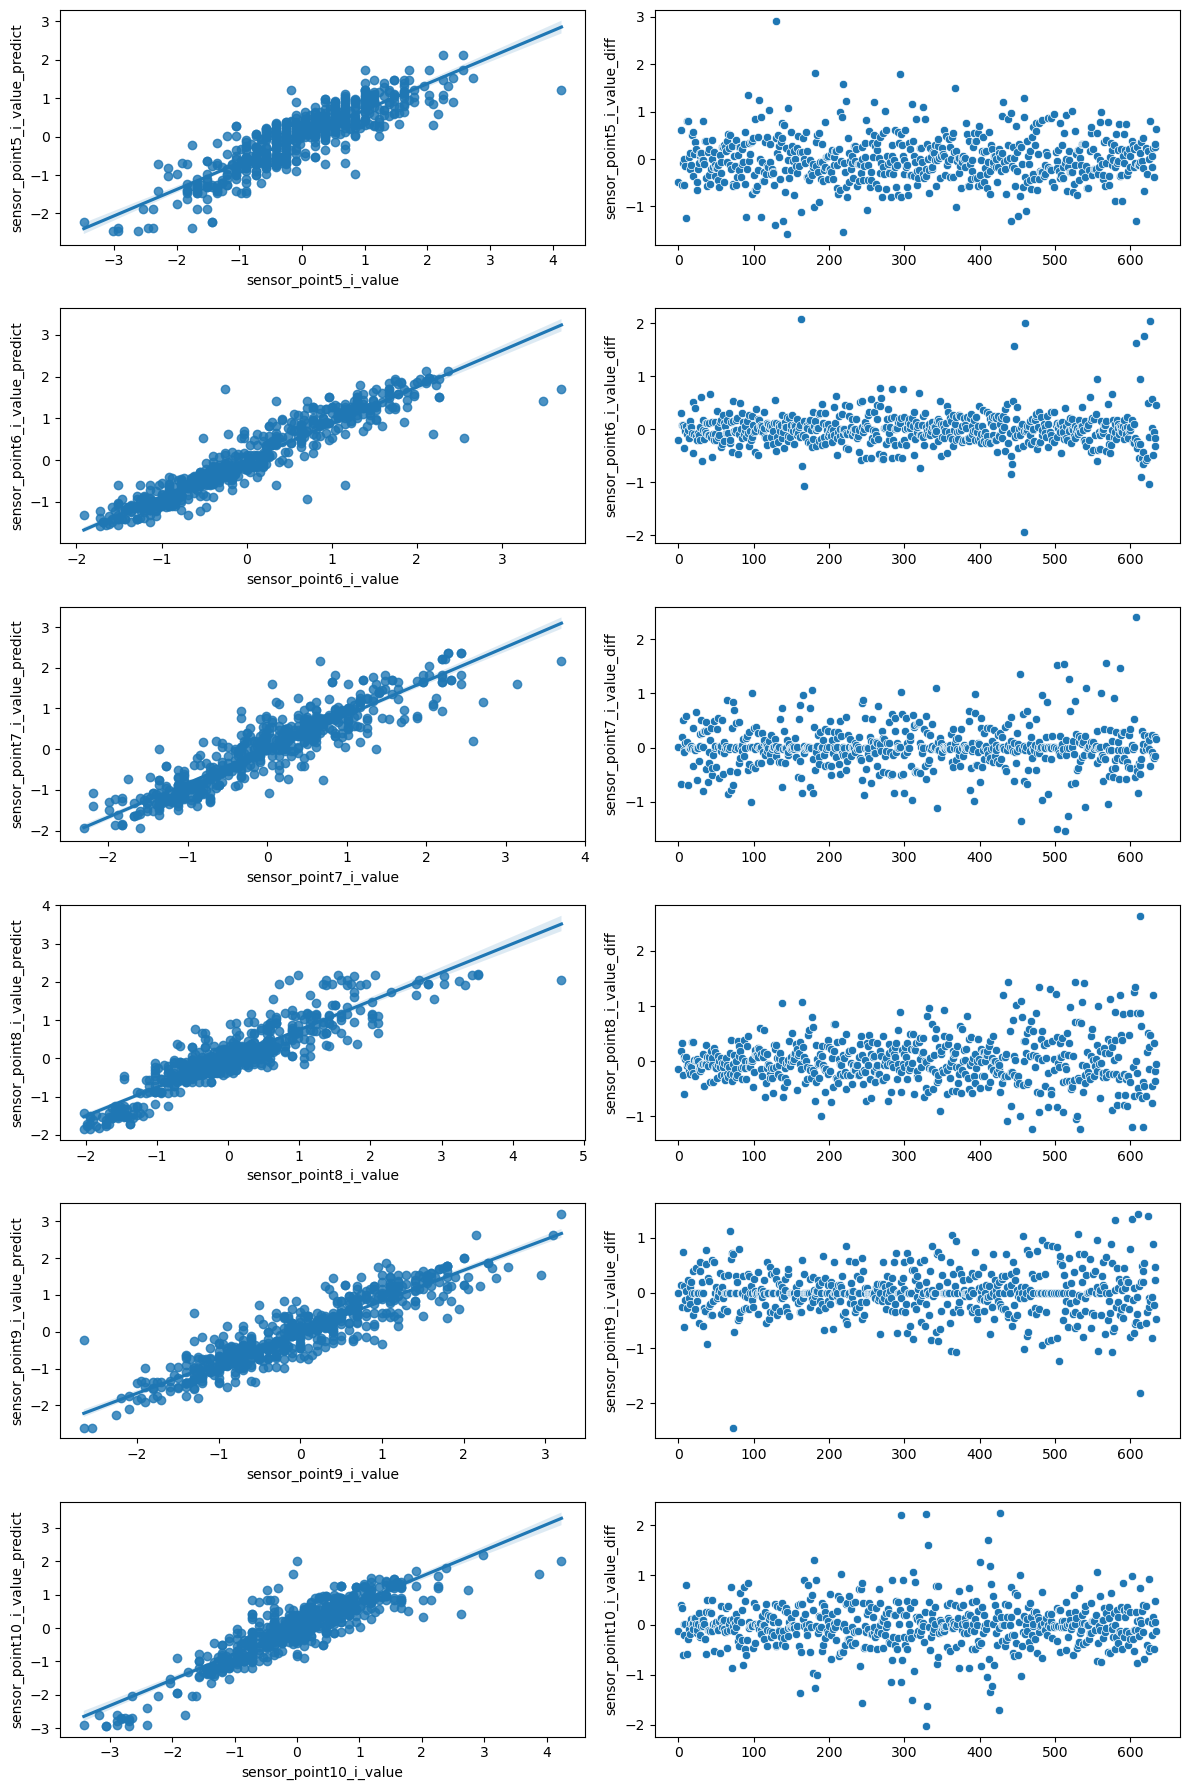

In [24]:
# 計算實際值跟預測值差異

data_T = Model_result # 資料類型
Model_ch = 'XGB' # 選擇 model

Y_predict_diff = data_y # 創建起始Table
for i in range(6):
    Y_predict_diff[data_y.columns.tolist()[i] + '_predict'] = data_T[Model_ch + '_' + data_y.columns.tolist()[i]]
    Y_predict_diff[data_y.columns.tolist()[i] + '_diff'] = data_T['Actual_' + data_y.columns.tolist()[i]]\
                                                            - data_T[Model_ch + '_' + data_y.columns.tolist()[i]]
# display(Y_predict_diff)

# seaborn呈現結果
fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i in range(6):
    # 預測值跟實際值分布狀況
    sns.regplot(x = data_y.columns.tolist()[i], 
                y = data_y.columns.tolist()[i] + '_predict', 
                data = Y_predict_diff, 
                ax=axes[i, 0])
    
    # 每筆資料的差異
    sns.scatterplot(x = Y_predict_diff.index,
                    y = data_y.columns.tolist()[i] + '_diff',
                    data = Y_predict_diff, 
                    ax=axes[i, 1])
    
    
plt.tight_layout()